# **Libraries**

In [ ]:
!pip install ucimlrepo==0.0.7
!pip install dcor==0.6
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip install xgboost==2.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.7 MB/s eta 0:00:00
Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 95.0 MB/s eta 0:00:00


In [ ]:
# Importing Libraries

## Data import
from ucimlrepo import fetch_ucirepo

## Data manipulation
import numpy as np
import pandas as pd

## Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    MinMaxScaler,
  )
from dcor import distance_correlation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


## Validation and Hyperparameter tuning
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
  )


## Models
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    ExtraTreesClassifier,
    ExtraTreesRegressor
  )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance


## Performance metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
  )

## Scipy functions
from scipy.stats import randint

## Othe imports
import time
import datetime
import warnings
from os import rename
from google.colab import files
# Ignore the UndefinedMetricWarning
warnings.filterwarnings("ignore")
RANDOM_STATE=1981

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Base functions**

**Load data**

In [ ]:
def load_data_from_ucimlrepo(repo_id, variable_rename_dict=None):
  # fetch dataset
  dataset = fetch_ucirepo(id=repo_id)

  # metadata
  print(dataset.metadata)

  # variable information
  print(dataset.variables)
  variables_df = dataset.variables
  variables_df['name'] = variables_df['name'].str.lstrip()

  # data (as pandas dataframes)
  df = dataset.data.features

  # Rename columns using the dictionary
  if variable_rename_dict:
    df = df.rename(columns=variable_rename_dict)
    variables_df['name'] = variables_df['name'].map(variable_rename_dict)

  df['Target'] = dataset.data.targets

  # Remove spaces at the beginning of each column name
  df.columns = df.columns.str.lstrip()
  return df, variables_df

**Variable encoding**

In [ ]:
def encode_binary_variables(df, binary_cols, binary_values):
  for col in binary_cols:
      df[col] = df[col].map(binary_values)
  return df

def one_hot_encoding(df, categorical_cols, encoder=None):
  """
  Performs one-hot encoding on specified categorical columns.

  Args:
      df: The input DataFrame.
      categorical_cols: A list of categorical columns to encode
      encoder: if mode 'test', receives here the scaler object to be used

  Returns:
      A DataFrame with the categorical columns one-hot encoded.
  """
  # Initialize encoder
  if encoder is None:  # train mode
    encoder = OneHotEncoder(
        drop='first', sparse_output=False, handle_unknown='ignore'
    )
    # Fit and transform training data
    encoded_df = encoder.fit_transform(df[categorical_cols])
  else:  # test mode
    # Transform test data using same encoding
    encoded_df = encoder.transform(df[categorical_cols])

  # Convert to DataFrame with proper column names
  feature_names = encoder.get_feature_names_out(categorical_cols)
  encoded_df = pd.DataFrame(encoded_df, columns=feature_names, index=df.index)

  non_categorical_cols = [col for col in df.columns if col not in categorical_cols]
  final_df = pd.concat([df[non_categorical_cols], encoded_df], axis=1)
  return final_df, encoder


def map_encoded_variables_to_original(encoded_vars, categorical_vars):
  """
  Creates a dictionary that maps each one-hot encoded variable to its
  original categorical variable.

  Args:
      encoded_vars: A list of one-hot encoded variable names.
      categorical_vars: A list of original categorical variable names.

  Returns:
      A dictionary with one-hot encoded variables as keys and original
      categorical variables as values.
  """
  # dictionary to store the mapping
  one_hot_mapping = {}

  # Iterate through original categorical variables
  for cvar in categorical_vars:
      # Get the one-hot encoded columns derived from this original column
      encoded_cols = [c for c in encoded_vars if c.startswith(cvar + "_")]
      # Map encoded columns to the original column
      for evar in encoded_cols:
          one_hot_mapping[evar] = cvar
  return one_hot_mapping

**Feature scaling:**

- In use for SVM and LR algorithms.
- MinMax Scaler chosen due to maintaining binary/ohe variables original values, meanwhile numerical variables get a similar domain of variation. This choice keeps the full interpretability of binary/ohe variables.

In [ ]:
def scale_minmax_features(df, mode, scaler = None):
  """
  Scale features to range [0,1] using MinMaxScaler

  Args:
      df: dataframe with the features to be scaled
      mode: 'train' or 'test'
      scaler: if mode 'test', receives here the scaler object to be used

  Returns:
      df_scaled: scaled features
      scaler: fitted scaler object
  """
  if mode == 'train':
      # Initialize the scaler
    scaler = MinMaxScaler()
    # Fit on training data and transform it
    df_scaled = scaler.fit_transform(df)
  else:
    # Transform test data using the fitted scaler
    df_scaled = scaler.transform(df)

  # Convert back to DataFrames with original column names
  df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

  return df_scaled, scaler

**Data summary and quality**

In [ ]:
def describe_data(df):
  # Dimension
  print("\nData dimension :")
  print("Number of Records : ",df.shape[0],"\nNumber of Features : ", df.shape[1])

  # Datatype of columns
  print("\nDatatype of Features :")
  print(df.dtypes.value_counts())

  # Missing values
  print("\nMissing values :")
  na_value_check = df.isna().sum()
  if len(na_value_check[na_value_check > 0]) == 0 :
      print("Missing values not identified")
  else :
      print(na_value_check[na_value_check > 0])

  # Duplicated records check
  print("\nDuplicated records :")
  duplicate_rows = df.duplicated()
  if len(df[duplicate_rows]) == 0:
      print("Duplicated records not identified")
  else :
      print("Number of duplicated records :",len(df[duplicate_rows]))

  # data summary
  print("\nData summary :")
  print(df.describe())

**Correlation**

In [ ]:
def non_numeric_variables(df, exclude_types):
  # Filter out variables that are not mumeric
  non_numeric_variables = df.select_dtypes(exclude=exclude_types)
  return non_numeric_variables.columns.tolist()

def create_heatmap(matrix, title, center=0, mask=None):
  # Create a heatmap from the matrix provided as input
  f, ax = plt.subplots(figsize=(11, 9))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(matrix, cmap=cmap, center=center,
              mask=mask, linewidths=.5,
              cbar_kws={"shrink": .5})
  plt.title(title)
  plt.show()

def calculate_correlation(df, corr_method, features='all'):
  # Compute the correlation matrix
  if features == "all":
    corr = df.corr(method=corr_method)
  else :
    corr = df[features].corr()

  # Create a mask to hide the upper triangle of the correlation matrix
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Generate a heatmap with the correlation matrix
  create_heatmap(corr, title="Correlation matrix", mask=mask)
  return corr

In [ ]:
def calculate_distance_correlation_matrix(df, features='all', debug=False):
    """
    Calculates the distance correlation matrix for a given DataFrame.

    Args:
      df: the input DataFrame
      features: 'all' or a list of the features to be considered
      debug: True / False to control the printing of additional information

    Returns:
      A distance correlation matrix as a pandas DataFrame.
      Produces a heatmap for the distance correlation matrix.
    """

    # Select features
    if features == "all":
        selected_df = df
    else:
        selected_df = df[features]

    print('df columns: ', selected_df.columns)

    # Convert all int64 columns in float64 to avoid errors
    int64_cols = selected_df.select_dtypes(include=['int64']).columns
    selected_df[int64_cols] = df[int64_cols].astype('float64')

    # Initialize distance correlation matrix
    n_features = len(selected_df.columns)
    print('num_features: ', n_features)
    dcor_matrix = pd.DataFrame(
        np.zeros((n_features, n_features)),
        index=selected_df.columns,
        columns=selected_df.columns
    )

    # Calculate distance correlation for each pair
    for i, col1 in enumerate(selected_df.columns):
        if debug: print('col1: ', col1)
        for j, col2 in enumerate(selected_df.columns):
            if debug: print('----- col2: ', col2)
            if i <= j:  # Only calculate upper triangle
                # Convert categorical variables to numeric
                x = pd.Categorical(selected_df[col1]).codes if selected_df[col1].dtype == 'object' else selected_df[col1]
                y = pd.Categorical(selected_df[col2]).codes if selected_df[col2].dtype == 'object' else selected_df[col2]

                # Calculate distance correlation
                dcor = distance_correlation(x, y, method='mergesort')

                dcor_matrix.iloc[i, j] = dcor
                dcor_matrix.iloc[j, i] = dcor  # Matrix is symmetric

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(dcor_matrix, dtype=bool))
    # Create heatmap
    create_heatmap(dcor_matrix, title="Distance Correlation Matrix", mask=mask)
    return dcor_matrix

In [ ]:
def plot_dcor_histogram(dcor_df):
    """
    Reads a distance correlation (dcor) DataFrame and produces a histogram
    of the distance correlations, displaying percentages on the y-axis.
    Also prints the percentage of correlations below different thresholds.

    Args:
      dcor_df : The distance correlation matrix as a pandas DataFrame.

    Returns:
      Histogram plot of the distance corelations between features.
    """

    # Flatten the matrix and exclude diagonal elements for histogram
    flattened_dcor = dcor_df.where(~np.eye(dcor_df.shape[0], dcor_df.shape[1], dtype=bool)).stack()

    # Create histogram with 10 equally spaced bins from 0 to 1.0
    bins = np.linspace(0, 1.0, 11)  # Creates bins with edges at 0, 0.1, ..., 1
    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(flattened_dcor, bins=bins, color='blue', alpha=0.7, edgecolor='black')

    # Convert counts to percentages of total
    total_count = flattened_dcor.count()
    percentage_heights = (n / total_count) * 100  # Multiply by 100 for actual percentage values

    # Set y-axis labels to percentages
    for i in range(len(patches)):
        patches[i].set_height(percentage_heights[i])  # Update patch height
        plt.text(patches[i].get_x() + patches[i].get_width() / 2,
                 percentage_heights[i] + 0.5,  # Add 0.5 for better spacing
                 f'{percentage_heights[i]:.2f}%',  # Display percentage with 2 decimal places
                 ha='center', va='bottom')

    plt.title('Histogram of Distance Correlations (% of Total)')
    plt.xlabel('Distance Correlation')
    plt.ylabel('% of Total Correlations')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(percentage_heights) + 5)  # Set y-axis limits slightly above max percentage
    plt.show()

    # Calculate and print percentage of correlations below different thresholds
    for i in np.arange(0.1, 1.1, 0.1):  # From 0.1 to 1.0 in steps of 0.1
        percentage_below = (flattened_dcor[flattened_dcor <= i].count() / total_count) * 100
        print(f"Percentage of correlations below {i:.1f}: {percentage_below:.2f}%")


**Pre-feature selection**

In [ ]:
def identify_zero_variance_columns(df):
  # Calculate the variance of each column
  variances = df.var()
  print("Variance of each column:")
  print(variances)

  # Identify columns with zero variance
  zero_variance_columns = variances[variances <= 1.00e-10].index.tolist()
  print("Columns with zero variance to be dropped:")
  print(zero_variance_columns)
  return zero_variance_columns


def identify_weak_associated_features(association_matrix, target_variable, threshold=0.1):
  """
  Identifies features with a weak association with the target variable.

  Args:
    association_matrix: usually a correlation matrix as dataframe
    target_variable: The name of the target variable column.
    threshold: value for which correlations below are considered weak

  Returns:
    A list of feature names that have a association with the target variable
    lower than the threshold.
  """
  target_association = association_matrix[target_variable]
  weak_associated_features = target_association[
      abs(target_association) < threshold
  ].index.tolist()
  print("Features with weak association with the target variable:")
  print(weak_associated_features)
  return weak_associated_features


def filter_out_intercorrelated_features(corr_df, target_name, correlation_threshold=0.8):
  """
  Filters highly correlated features based on a distance correlation matrix.

  Args:
      corr_df: Dataframe with the correlation matrix
      target_name: Name of the column with the target
      correlation_threshold: The threshold for correlation above which features
                             are considered highly correlated.

  Returns:
      A list of features after dropping of intercorrelated
  """

  # get a list with the features sorted by correlation with target
  target_correlations = corr_df[target_name].sort_values(ascending=False)
  sorted_correlated_feat_with_target = [feat for feat in target_correlations.index if feat != target_name]

  selected_features = []
  eliminated_features = []

  # Iterate through features, starting with the most correlated to the target
  for feat in sorted_correlated_feat_with_target:
      if feat not in eliminated_features:  # If not already eliminated
          selected_features.append(feat)
          print('appended feature: ', feat)

          # Eliminate other features highly correlated with the current feature
          for other_feat in sorted_correlated_feat_with_target:
              if other_feat != feat and other_feat not in eliminated_features:
                  correlation = corr_df[corr_df.index==feat][other_feat][0]
                  if abs(correlation) > correlation_threshold:
                      eliminated_features.append(other_feat)
                      print('eliminated feature: ', other_feat, correlation)
  return selected_features

**Missing values handling**

**Simple imputation (median and mode):** Missing values will be inputed with the median for numerical variables and with the model for binary/ohe variables. This choice guarantees that the value inputed is a value that makes sense for the domain of each variable and also avoid the influence of outliers or long-tailed distributions.

**Imputation via MissForest:** The missing values are inputed via an ensemble model that makes use of all other features available at the moment. Note that for this use case a new MissForest algorithm has to be run at each scenario, because the features available will change. Otherwise there will be unfair data leakage.

Note: In the case of models that require feature scaling (normalization), the simple inputation will be based on the median and mode of features after scaling.

In [ ]:
def calculate_imputation_values_for_missing(df):
  """
  Calculates the median for numeric columns and mode for non-numeric columns in a DataFrame.

  Args:
    df: The pandas DataFrame.

  Returns:
    A dictionary with column names as keys and their median/mode as values.
  """
  imputation_dict = dict()
  for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
      imputation_dict[column] = df[column].median()
    else:
      imputation_dict[column] = df[column].mode()[0] if not df[column].mode().empty else None
  return imputation_dict


def imputation_missforest(train_df, test_df, cat_vars_list=[]):
  """
  Auxiliary function for Performance Decay
  Imputes missing values in the testing datasets using the MissForest algorithm.

  Args:
    train_df / test_df: DataFrame with training/test data
    cat_vars_list: list of categorical variables for imputation

  Returns:
    test_df_imputed: DataFrame with imputed missing values by MissForest
  """
  # check of the nr of columsn with nan
  nan_counts_per_column = test_df.isnull().any()
  num_columns_with_nan = nan_counts_per_column.sum()
  print('Nr. columns with nan: ', num_columns_with_nan)
  columns_with_nulls = test_df.columns[test_df.isnull().any()].tolist()

  # identify categorical and numerical features
  categorical = cat_vars_list
  numerical = [col for col in test_df.columns if col not in categorical and col!='Type']
  print('Numerical columns: ', numerical)
  print('Categorical columns: ', categorical)

  train_df['Type'] = 'Train'
  test_df['Type'] = 'Test'
  df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
  df_imputation = df.drop(columns=['Type'])
  """
  # missforest with random forests

  imp_num = IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)
  """

  # missforest with extra trees (faster and with similar performance)
  imp_num = IterativeImputer(estimator=ExtraTreesRegressor(
                              max_features='sqrt',
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=ExtraTreesClassifier(
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)

  if len(numerical)>0:
    df_imputation[numerical] = imp_num.fit_transform(df_imputation[numerical])

  if len(categorical)>0:
    df_imputation[categorical] = imp_cat.fit_transform(df_imputation[categorical])

  # test_df_imputed and auxiliary info to be displayed along the imputation
  test_df_imputed = df_imputation[df['Type']=='Test']
  for col in columns_with_nulls:
    print('Column imputed: ', col)
    if col in numerical:
      print('Mean: ', test_df_imputed[col].mean())
      print('Std deviation: ', test_df_imputed[col].std())
    else:
      print(test_df_imputed[col].value_counts())
  return test_df_imputed

**Model training / Feature permutation importance / Hyperparameter optimization**

In [ ]:
def apply_model(model, X_train, y_train, X_test, y_test):
  # Fit the model
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  return model, y_train_pred, y_test_pred


def analyze_feat_permut_import(
    model, X, y, scoring_metric, n_repeats=5, random_state=RANDOM_STATE
):
    # Calculate permutation importance
    result = permutation_importance(
        model, X, y, scoring=scoring_metric, n_repeats=n_repeats,
        random_state=random_state, n_jobs=-1
    )

    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    }).sort_values(by='Importance', ascending=True)

    return importance_df.sort_values(by='Importance', ascending=False)


def plot_feat_permut_importance(feat_imp_df, threshold=0, k=20):
  # Filter features with importance above the threshold
  feat_imp_plot = feat_imp_df[feat_imp_df['Importance'] > threshold]
  feat_imp_plot = feat_imp_plot.sort_values(by='Importance', ascending=False)

  # select the top k features
  if len(feat_imp_plot) > k:
    feat_imp_plot = feat_imp_plot.head(k)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feat_imp_plot['Feature'], feat_imp_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Permutation Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()


def plot_feature_importance(model, importance_threshold, col_names):
  if model.__class__.__name__ == 'LGBMClassifier':
    feature_importances = model.booster_.feature_importance(importance_type='split')
  else:
    feature_importances = model.feature_importances_

  # Create a DataFrame with feature names and importances
  feature_importance_df = pd.DataFrame({'Feature': col_names, 'Importance': feature_importances})

  # Sort features by importance in descending order
  feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

  # Filter features with importance above the threshold
  feature_importance_plot = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]
  if len(feature_importance_plot) > 20:
    feature_importance_plot = feature_importance_plot.head(20)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feature_importance_plot['Feature'], feature_importance_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()
  return feature_importance_df


def hyperparameter_tuning(model, param_grid, k_hyp_par, k_cv, scoring_metric, X, y):
    """
    Performs hyperparameter tuning using nested cross-validation.

    Args:
        model: The base model to be tuned.
        param_grid: A dictionary containing the hyperparameter grid.
        k_hyp_par: The number of folds for the inner cross-validation.
        k_cv: The number of folds for the outer cross-validation.
        scoring_metric: The scoring metric to be used for evaluation.
        X: The feature matrix.
        y: The target variable.

    Returns:
        A tuple containing the fitted GridSearchCV object, nested scores, and best parameters.
    """
    # Time control
    start_time = time.time()
    print(f"Starting hyperparameter tuning at: {datetime.datetime.now()}")

    # Cross-validation strategies for inner and outer loops
    cv_inner = StratifiedKFold(n_splits=k_hyp_par, shuffle=True, random_state=RANDOM_STATE)
    cv_outer = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=RANDOM_STATE)

    # Hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_inner,
        scoring=scoring_metric,
        verbose=3,
        n_jobs=-1,
        return_train_score=True,  # To help diagnose overfitting/underfitting
        refit=True
    )

    # Perform nested cross-validation
    nested_scores = cross_val_score(
        grid_search,
        X=X,
        y=y,
        cv=cv_outer,
        scoring=scoring_metric,
        n_jobs=-1
    )

    # Print cross-validation results
    print("\nNested Cross-validation Results:")
    print(f"Individual scores: {nested_scores}")
    print(f"Average nested CV score: {nested_scores.mean():.3f} (+/- {nested_scores.std() * 2:.3f})")

    # Fit the model on the entire dataset
    print("\nFitting final model on entire dataset...")
    grid_search.fit(X, y)

    # Get best parameters and scores
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    cv_results = pd.DataFrame(grid_search.cv_results_)

    print("\nBest Model Performance:")
    print(f"Best CV score: {grid_search.best_score_:.3f}")

    # Print execution time
    print(datetime.datetime.now())
    end_time = time.time()
    execution_time = (end_time - start_time) / 60
    print(f"\nExecution time: {execution_time:.2f} minutes")

    return grid_search, best_model, best_params

**Performance**

In [ ]:
# Calculation of performance metrics
def perf_metrics(y_true, y_pred_binary):
    """
    Returns a dictionary with the values of the main metrics
    """
    # Calculate Specificity using confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    specificity = tn / (tn + fp)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary,average='binary')
    recall = recall_score(y_true, y_pred_binary,average='binary')
    f1 = f1_score(y_true, y_pred_binary,average='binary')

    # Create dictionary to store metrics
    metrics_dict = {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'precision': round(precision*100,2),
        'recall': round(recall*100,2),
        'specificity': round(specificity*100,2),
        'accuracy': round(accuracy*100,2),
        'f1_score': round(f1*100,2),
        'balanced_accuracy' : round(balanced_accuracy*100,2)
    }

    return metrics_dict


def measure_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, imputation_dict=None, num_feat=25,
  method='simple', encoded_vars_family=None, categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """

  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    if features_importance_list[i] in removed:
      i = i+1
      continue
    current_feature = features_importance_list[i]
    print("Removing feature: ", current_feature)
    if encoded_vars_family is not None:
      # all the ohe variables derived from the original category should be set to missing
      if current_feature in encoded_vars_family.keys():
        original_feature = encoded_vars_family[current_feature]
        related_features = [k for k,v in encoded_vars_family.items() if v == original_feature]
        # related features that are still in the model (e.g. logistic regression does not have all feat)
        related_features = [feat for feat in related_features if feat in X_test.columns]
        print("Removing related features: ", related_features)
        removed.extend(related_features)
        original_removed.extend([original_feature])
        for feature in related_features:
          if method == 'simple':
            X_test_new[feature] = imputation_dict[feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]
    else:
      removed.extend([current_feature])
      original_removed.extend([current_feature])
      if method == 'simple':
        X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Variance of each column:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed

**Save results**

In [ ]:
def combine_datasets(datasets, source_name, scenario_name, seed):
  """Combines multiple datasets with the same schema into a single DataFrame.

  Args:
    datasets: A dictionary of pandas DataFrames.
    source_name: A string representing the name of the dataset source.
    scenario_name: A string representing the name of the experiment.

  Returns:
    A pandas DataFrame containing all datasets combined, with new columns
    indicating the source dataset and the experiment name.
  """

  combined_df = pd.DataFrame()
  for name, df in datasets.items():
      df['dataset'] = name
      df['source'] = source_name
      df['scenario'] = scenario_name
      df['random_state'] = seed
      if '2' in name:
        df['metric'] = 'balanced accuracy'
      else:
        df['metric'] = 'f1 score'
      combined_df = pd.concat([combined_df, df], ignore_index=True)
  return combined_df

def save_dataset(df, dataset_name):
  df.to_csv(dataset_name, encoding = 'utf-8-sig')
  files.download(dataset_name)

# **Load data**

In [ ]:
taiwanese_bankruptcy, taiwanese_variables = load_data_from_ucimlrepo(572)

{'uci_id': 572, 'name': 'Taiwanese Bankruptcy Prediction', 'repository_url': 'https://archive.ics.uci.edu/dataset/572/taiwanese+bankruptcy+prediction', 'data_url': 'https://archive.ics.uci.edu/static/public/572/data.csv', 'abstract': 'The data were collected from the Taiwan Economic Journal  for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange.', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 6819, 'num_features': 95, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Bankrupt?'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C5004D', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': None, 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_data_splits': None, 'sensitive_data': Non

In [ ]:
taiwanese_bankruptcy.head()

ROA(C) before interest and depreciation before interest  \
0                                           0.370594         
1                                           0.464291         
2                                           0.426071         
3                                           0.399844         
4                                           0.465022         

   ROA(A) before interest and % after tax  \
0                                0.424389   
1                                0.538214   
2                                0.499019   
3                                0.451265   
4                                0.538432   

   ROA(B) before interest and depreciation after tax  Operating Gross Margin  \
0                                           0.405750                0.601457   
1                                           0.516730                0.610235   
2                                           0.472295                0.601450   
3                                           0.457733                0.583541   
4                                           0.522298                0.598783   

   Realized Sales Gross Margin  Operating Profit Rate  \
0                     0.601457               0.998969   
1                     0.610235               0.998946   
2                     0.601364               0.998857   
3                     0.583541               0.998700   
4                     0.598783               0.998973   

   Pre-tax net Interest Rate  After-tax net Interest Rate  \
0                   0.796887                     0.808809   
1                   0.797380                     0.809301   
2                   0.796403                     0.808388   
3                   0.796967                     0.808966   
4                   0.797366                     0.809304   

   Non-industry income and expenditure/revenue  \
0                                     0.302646   
1                                     0.303556   
2                                     0.302035   
3                                     0.303350   
4                                     0.303475   

   Continuous interest rate (after tax)  ...  Total assets to GNP price  \
0                              0.780985  ...                   0.009219   
1                              0.781506  ...                   0.008323   
2                              0.780284  ...                   0.040003   
3                              0.781241  ...                   0.003252   
4                              0.781550  ...                   0.003878   

   No-credit Interval  Gross Profit to Sales  \
0            0.622879               0.601453   
1            0.623652               0.610237   
2            0.623841               0.601449   
3            0.622929               0.583538   
4            0.623521               0.598782   

   Net Income to Stockholder's Equity  Liability to Equity  \
0                            0.827890             0.290202   
1                            0.839969             0.283846   
2                            0.836774             0.290189   
3                            0.834697             0.281721   
4                            0.839973             0.278514   

   Degree of Financial Leverage (DFL)  \
0                            0.026601   
1                            0.264577   
2                            0.026555   
3                            0.026697   
4                            0.024752   

   Interest Coverage Ratio (Interest expense to EBIT)  Net Income Flag  \
0                                           0.564050                 1   
1                                           0.570175                 1   
2                                           0.563706                 1   
3                                           0.564663                 1   
4                                           0.575617                 1   

   Equity to Liability  Target  
0             0.016469       

In [ ]:
taiwanese_variables

name     role        type  \
0                                           Bankrupt?   Target     Integer   
1   ROA(C) before interest and depreciation before...  Feature  Continuous   
2              ROA(A) before interest and % after tax  Feature  Continuous   
3   ROA(B) before interest and depreciation after tax  Feature  Continuous   
4                              Operating Gross Margin  Feature  Continuous   
..                                                ...      ...         ...   
91                                Liability to Equity  Feature  Continuous   
92                 Degree of Financial Leverage (DFL)  Feature  Continuous   
93  Interest Coverage Ratio (Interest expense to E...  Feature  Continuous   
94                                    Net Income Flag  Feature     Integer   
95                                Equity to Liability  Feature  Continuous   

   demographic description units missing_values  
0         None        None  None             no  
1         None        None  None             no  
2         None        None  None             no  
3         None        None  None             no  
4         None        None  None             no  
..         ...         ...   ...            ...  
91        None        None  None             no  
92        None        None  None             no  
93        None        None  None             no  
94        None        None  None             no  
95        None        None  None             no  

[96 rows x 7 columns]

# **Data summary and quality**

In [ ]:
describe_data(taiwanese_bankruptcy)


Data dimension :
Number of Records :  6819 
Number of Features :  96

Datatype of Features :
float64    93
int64       3
Name: count, dtype: int64

Missing values :
Missing values not identified

Duplicated records :
Duplicated records not identified

Data summary :
       ROA(C) before interest and depreciation before interest  \
count                                        6819.000000         
mean                                            0.505180         
std                                             0.060686         
min                                             0.000000         
25%                                             0.476527         
50%                                             0.502706         
75%                                             0.535563         
max                                             1.000000         

       ROA(A) before interest and % after tax  \
count                             6819.000000   
mean                                 0.

# **Split data in train and test set**

In [ ]:
taiwanese_bankruptcy_train, taiwanese_bankruptcy_test = train_test_split(
    taiwanese_bankruptcy, test_size=0.20, random_state=RANDOM_STATE,
    stratify=taiwanese_bankruptcy["Target"]
)
taiwanese_bankruptcy_train['Target'].value_counts()

Target
0    5279
1     176
Name: count, dtype: int64

In [ ]:
taiwanese_bankruptcy_test['Target'].value_counts()

Target
0    1320
1      44
Name: count, dtype: int64

# **Correlation**

In [ ]:
taiwanese_bankruptcy_train.dtypes

ROA(C) before interest and depreciation before interest    float64
ROA(A) before interest and % after tax                     float64
ROA(B) before interest and depreciation after tax          float64
Operating Gross Margin                                     float64
Realized Sales Gross Margin                                float64
                                                            ...   
Degree of Financial Leverage (DFL)                         float64
Interest Coverage Ratio (Interest expense to EBIT)         float64
Net Income Flag                                              int64
Equity to Liability                                        float64
Target                                                       int64
Length: 96, dtype: object

Despite distance correlation having been selected as the association metric, it is also presented below the results for Spearman correlation just for reference and comparison.

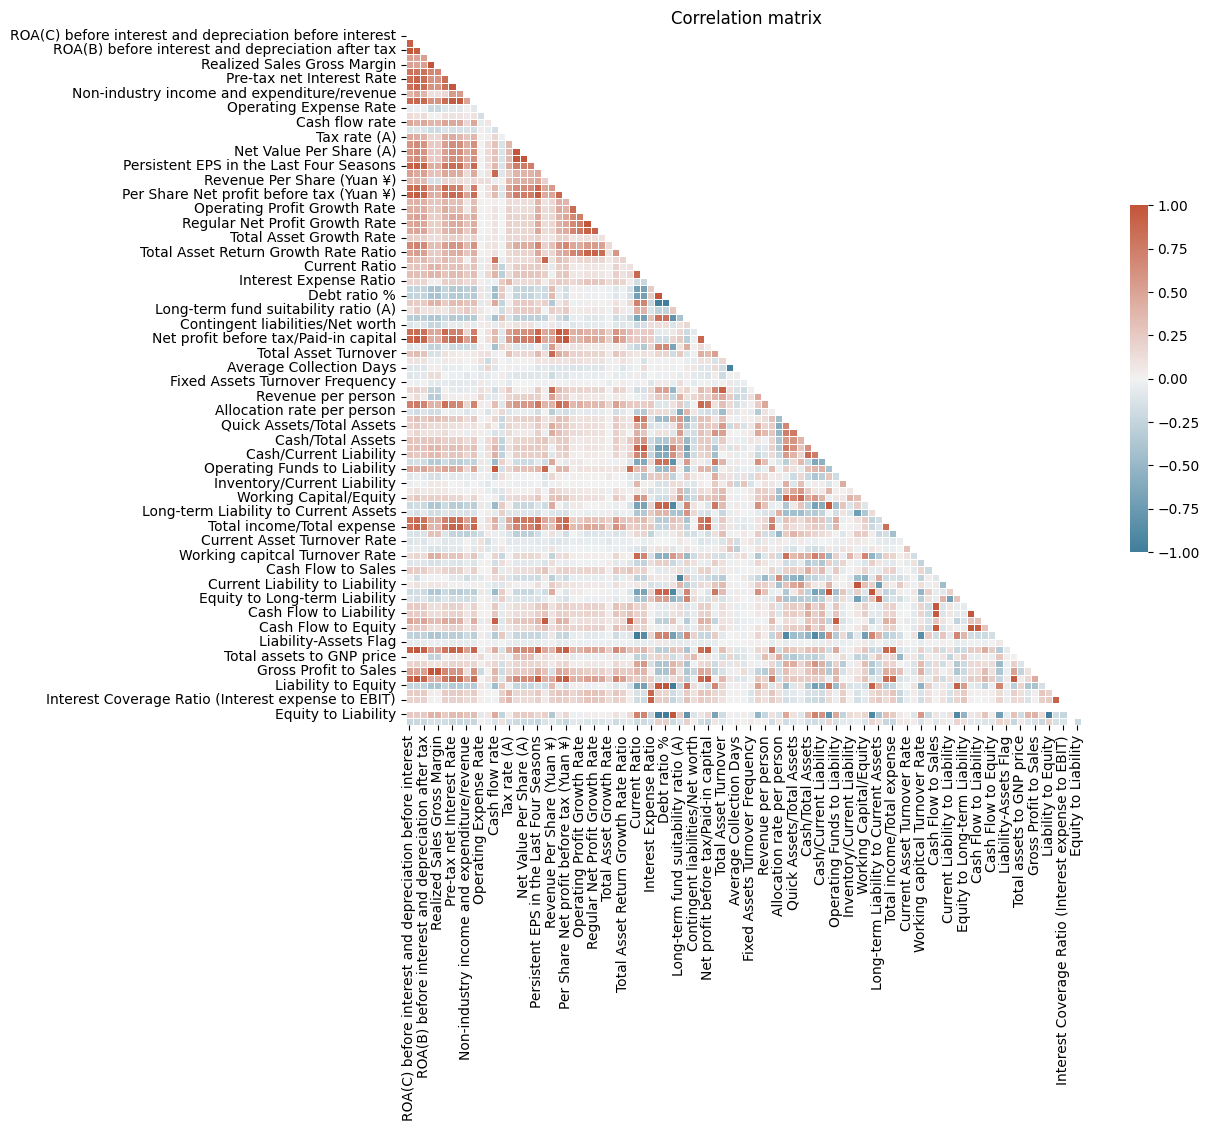

In [ ]:
taiwan_corr = calculate_correlation(taiwanese_bankruptcy_train, 'spearman')

In [ ]:
abs(taiwan_corr['Target']).sort_values(ascending=False)

Target                                      1.000000
Persistent EPS in the Last Four Seasons     0.241323
Net Income to Total Assets                  0.236626
Net profit before tax/Paid-in capital       0.235747
Per Share Net profit before tax (Yuan ¥)    0.235052
                                              ...   
Revenue per person                          0.019559
Inventory Turnover Rate (times)             0.009667
Net Worth Turnover Rate (times)             0.008920
Operating Expense Rate                      0.008045
Net Income Flag                                  NaN
Name: Target, Length: 96, dtype: float64

df columns:  Index(['ROA(C) before interest and depreciation before interest',
       'ROA(A) before interest and % after tax',
       'ROA(B) before interest and depreciation after tax',
       'Operating Gross Margin', 'Realized Sales Gross Margin',
       'Operating Profit Rate', 'Pre-tax net Interest Rate',
       'After-tax net Interest Rate',
       'Non-industry income and expenditure/revenue',
       'Continuous interest rate (after tax)', 'Operating Expense Rate',
       'Research and development expense rate', 'Cash flow rate',
       'Interest-bearing debt interest rate', 'Tax rate (A)',
       'Net Value Per Share (B)', 'Net Value Per Share (A)',
       'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons',
       'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)',
       'Operating Profit Per Share (Yuan ¥)',
       'Per Share Net profit before tax (Yuan ¥)',
       'Realized Sales Gross Profit Growth Rate',
       'Operating Profit Growth Rate', 'After-tax

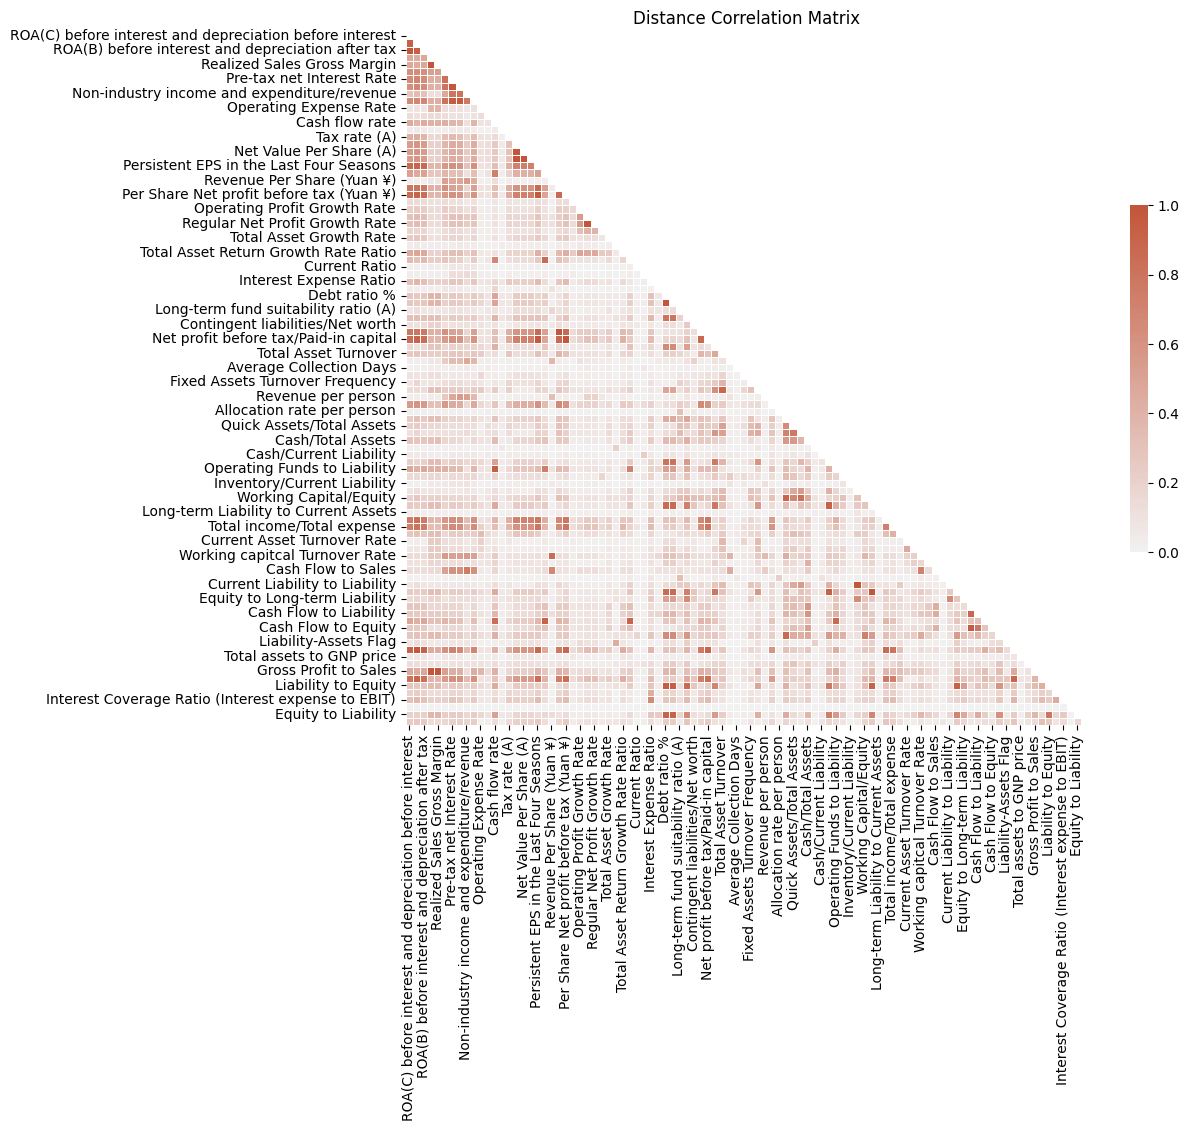

In [ ]:
taiwan_dist_corr = calculate_distance_correlation_matrix(taiwanese_bankruptcy_train)

In [ ]:
taiwan_dist_corr['Target'].sort_values(ascending=False)

Target                                1.000000
Net Income to Stockholder's Equity    0.327210
Net Income to Total Assets            0.287645
Borrowing dependency                  0.283166
Retained Earnings to Total Assets     0.275449
                                        ...   
Average Collection Days               0.007528
Revenue Per Share (Yuan ¥)            0.005482
Quick Assets/Current Liability        0.004280
Current Ratio                         0.002472
Net Income Flag                       0.000000
Name: Target, Length: 96, dtype: float64

# **Pre-feature selection**
Features with zero-variance will be dropped. The code gives the option for additional removal of extremely weak correlation with the target variable. Nonetheless we will not be using it given that we have non-linear models being tested.

In [ ]:
filtered_features = filter_out_intercorrelated_features(taiwan_dist_corr, 'Target', 0.8)

appended feature:  Net Income to Stockholder's Equity
eliminated feature:  Net Income to Total Assets 0.8973633447055411
eliminated feature:  ROA(A) before interest and % after tax 0.8889656438588007
eliminated feature:  Persistent EPS in the Last Four Seasons 0.8418923446221166
eliminated feature:  ROA(B) before interest and depreciation after tax 0.825242033356963
eliminated feature:  Net profit before tax/Paid-in capital 0.84275281712983
eliminated feature:  Per Share Net profit before tax (Yuan ¥) 0.8389737564714317
eliminated feature:  ROA(C) before interest and depreciation before interest 0.8112170983279147
appended feature:  Borrowing dependency
eliminated feature:  Liability to Equity 0.8572090276554882
appended feature:  Retained Earnings to Total Assets
appended feature:  Current Liabilities/Equity
eliminated feature:  Current Liability to Equity 0.9999999999736582
eliminated feature:  Debt ratio % 0.853558719131654
eliminated feature:  Net worth/Assets 0.8535587191307598
el

In [ ]:
# Drop columns with zero variance or weak correlation
DROP_WEAK_FEATURES = False
WEAK_THRESHOLD = 0.01

taiwan_zero_variance_columns = identify_zero_variance_columns(taiwanese_bankruptcy_train[filtered_features])

if DROP_WEAK_FEATURES:
  taiwan_weak_features = identify_weak_associated_features(taiwan_dist_corr, "Target", WEAK_THRESHOLD)
else:
  taiwan_weak_features = []

remove_columns = set(taiwan_zero_variance_columns + taiwan_weak_features)
remove_columns = [col for col in remove_columns if col in filtered_features]
print(remove_columns)

taiwanese_bankruptcy_train = taiwanese_bankruptcy_train[filtered_features + ['Target']].drop(columns=remove_columns)
taiwanese_bankruptcy_test = taiwanese_bankruptcy_test[filtered_features + ['Target']].drop(columns=remove_columns)

Variance of each column:
Net Income to Stockholder's Equity     2.535046e-04
Borrowing dependency                   3.213163e-04
Retained Earnings to Total Assets      6.913694e-04
Current Liabilities/Equity             2.186568e-04
Current Liability to Current Assets    9.495407e-04
                                           ...     
Accounts Receivable Turnover           6.793443e+16
Average Collection Days                4.868544e+16
Quick Assets/Current Liability         3.681583e+16
Current Ratio                          1.386343e+15
Net Income Flag                        0.000000e+00
Length: 65, dtype: float64
Columns with zero variance to be dropped:
['Net Income Flag']
['Net Income Flag']


In [ ]:
print('Original number of features: ', len(taiwanese_bankruptcy.columns))
print('Number of features after pre-feature selection: ', len(taiwanese_bankruptcy_train.columns))

Original number of features:  96
Number of features after pre-feature selection:  65


# **Imbalanced dataset**

In [ ]:
X_train = taiwanese_bankruptcy_train.drop('Target', axis=1)
y_train = taiwanese_bankruptcy_train['Target']

X_test = taiwanese_bankruptcy_test.drop('Target', axis=1)
y_test = taiwanese_bankruptcy_test['Target']

In [ ]:
target_counts = y_train.value_counts()
target_percentages = y_train.value_counts(normalize=True)

df_target_stats = pd.DataFrame({'Count': target_counts, 'Percentage': target_percentages})
df_target_stats

Count  Percentage
Target                   
0.0      5279    0.967736
1.0       176    0.032264

Class imbalance will be addressed directly in the models by using class_weight='balanced' or scale_pos_weight = # majority class / # minority class

# **Models optimized for F1-score**

**Usage of feature permutation importance:** Instead of calculating the feature importance, it is used the  permutation importance, which is less biased and reflects better the final goal of this use-case which is to measure the capacity of other variables replace the missing one.

**F1-score and Balanced Accuracy as performance metrics:** All the models in this section are trained using F1-score. In the next section, it will be used the Balanced Accuracy. These metrics were selected over the remaining ones because they:
- provide a more holistic view of the performance by considering precision and recall at the same time
- are more resilient to imbalanced datasets
- are among the preferred on several industries like Financial Services where the accuracy it is not enough per se.

**Missing values imputation with median (continuous variables) and mode (categorical variables):**
- simple missing value imputation technique to overcome the fact of some models implementation not handlung missing values natively and with this level up all the models with the same conditions
- median was used instead of the mean because it is more resilient to outliers and guarantees that the imputed value is part of the domain of the variable and in the case of binary variables median and mode coincide

In [ ]:
taiwan_imputation_values_dict = calculate_imputation_values_for_missing(taiwanese_bankruptcy_train)
taiwan_imputation_values_dict

{"Net Income to Stockholder's Equity": 0.841178095648715,
 'Borrowing dependency': 0.372707081235475,
 'Retained Earnings to Total Assets': 0.937683217906017,
 'Current Liabilities/Equity': 0.329707987639012,
 'Current Liability to Current Assets': 0.0276216730537866,
 'Continuous interest rate (after tax)': 0.781635097464106,
 'Total income/Total expense': 0.0023358000175328,
 'Net Value Per Share (A)': 0.184400151700308,
 'Working Capital/Equity': 0.73601232613396,
 'Operating Profit Per Share (Yuan ¥)': 0.104226040224737,
 'Non-industry income and expenditure/revenue': 0.303525251131211,
 'Operating profit per person': 0.395909183419642,
 'Equity to Long-term Liability': 0.112382557153558,
 'Equity to Liability': 0.0336263940514789,
 'Tax rate (A)': 0.0731855450956575,
 'Liability-Assets Flag': 0.0,
 'Operating Gross Margin': 0.606033525994898,
 'Interest Expense Ratio': 0.630698209613567,
 'Interest Coverage Ratio (Interest expense to EBIT)': 0.565250162447274,
 'Total expense/Asse

In [ ]:
taiwan_cat_vars = [col for col in X_train.columns if X_train[col].nunique() <= 2]
taiwan_cat_vars

['Liability-Assets Flag']

##**Decision tree**

**Cross-validation (3,3) for large datasets and (5,5) for smaller datasets:**
- due to the unpractical runtime of some of the models, the cross-validaton set up on large datasets consists in a nested-cv with 3-fold in both inner and outer CV. The number of folds is increased to (5,5) in smaller datsets.
- this assumption is reasonable given that in larger datasets there is a higher chance of the holdout samples being big enough to be more representative and less prone to biases. So a smaller number of folds can be assummed
- on the other hand, in smaller datasets it is crucial to reduce the variance and any potential misrepresentativeness of a specific validation set, so it is requires a larger number of folds to make a more efficient use of the data available.

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],  # last option reflects num of samples instead of proportion
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]  # last option reflects num of samples instead of proportion
  }
else:
  # best model
  dt_param_grid = {
    'max_depth': [5],
    'min_samples_split': [0.001],
    'min_samples_leaf': [1]
}

dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt_grid_search, dt_best_model, dt_best_params = hyperparameter_tuning(
    dt_classifier, dt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 10:55:25.237618

Nested Cross-validation Results:
Individual scores: [0.31226766 0.29370629 0.32283465]
Average nested CV score: 0.310 (+/- 0.024)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 0.001}

Best Model Performance:
Best CV score: 0.310
2025-01-16 10:55:27.731707

Execution time: 0.04 minutes




```
Starting hyperparameter tuning at: 2025-01-15 13:49:26.744772

Nested Cross-validation Results:
Individual scores: [0.29042904 0.26829268 0.29139073]
Average nested CV score: 0.283 (+/- 0.021)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 0.001}

Best Model Performance:
Best CV score: 0.310

Train score: 0.432
Test score: 0.310
Train-test score difference: 0.123
2025-01-15 13:49:58.478946

Execution time: 0.53 minutes
```



In [ ]:
# dt_grid_search.cv_results_

In [ ]:
dt_classifier, dt_train_pred, dt_test_pred = apply_model(dt_best_model, X_train, y_train, X_test, y_test)
dt_feat_permut_import_df = analyze_feat_permut_import(dt_classifier, X_train, y_train, scoring_metric="f1")
dt_feat_permut_import_df[dt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
5          Continuous interest rate (after tax)    0.136262  0.007692
2             Retained Earnings to Total Assets    0.123927  0.008421
51                   Total debt/Total net worth    0.089540  0.003916
1                          Borrowing dependency    0.043526  0.004067
32                       Cash Flow to Liability    0.033742  0.006627
10  Non-industry income and expenditure/revenue    0.031577  0.004967
12                Equity to Long-term Liability    0.022139  0.001848
50                    Quick Asset Turnover Rate    0.010006  0.002844
58                  Inventory/Current Liability    0.009073  0.001591
44                           Cash Flow to Sales    0.005146  0.002776
33                    Inventory/Working Capital    0.005126  0.000807
17                       Interest Expense Ratio    0.004797  0.003801
0            Net Income to Stockholder's Equity    0.004588  0.001091
13                          Equity to Liability    0.003061  0.001479
30           Degree of Financial Leverage (DFL)    0.002851  0.000707
56              Inventory Turnover Rate (times)    0.002695  0.001059
42         Long-term fund suitability ratio (A)    0.001650  0.000000
35                         Total Asset Turnover    0.001579  0.000140
46                           Cash Turnover Rate    0.001222  0.001438

**Note:** feature permutation importance values do not sum up to 100% because they represent the drop in model performance when each feature is permuted, and they are not normalized.

Values can be negative if permuting an unimportant feature improves model performance.

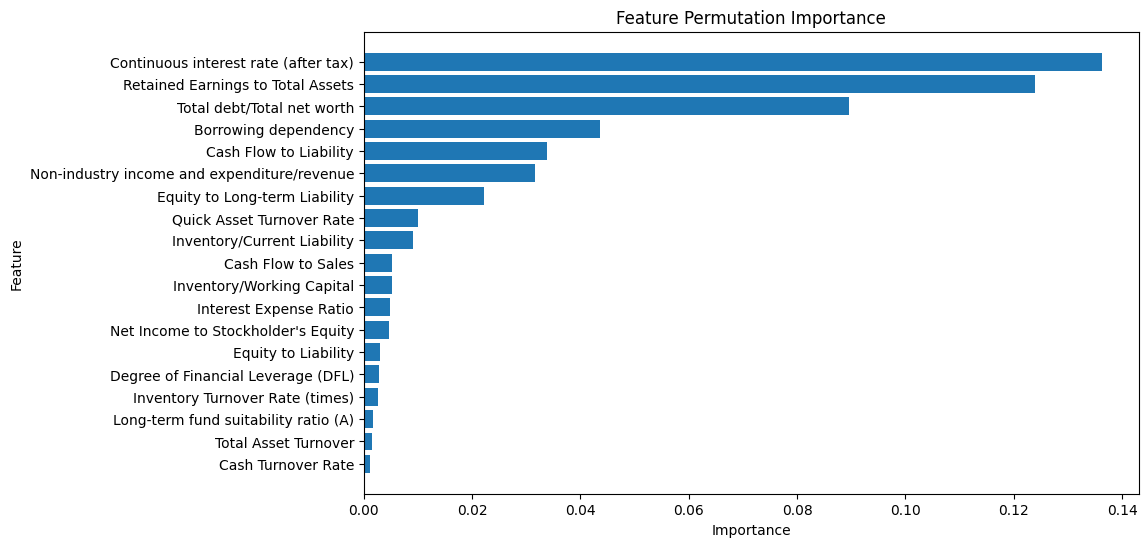

In [ ]:
plot_feat_permut_importance(dt_feat_permut_import_df)

In [ ]:
dt_perf, dt_orig_missing, dt_missing = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    taiwan_imputation_values_dict, 20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Original feat removed so far:  ['Continuous interest rate (after tax)']

--- NEW ITERATION ---
Removing feature:  Retained Earnings to Total Assets
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Retained Earnings to Total Assets']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Retained Earnings to Total Assets', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Borrowing dependency
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Retained Earnings to Total Assets', 'Total debt/Total net worth', 'Borrowing dependency']

--- NEW ITERATION ---
Removing feature:  Cash Flow to Liability
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Retained Earnings to Total Assets', 'Total debt/Total net worth', 'Borrowing dependency', 'C

In [ ]:
dt_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   34  1161  159  10      17.62   77.27        87.95     87.61     28.69   
1    4  1275   45  40       8.16    9.09        96.59     93.77      8.60   
2    4  1275   45  40       8.16    9.09        96.59     93.77      8.60   
3    4  1275   45  40       8.16    9.09        96.59     93.77      8.60   
4    4  1275   45  40       8.16    9.09        96.59     93.77      8.60   
5    4  1275   45  40       8.16    9.09        96.59     93.77      8.60   
6    0  1305   15  44       0.00    0.00        98.86     95.67      0.00   
7    0  1305   15  44       0.00    0.00        98.86     95.67      0.00   
8    0  1305   15  44       0.00    0.00        98.86     95.67      0.00   
9    0  1305   15  44       0.00    0.00        98.86     95.67      0.00   
10   0  1305   15  44       0.00    0.00        98.86     95.67      0.00   
11   0  1305   15  44       0.00    0.00        98.86     95.67      0.00   
12   0  1308   12  44       0.00    0.00        99.09     95.89      0.00   
13   0  1308   12  44       0.00    0.00        99.09     95.89      0.00   
14   0  1308   12  44       0.00    0.00        99.09     95.89      0.00   
15   0  1308   12  44       0.00    0.00        99.09     95.89      0.00   
16   0  1308   12  44       0.00    0.00        99.09     95.89      0.00   
17   0  1308   12  44       0.00    0.00        99.09     95.89      0.00   
18   0  1308   12  44       0.00    0.00        99.09     95.89      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               82.61                 0   
1               52.84                 1   
2               52.84                 2   
3               52.84                 3   
4               52.84                 4   
5               52.84                 5   
6               49.43                 6   
7               49.43                 7   
8               49.43                 8   
9               49.43                 9   
10              49.43                10   
11              49.43                11   
12              49.55                12   
13              49.55                13   
14              49.55                14   
15              49.55                15   
16              49.55                16   
17              49.55                17   
18              49.55                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1    ['Continuous interest rate (after tax)'] imputed  
2   ['Continuous interest rate (after tax)', 'Reta...  
3   ['Continuous interest rate (after tax)', 'Reta...  
4   ['Continuous interest rate (after tax)', 'Reta...  
5   ['Continuous interest rate (after tax)', 'Reta...  
6   ['Continuous interest rate (after tax)', 'Reta...  
7   ['Continuous interest rate (after tax)', 'Reta...  
8   ['Continuous interest rate (after tax)', 'Reta...  
9   ['Continuous interest rate (after tax)', 'Reta...  
10  ['Continuous interest rate (after tax)', 'Reta...  
11  ['Continuous interest rate (after tax)', 'Reta...  
12  ['Continuous interest rate (after tax)', 'Reta...  
13  ['Continuous interest rate (after tax)', 'Reta...  
14  ['Continuous interest rate (after tax)', 'Reta...  
15  ['Continuous interest rate (after tax)', 'Reta...  
16  ['Continuous interest rate (after tax)', 'Reta...  
17  ['Continuous interest rate (after tax)', 'Reta...  
18  ['Continuous interest rate (after tax)', 'Reta...  
19  ['Continuous interest rate (after tax)', 'Reta...  
20  ['Continuous interest rate (after tax)', 'Reta...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt_perf_mf, dt_orig_missing_mf, dt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 10:55:29.638502

--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Continuous interest rate (after tax)', 'Total income/Total expense', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Non-industry income and expenditure/revenue', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Operating Gross Margin', 'Interest Expense Ratio', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Total expense/Assets', 'Total Asset Return Growth Rate Ratio', 'Cash flow rate', 'Cash Flow Per Share', 'Inventory and accounts receivable/Net value', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Cash Flow to Equity', 'Working capitcal Turnover Rat

In [ ]:
dt_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   34  1161  159  10      17.62   77.27        87.95     87.61     28.69   
1   34  1152  168  10      16.83   77.27        87.27     86.95     27.64   
2   34  1147  173  10      16.43   77.27        86.89     86.58     27.09   
3   34  1137  183  10      15.67   77.27        86.14     85.85     26.05   
4   33  1125  195  11      14.47   75.00        85.23     84.90     24.26   
5   35  1124  196   9      15.15   79.55        85.15     84.97     25.45   
6   33  1139  181  11      15.42   75.00        86.29     85.92     25.58   
7   31  1165  155  13      16.67   70.45        88.26     87.68     26.96   
8   32  1155  165  12      16.24   72.73        87.50     87.02     26.56   
9   32  1154  166  12      16.16   72.73        87.42     86.95     26.45   
10  33  1154  166  11      16.58   75.00        87.42     87.02     27.16   
11  34  1155  165  10      17.09   77.27        87.50     87.17     27.98   
12  34  1157  163  10      17.26   77.27        87.65     87.32     28.22   
13  33  1164  156  11      17.46   75.00        88.18     87.76     28.33   
14  32  1181  139  12      18.71   72.73        89.47     88.93     29.77   
15  31  1176  144  13      17.71   70.45        89.09     88.49     28.31   
16  31  1186  134  13      18.79   70.45        89.85     89.22     29.67   
17  31  1187  133  13      18.90   70.45        89.92     89.30     29.81   
18  31  1181  139  13      18.24   70.45        89.47     88.86     28.97   
19  31  1187  133  13      18.90   70.45        89.92     89.30     29.81   
20  31  1189  131  13      19.14   70.45        90.08     89.44     30.10   

    balanced_accuracy  num_feat_missing  \
0               82.61                 0   
1               82.27                 1   
2               82.08                 2   
3               81.70                 3   
4               80.11                 4   
5               82.35                 5   
6               80.64                 6   
7               79.36                 7   
8               80.11                 8   
9               80.08                 9   
10              81.21                10   
11              82.39                11   
12              82.46                12   
13              81.59                13   
14              81.10                14   
15              79.77                15   
16              80.15                16   
17              80.19                17   
18              79.96                18   
19              80.19                19   
20              80.27                20   

                                              imputed  
0                                                      
1    ['Continuous interest rate (after tax)'] imputed  
2   ['Continuous interest rate (after tax)', 'Reta...  
3   ['Continuous interest rate (after tax)', 'Reta...  
4   ['Continuous interest rate (after tax)', 'Reta...  
5   ['Continuous interest rate (after tax)', 'Reta...  
6   ['Continuous interest rate (after tax)', 'Reta...  
7   ['Continuous interest rate (after tax)', 'Reta...  
8   ['Continuous interest rate (after tax)', 'Reta...  
9   ['Continuous interest rate (after tax)', 'Reta...  
10  ['Continuous interest rate (after tax)', 'Reta...  
11  ['Continuous interest rate (after tax)', 'Reta...  
12  ['Continuous interest rate (after tax)', 'Reta...  
13  ['Continuous interest rate (after tax)', 'Reta...  
14  ['Continuous interest rate (after tax)', 'Reta...  
15  ['Continuous interest rate (after tax)', 'Reta...  
16  ['Continuous interest rate (after tax)', 'Reta...  
17  ['Continuous interest rate (after tax)', 'Reta...  
18  ['Continuous interest rate (after tax)', 'Reta...  
19  ['Continuous interest rate (after tax)', 'Reta...  
20  ['Continuous interest rate (after tax)', 'Reta...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  #best model
  rf_param_grid = {
      'n_estimators': [200],
      'max_features': ['sqrt'],
      'min_samples_split': [0.01],
      'min_samples_leaf': [0.001],
      'max_depth': [None]
  }

rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf_grid_search, rf_best_model, rf_best_params = hyperparameter_tuning(
    rf_classifier, rf_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 11:00:59.610332

Nested Cross-validation Results:
Individual scores: [0.50359712 0.38848921 0.48484848]
Average nested CV score: 0.459 (+/- 0.101)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.001, 'min_samples_split': 0.01, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.459
2025-01-16 11:01:12.241708

Execution time: 0.21 minutes




```
Starting hyperparameter tuning at: 2025-01-15 21:46:27.611095

Nested Cross-validation Results:
Individual scores: [0.41666667 0.39153439 0.42162162]
Average nested CV score: 0.410 (+/- 0.026)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.001, 'min_samples_split': 0.01, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.459

Train score: 0.770
Test score: 0.459
Train-test score difference: 0.311
2025-01-15 22:55:29.068191

Execution time: 69.02 minutes
```



In [ ]:
# rf_grid_search.cv_results_

In [ ]:
rf_classifier, rf_train_pred, rf_test_pred = apply_model(rf_best_model, X_train, y_train, X_test, y_test)
rf_feat_permut_import_df = analyze_feat_permut_import(rf_classifier, X_train, y_train, scoring_metric="f1")
rf_feat_permut_import_df[rf_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
60          Accounts Receivable Turnover    0.014713  0.001275
61               Average Collection Days    0.012474  0.001603
36       Fixed Assets Turnover Frequency    0.011090  0.001534
35                  Total Asset Turnover    0.009002  0.001716
16                Operating Gross Margin    0.008651  0.001454
..                                   ...         ...       ...
51            Total debt/Total net worth   -0.042997  0.006975
6             Total income/Total expense   -0.056320  0.007805
2      Retained Earnings to Total Assets   -0.058994  0.007719
13                   Equity to Liability   -0.059890  0.006553
5   Continuous interest rate (after tax)   -0.080107  0.012915

[62 rows x 3 columns]

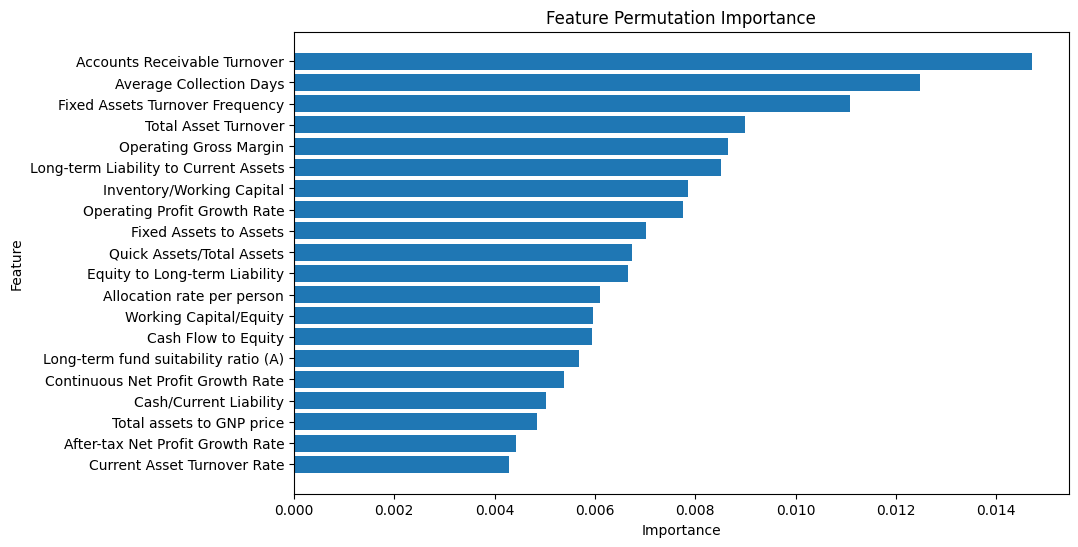

In [ ]:
plot_feat_permut_importance(rf_feat_permut_import_df)

In [ ]:
rf_perf, rf_orig_missing, rf_missing = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Accounts Receivable Turnover
Original feat removed so far:  ['Accounts Receivable Turnover']

--- NEW ITERATION ---
Removing feature:  Average Collection Days
Original feat removed so far:  ['Accounts Receivable Turnover', 'Average Collection Days']

--- NEW ITERATION ---
Removing feature:  Fixed Assets Turnover Frequency
Original feat removed so far:  ['Accounts Receivable Turnover', 'Average Collection Days', 'Fixed Assets Turnover Frequency']

--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Original feat removed so far:  ['Accounts Receivable Turnover', 'Average Collection Days', 'Fixed Assets Turnover Frequency', 'Total Asset Turnover']

--- NEW ITERATION ---
Removing feature:  Operating Gross Margin
Original feat removed so far:  ['Accounts Receivable Turnover', 'Average Collection Days', 'Fixed Assets Turnover Frequency', 'Total Asset Turnover', 'Operating Gross Margin']

--- NEW ITERATION ---
Removing feature:  Long-term Li

In [ ]:
rf_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   28  1277  43  16      39.44   63.64        96.74     95.67     48.70   
1   28  1278  42  16      40.00   63.64        96.82     95.75     49.12   
2   28  1279  41  16      40.58   63.64        96.89     95.82     49.56   
3   28  1278  42  16      40.00   63.64        96.82     95.75     49.12   
4   28  1278  42  16      40.00   63.64        96.82     95.75     49.12   
5   28  1278  42  16      40.00   63.64        96.82     95.75     49.12   
6   28  1277  43  16      39.44   63.64        96.74     95.67     48.70   
7   28  1276  44  16      38.89   63.64        96.67     95.60     48.28   
8   28  1274  46  16      37.84   63.64        96.52     95.45     47.46   
9   28  1276  44  16      38.89   63.64        96.67     95.60     48.28   
10  28  1275  45  16      38.36   63.64        96.59     95.53     47.86   
11  28  1276  44  16      38.89   63.64        96.67     95.60     48.28   
12  28  1276  44  16      38.89   63.64        96.67     95.60     48.28   
13  28  1277  43  16      39.44   63.64        96.74     95.67     48.70   
14  27  1278  42  17      39.13   61.36        96.82     95.67     47.79   
15  27  1276  44  17      38.03   61.36        96.67     95.53     46.96   
16  27  1275  45  17      37.50   61.36        96.59     95.45     46.55   
17  26  1278  42  18      38.24   59.09        96.82     95.60     46.43   
18  26  1278  42  18      38.24   59.09        96.82     95.60     46.43   
19  26  1278  42  18      38.24   59.09        96.82     95.60     46.43   
20  26  1278  42  18      38.24   59.09        96.82     95.60     46.43   

    balanced_accuracy  num_feat_missing  \
0               80.19                 0   
1               80.23                 1   
2               80.27                 2   
3               80.23                 3   
4               80.23                 4   
5               80.23                 5   
6               80.19                 6   
7               80.15                 7   
8               80.08                 8   
9               80.15                 9   
10              80.11                10   
11              80.15                11   
12              80.15                12   
13              80.19                13   
14              79.09                14   
15              79.02                15   
16              78.98                16   
17              77.95                17   
18              77.95                18   
19              77.95                19   
20              77.95                20   

                                              imputed  
0                                                      
1            ['Accounts Receivable Turnover'] imputed  
2   ['Accounts Receivable Turnover', 'Average Coll...  
3   ['Accounts Receivable Turnover', 'Average Coll...  
4   ['Accounts Receivable Turnover', 'Average Coll...  
5   ['Accounts Receivable Turnover', 'Average Coll...  
6   ['Accounts Receivable Turnover', 'Average Coll...  
7   ['Accounts Receivable Turnover', 'Average Coll...  
8   ['Accounts Receivable Turnover', 'Average Coll...  
9   ['Accounts Receivable Turnover', 'Average Coll...  
10  ['Accounts Receivable Turnover', 'Average Coll...  
11  ['Accounts Receivable Turnover', 'Average Coll...  
12  ['Accounts Receivable Turnover', 'Average Coll...  
13  ['Accounts Receivable Turnover', 'Average Coll...  
14  ['Accounts Receivable Turnover', 'Average Coll...  
15  ['Accounts Receivable Turnover', 'Average Coll...  
16  ['Accounts Receivable Turnover', 'Average Coll...  
17  ['Accounts Receivable Turnover', 'Average Coll...  
18  ['Accounts Receivable Turnover', 'Average Coll...  
19  ['Accounts Receivable Turnover', 'Average Coll...  
20  ['Accounts Receivable Turnover', 'Average Coll...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf_perf_mf, rf_orig_missing_mf, rf_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 11:01:19.970562

--- NEW ITERATION ---
Removing feature:  Accounts Receivable Turnover
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Continuous interest rate (after tax)', 'Total income/Total expense', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Non-industry income and expenditure/revenue', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Operating Gross Margin', 'Interest Expense Ratio', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Total expense/Assets', 'Total Asset Return Growth Rate Ratio', 'Cash flow rate', 'Cash Flow Per Share', 'Inventory and accounts receivable/Net value', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Cash Flow to Equity', 'Working capitcal Turnover Rate', 'Cas

In [ ]:
rf_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   28  1277  43  16      39.44   63.64        96.74     95.67     48.70   
1   28  1281  39  16      41.79   63.64        97.05     95.97     50.45   
2   28  1280  40  16      41.18   63.64        96.97     95.89     50.00   
3   28  1279  41  16      40.58   63.64        96.89     95.82     49.56   
4   28  1278  42  16      40.00   63.64        96.82     95.75     49.12   
5   28  1277  43  16      39.44   63.64        96.74     95.67     48.70   
6   28  1277  43  16      39.44   63.64        96.74     95.67     48.70   
7   27  1277  43  17      38.57   61.36        96.74     95.60     47.37   
8   27  1278  42  17      39.13   61.36        96.82     95.67     47.79   
9   27  1278  42  17      39.13   61.36        96.82     95.67     47.79   
10  27  1277  43  17      38.57   61.36        96.74     95.60     47.37   
11  28  1277  43  16      39.44   63.64        96.74     95.67     48.70   
12  28  1276  44  16      38.89   63.64        96.67     95.60     48.28   
13  28  1274  46  16      37.84   63.64        96.52     95.45     47.46   
14  28  1274  46  16      37.84   63.64        96.52     95.45     47.46   
15  28  1275  45  16      38.36   63.64        96.59     95.53     47.86   
16  28  1275  45  16      38.36   63.64        96.59     95.53     47.86   
17  28  1277  43  16      39.44   63.64        96.74     95.67     48.70   
18  28  1276  44  16      38.89   63.64        96.67     95.60     48.28   
19  28  1275  45  16      38.36   63.64        96.59     95.53     47.86   
20  29  1276  44  15      39.73   65.91        96.67     95.67     49.57   

    balanced_accuracy  num_feat_missing  \
0               80.19                 0   
1               80.34                 1   
2               80.30                 2   
3               80.27                 3   
4               80.23                 4   
5               80.19                 5   
6               80.19                 6   
7               79.05                 7   
8               79.09                 8   
9               79.09                 9   
10              79.05                10   
11              80.19                11   
12              80.15                12   
13              80.08                13   
14              80.08                14   
15              80.11                15   
16              80.11                16   
17              80.19                17   
18              80.15                18   
19              80.11                19   
20              81.29                20   

                                              imputed  
0                                                      
1            ['Accounts Receivable Turnover'] imputed  
2   ['Accounts Receivable Turnover', 'Average Coll...  
3   ['Accounts Receivable Turnover', 'Average Coll...  
4   ['Accounts Receivable Turnover', 'Average Coll...  
5   ['Accounts Receivable Turnover', 'Average Coll...  
6   ['Accounts Receivable Turnover', 'Average Coll...  
7   ['Accounts Receivable Turnover', 'Average Coll...  
8   ['Accounts Receivable Turnover', 'Average Coll...  
9   ['Accounts Receivable Turnover', 'Average Coll...  
10  ['Accounts Receivable Turnover', 'Average Coll...  
11  ['Accounts Receivable Turnover', 'Average Coll...  
12  ['Accounts Receivable Turnover', 'Average Coll...  
13  ['Accounts Receivable Turnover', 'Average Coll...  
14  ['Accounts Receivable Turnover', 'Average Coll...  
15  ['Accounts Receivable Turnover', 'Average Coll...  
16  ['Accounts Receivable Turnover', 'Average Coll...  
17  ['Accounts Receivable Turnover', 'Average Coll...  
18  ['Accounts Receivable Turnover', 'Average Coll...  
19  ['Accounts Receivable Turnover', 'Average Coll...  
20  ['Accounts Receivable Turnover', 'Average Coll...

##**Gradient-Boosted Trees**

Instead of class_weight='balanced', GBT and XGBoost recommends the use of scale_pos_weight = # majority class samples / # minority class samples

- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
# scale_pos_weight value
ratio_majority_minority = y_train[y_train==0].count()/y_train[y_train==1].count()
ratio_majority_minority

29.994318181818183

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [25, 15, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt_param_grid = {
      'n_estimators': [200],
      'max_depth': [5],
      'min_child_samples': [1],
      'min_split_gain': [1.0],
      'reg_lambda': [10.0]
  }

gbt_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt_grid_search, gbt_best_model, gbt_best_params = hyperparameter_tuning(
    gbt_classifier, gbt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 11:06:55.434038

Nested Cross-validation Results:
Individual scores: [0.512      0.44094488 0.53846154]
Average nested CV score: 0.497 (+/- 0.082)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 5, 'min_child_samples': 1, 'min_split_gain': 1.0, 'n_estimators': 200, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.497
2025-01-16 11:06:59.799359

Execution time: 0.07 minutes



```
Starting hyperparameter tuning at: 2025-01-13 02:30:42.108451

Nested Cross-validation Results:
Individual scores: [0.49275362 0.44927536 0.44594595]
Average nested CV score: 0.463 (+/- 0.043)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 4, 'min_child_samples': 1, 'min_split_gain': 0.0, 'n_estimators': 200, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.489

Train score: 0.999
Test score: 0.489
Train-test score difference: 0.510
2025-01-13 02:38:19.417749

Execution time: 7.62 minutes
---
WITH SCALE_POS_WEIGHT
Starting hyperparameter tuning at: 2025-01-15 13:50:18.165302

Nested Cross-validation Results:
Individual scores: [0.48543689 0.41322314 0.44137931]
Average nested CV score: 0.447 (+/- 0.059)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 5, 'min_child_samples': 1, 'min_split_gain': 1, 'n_estimators': 200, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.497

Train score: 0.946
Test score: 0.497
Train-test score difference: 0.449
2025-01-15 13:58:10.296729

Execution time: 7.87 minutes
```



In [ ]:
gbt_classifier, gbt_train_pred, gbt_test_pred = apply_model(gbt_best_model, X_train, y_train, X_test, y_test)
gbt_feat_permut_import_df = analyze_feat_permut_import(gbt_classifier, X_train, y_train, scoring_metric="f1")
gbt_feat_permut_import_df[gbt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
53    Interest-bearing debt interest rate    0.069196  0.016069
43                     Revenue per person    0.052797  0.012492
28                 Cash/Current Liability    0.037345  0.003912
47  Research and development expense rate    0.021649  0.002568
61                Average Collection Days    0.021166  0.004299
..                                    ...         ...       ...
0      Net Income to Stockholder's Equity   -0.019622  0.001026
49                            Quick Ratio   -0.023315  0.009009
2       Retained Earnings to Total Assets   -0.025833  0.006472
5    Continuous interest rate (after tax)   -0.028918  0.002739
1                    Borrowing dependency   -0.034241  0.003975

[62 rows x 3 columns]

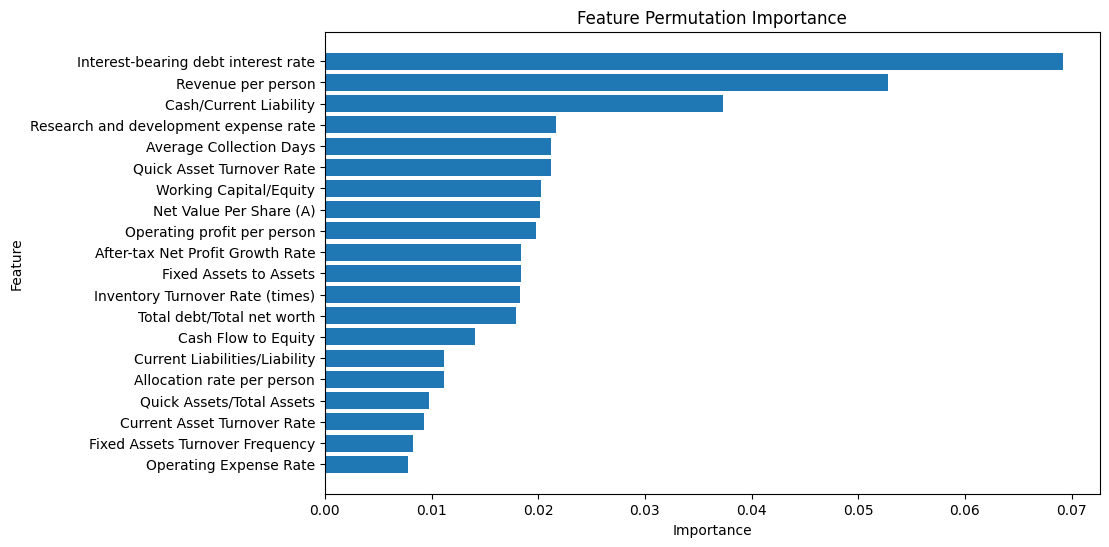

In [ ]:
plot_feat_permut_importance(gbt_feat_permut_import_df)

In [ ]:
gbt_perf, gbt_orig_missing, gbt_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Interest-bearing debt interest rate']

--- NEW ITERATION ---
Removing feature:  Revenue per person
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person']

--- NEW ITERATION ---
Removing feature:  Cash/Current Liability
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person', 'Cash/Current Liability']

--- NEW ITERATION ---
Removing feature:  Research and development expense rate
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person', 'Cash/Current Liability', 'Research and development expense rate']

--- NEW ITERATION ---
Removing feature:  Average Collection Days
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person', 'Cash/Current Liability', 'Research and development expense rate', 'Average Collection Days']

--- NEW ITERATION -

In [ ]:
gbt_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   22  1301  19  22      53.66   50.00        98.56     96.99     51.76   
1   15  1310  10  29      60.00   34.09        99.24     97.14     43.48   
2   14  1306  14  30      50.00   31.82        98.94     96.77     38.89   
3   16  1304  16  28      50.00   36.36        98.79     96.77     42.11   
4   17  1302  18  27      48.57   38.64        98.64     96.70     43.04   
5   16  1304  16  28      50.00   36.36        98.79     96.77     42.11   
6   16  1303  17  28      48.48   36.36        98.71     96.70     41.56   
7   16  1303  17  28      48.48   36.36        98.71     96.70     41.56   
8   16  1305  15  28      51.61   36.36        98.86     96.85     42.67   
9   16  1304  16  28      50.00   36.36        98.79     96.77     42.11   
10  16  1305  15  28      51.61   36.36        98.86     96.85     42.67   
11  15  1306  14  29      51.72   34.09        98.94     96.85     41.10   
12  14  1312   8  30      63.64   31.82        99.39     97.21     42.42   
13   9  1315   5  35      64.29   20.45        99.62     97.07     31.03   
14   7  1318   2  37      77.78   15.91        99.85     97.14     26.42   
15   7  1317   3  37      70.00   15.91        99.77     97.07     25.93   
16   7  1318   2  37      77.78   15.91        99.85     97.14     26.42   
17   8  1317   3  36      72.73   18.18        99.77     97.14     29.09   
18  10  1317   3  34      76.92   22.73        99.77     97.29     35.09   
19  10  1316   4  34      71.43   22.73        99.70     97.21     34.48   
20  10  1314   6  34      62.50   22.73        99.55     97.07     33.33   

    balanced_accuracy  num_feat_missing  \
0               74.28                 0   
1               66.67                 1   
2               65.38                 2   
3               67.58                 3   
4               68.64                 4   
5               67.58                 5   
6               67.54                 6   
7               67.54                 7   
8               67.61                 8   
9               67.58                 9   
10              67.61                10   
11              66.52                11   
12              65.61                12   
13              60.04                13   
14              57.88                14   
15              57.84                15   
16              57.88                16   
17              58.98                17   
18              61.25                18   
19              61.21                19   
20              61.14                20   

                                              imputed  
0                                                      
1     ['Interest-bearing debt interest rate'] imputed  
2   ['Interest-bearing debt interest rate', 'Reven...  
3   ['Interest-bearing debt interest rate', 'Reven...  
4   ['Interest-bearing debt interest rate', 'Reven...  
5   ['Interest-bearing debt interest rate', 'Reven...  
6   ['Interest-bearing debt interest rate', 'Reven...  
7   ['Interest-bearing debt interest rate', 'Reven...  
8   ['Interest-bearing debt interest rate', 'Reven...  
9   ['Interest-bearing debt interest rate', 'Reven...  
10  ['Interest-bearing debt interest rate', 'Reven...  
11  ['Interest-bearing debt interest rate', 'Reven...  
12  ['Interest-bearing debt interest rate', 'Reven...  
13  ['Interest-bearing debt interest rate', 'Reven...  
14  ['Interest-bearing debt interest rate', 'Reven...  
15  ['Interest-bearing debt interest rate', 'Reven...  
16  ['Interest-bearing debt interest rate', 'Reven...  
17  ['Interest-bearing debt interest rate', 'Reven...  
18  ['Interest-bearing debt interest rate', 'Reven...  
19  ['Interest-bearing debt interest rate', 'Reven...  
20  ['Interest-bearing debt interest rate', 'Reven...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt_perf_mf, gbt_orig_missing_mf, gbt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 11:07:04.135737

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Continuous interest rate (after tax)', 'Total income/Total expense', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Non-industry income and expenditure/revenue', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Operating Gross Margin', 'Interest Expense Ratio', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Total expense/Assets', 'Total Asset Return Growth Rate Ratio', 'Cash flow rate', 'Cash Flow Per Share', 'Inventory and accounts receivable/Net value', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Cash Flow to Equity', 'Working capitcal Turnover Rate

In [ ]:
gbt_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   22  1301  19  22      53.66   50.00        98.56     96.99     51.76   
1   27  1289  31  17      46.55   61.36        97.65     96.48     52.94   
2   29  1284  36  15      44.62   65.91        97.27     96.26     53.21   
3   31  1273  47  13      39.74   70.45        96.44     95.60     50.82   
4   30  1270  50  14      37.50   68.18        96.21     95.31     48.39   
5   30  1272  48  14      38.46   68.18        96.36     95.45     49.18   
6   30  1266  54  14      35.71   68.18        95.91     95.01     46.88   
7   30  1267  53  14      36.14   68.18        95.98     95.09     47.24   
8   30  1271  49  14      37.97   68.18        96.29     95.38     48.78   
9   30  1270  50  14      37.50   68.18        96.21     95.31     48.39   
10  31  1273  47  13      39.74   70.45        96.44     95.60     50.82   
11  30  1267  53  14      36.14   68.18        95.98     95.09     47.24   
12  31  1266  54  13      36.47   70.45        95.91     95.09     48.06   
13  30  1269  51  14      37.04   68.18        96.14     95.23     48.00   
14  29  1267  53  15      35.37   65.91        95.98     95.01     46.03   
15  30  1265  55  14      35.29   68.18        95.83     94.94     46.51   
16  31  1267  53  13      36.90   70.45        95.98     95.16     48.44   
17  29  1272  48  15      37.66   65.91        96.36     95.38     47.93   
18  30  1266  54  14      35.71   68.18        95.91     95.01     46.88   
19  30  1254  66  14      31.25   68.18        95.00     94.13     42.86   
20  32  1252  68  12      32.00   72.73        94.85     94.13     44.44   

    balanced_accuracy  num_feat_missing  \
0               74.28                 0   
1               79.51                 1   
2               81.59                 2   
3               83.45                 3   
4               82.20                 4   
5               82.27                 5   
6               82.05                 6   
7               82.08                 7   
8               82.23                 8   
9               82.20                 9   
10              83.45                10   
11              82.08                11   
12              83.18                12   
13              82.16                13   
14              80.95                14   
15              82.01                15   
16              83.22                16   
17              81.14                17   
18              82.05                18   
19              81.59                19   
20              83.79                20   

                                              imputed  
0                                                      
1     ['Interest-bearing debt interest rate'] imputed  
2   ['Interest-bearing debt interest rate', 'Reven...  
3   ['Interest-bearing debt interest rate', 'Reven...  
4   ['Interest-bearing debt interest rate', 'Reven...  
5   ['Interest-bearing debt interest rate', 'Reven...  
6   ['Interest-bearing debt interest rate', 'Reven...  
7   ['Interest-bearing debt interest rate', 'Reven...  
8   ['Interest-bearing debt interest rate', 'Reven...  
9   ['Interest-bearing debt interest rate', 'Reven...  
10  ['Interest-bearing debt interest rate', 'Reven...  
11  ['Interest-bearing debt interest rate', 'Reven...  
12  ['Interest-bearing debt interest rate', 'Reven...  
13  ['Interest-bearing debt interest rate', 'Reven...  
14  ['Interest-bearing debt interest rate', 'Reven...  
15  ['Interest-bearing debt interest rate', 'Reven...  
16  ['Interest-bearing debt interest rate', 'Reven...  
17  ['Interest-bearing debt interest rate', 'Reven...  
18  ['Interest-bearing debt interest rate', 'Reven...  
19  ['Interest-bearing debt interest rate', 'Reven...  
20  ['Interest-bearing debt interest rate', 'Reven...

## **XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10, 5, 1, 0.5, 0],          # L2 regularization on weights
      'gamma': [1, 0.5, 0.1, 0.05, 0.0],         # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  xgb_param_grid = {
      'n_estimators': [100],
      'max_depth': [None],
      'reg_lambda':[0.5],
      'gamma': [0.05],
      'colsample_bytree':[0.75]
  }

xgb_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE
)
xgb_grid_search, xgb_best_model, xgb_best_params = hyperparameter_tuning(
    xgb_classifier, xgb_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 11:12:43.372037

Nested Cross-validation Results:
Individual scores: [0.47916667 0.50505051 0.5046729 ]
Average nested CV score: 0.496 (+/- 0.024)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 0.75, 'gamma': 0.05, 'max_depth': None, 'n_estimators': 100, 'reg_lambda': 0.5}

Best Model Performance:
Best CV score: 0.496
2025-01-16 11:12:47.373082

Execution time: 0.07 minutes


```
Starting hyperparameter tuning at: 2025-01-13 01:49:33.193290

Nested Cross-validation Results:
Individual scores: [0.275      0.39506173 0.44186047]
Average nested CV score: 0.371 (+/- 0.141)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 0}

Best Model Performance:
Best CV score: 0.448

Train score: 0.968
Test score: 0.448
Train-test score difference: 0.520
2025-01-13 02:09:56.878399

Execution time: 20.39 minutes
---
Starting hyperparameter tuning at: 2025-01-15 13:58:12.353795

Nested Cross-validation Results:
Individual scores: [0.47169811 0.45086705 0.45454545]
Average nested CV score: 0.459 (+/- 0.018)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 0.75, 'gamma': 0.05, 'max_depth': None, 'n_estimators': 100, 'reg_lambda': 0.5}

Best Model Performance:
Best CV score: 0.496

Train score: 1.000
Test score: 0.496
Train-test score difference: 0.504
2025-01-15 14:19:06.707061

Execution time: 20.91 minutes
```



In [ ]:
xgb_classifier, xgb_train_pred, xgb_test_pred = apply_model(xgb_best_model, X_train, y_train, X_test, y_test)
xgb_feat_permut_import_df = analyze_feat_permut_import(xgb_classifier, X_train, y_train, scoring_metric="f1")
xgb_feat_permut_import_df[xgb_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
53  Interest-bearing debt interest rate    0.022950  0.005511
43                   Revenue per person    0.009005  0.002089
40                Net Value Growth Rate    0.002279  0.001140
2     Retained Earnings to Total Assets    0.001140  0.001396
51           Total debt/Total net worth    0.000567  0.001133
61              Average Collection Days    0.000567  0.001133
49                          Quick Ratio    0.000567  0.001133

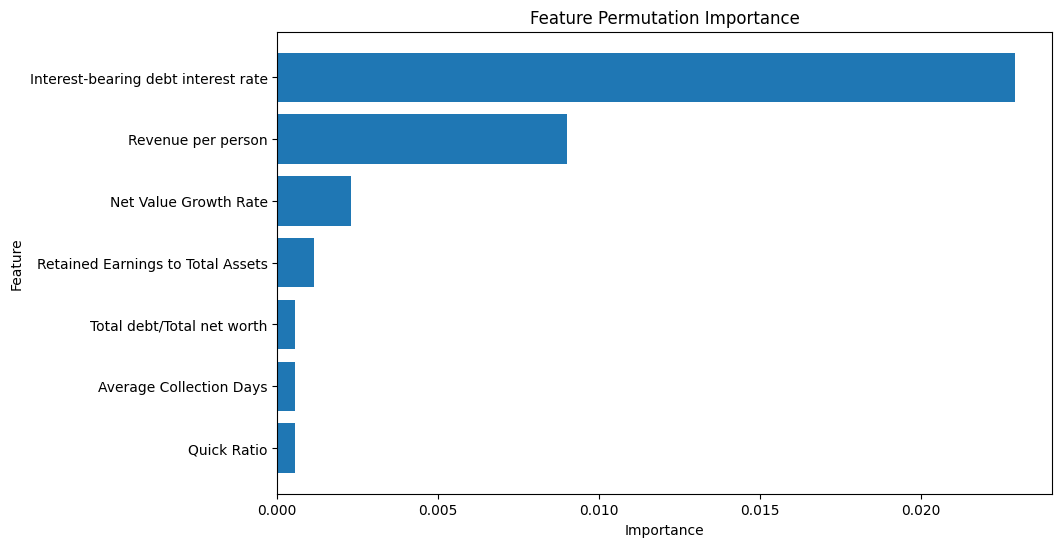

In [ ]:
plot_feat_permut_importance(xgb_feat_permut_import_df)

In [ ]:
xgb_perf, xgb_orig_missing, xgb_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Interest-bearing debt interest rate']

--- NEW ITERATION ---
Removing feature:  Revenue per person
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person']

--- NEW ITERATION ---
Removing feature:  Net Value Growth Rate
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person', 'Net Value Growth Rate']

--- NEW ITERATION ---
Removing feature:  Retained Earnings to Total Assets
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person', 'Net Value Growth Rate', 'Retained Earnings to Total Assets']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person', 'Net Value Growth Rate', 'Retained Earnings to Total Assets', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removin

In [ ]:
xgb_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   19  1314   6  25      76.00   43.18        99.55     97.73     55.07   
1   11  1316   4  33      73.33   25.00        99.70     97.29     37.29   
2   11  1313   7  33      61.11   25.00        99.47     97.07     35.48   
3    7  1317   3  37      70.00   15.91        99.77     97.07     25.93   
4    2  1320   0  42     100.00    4.55       100.00     96.92      8.70   
5    2  1320   0  42     100.00    4.55       100.00     96.92      8.70   
6    0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
7    0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
8    0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               71.36                 0   
1               62.35                 1   
2               62.23                 2   
3               57.84                 3   
4               52.27                 4   
5               52.27                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1     ['Interest-bearing debt interest rate'] imputed  
2   ['Interest-bearing debt interest rate', 'Reven...  
3   ['Interest-bearing debt interest rate', 'Reven...  
4   ['Interest-bearing debt interest rate', 'Reven...  
5   ['Interest-bearing debt interest rate', 'Reven...  
6   ['Interest-bearing debt interest rate', 'Reven...  
7   ['Interest-bearing debt interest rate', 'Reven...  
8   ['Interest-bearing debt interest rate', 'Reven...  
9   ['Interest-bearing debt interest rate', 'Reven...  
10  ['Interest-bearing debt interest rate', 'Reven...  
11  ['Interest-bearing debt interest rate', 'Reven...  
12  ['Interest-bearing debt interest rate', 'Reven...  
13  ['Interest-bearing debt interest rate', 'Reven...  
14  ['Interest-bearing debt interest rate', 'Reven...  
15  ['Interest-bearing debt interest rate', 'Reven...  
16  ['Interest-bearing debt interest rate', 'Reven...  
17  ['Interest-bearing debt interest rate', 'Reven...  
18  ['Interest-bearing debt interest rate', 'Reven...  
19  ['Interest-bearing debt interest rate', 'Reven...  
20  ['Interest-bearing debt interest rate', 'Reven...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb_perf_mf, xgb_orig_missing_mf, xgb_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 11:12:50.707387

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Continuous interest rate (after tax)', 'Total income/Total expense', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Non-industry income and expenditure/revenue', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Operating Gross Margin', 'Interest Expense Ratio', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Total expense/Assets', 'Total Asset Return Growth Rate Ratio', 'Cash flow rate', 'Cash Flow Per Share', 'Inventory and accounts receivable/Net value', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Cash Flow to Equity', 'Working capitcal Turnover Rate

In [ ]:
xgb_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   19  1314   6  25      76.00   43.18        99.55     97.73     55.07   
1   19  1308  12  25      61.29   43.18        99.09     97.29     50.67   
2   18  1302  18  26      50.00   40.91        98.64     96.77     45.00   
3   14  1309  11  30      56.00   31.82        99.17     96.99     40.58   
4   14  1309  11  30      56.00   31.82        99.17     96.99     40.58   
5   14  1310  10  30      58.33   31.82        99.24     97.07     41.18   
6   14  1309  11  30      56.00   31.82        99.17     96.99     40.58   
7    3  1318   2  41      60.00    6.82        99.85     96.85     12.24   
8    3  1316   4  41      42.86    6.82        99.70     96.70     11.76   
9    3  1315   5  41      37.50    6.82        99.62     96.63     11.54   
10   4  1317   3  40      57.14    9.09        99.77     96.85     15.69   
11   4  1317   3  40      57.14    9.09        99.77     96.85     15.69   
12   5  1317   3  39      62.50   11.36        99.77     96.92     19.23   
13   5  1316   4  39      55.56   11.36        99.70     96.85     18.87   
14   3  1316   4  41      42.86    6.82        99.70     96.70     11.76   
15   3  1316   4  41      42.86    6.82        99.70     96.70     11.76   
16   1  1318   2  43      33.33    2.27        99.85     96.70      4.26   
17   1  1318   2  43      33.33    2.27        99.85     96.70      4.26   
18   3  1317   3  41      50.00    6.82        99.77     96.77     12.00   
19   3  1317   3  41      50.00    6.82        99.77     96.77     12.00   
20   4  1316   4  40      50.00    9.09        99.70     96.77     15.38   

    balanced_accuracy  num_feat_missing  \
0               71.36                 0   
1               71.14                 1   
2               69.77                 2   
3               65.49                 3   
4               65.49                 4   
5               65.53                 5   
6               65.49                 6   
7               53.33                 7   
8               53.26                 8   
9               53.22                 9   
10              54.43                10   
11              54.43                11   
12              55.57                12   
13              55.53                13   
14              53.26                14   
15              53.26                15   
16              51.06                16   
17              51.06                17   
18              53.30                18   
19              53.30                19   
20              54.39                20   

                                              imputed  
0                                                      
1     ['Interest-bearing debt interest rate'] imputed  
2   ['Interest-bearing debt interest rate', 'Reven...  
3   ['Interest-bearing debt interest rate', 'Reven...  
4   ['Interest-bearing debt interest rate', 'Reven...  
5   ['Interest-bearing debt interest rate', 'Reven...  
6   ['Interest-bearing debt interest rate', 'Reven...  
7   ['Interest-bearing debt interest rate', 'Reven...  
8   ['Interest-bearing debt interest rate', 'Reven...  
9   ['Interest-bearing debt interest rate', 'Reven...  
10  ['Interest-bearing debt interest rate', 'Reven...  
11  ['Interest-bearing debt interest rate', 'Reven...  
12  ['Interest-bearing debt interest rate', 'Reven...  
13  ['Interest-bearing debt interest rate', 'Reven...  
14  ['Interest-bearing debt interest rate', 'Reven...  
15  ['Interest-bearing debt interest rate', 'Reven...  
16  ['Interest-bearing debt interest rate', 'Reven...  
17  ['Interest-bearing debt interest rate', 'Reven...  
18  ['Interest-bearing debt interest rate', 'Reven...  
19  ['Interest-bearing debt interest rate', 'Reven...  
20  ['Interest-bearing debt interest rate', 'Reven...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et_param_grid = {
      'n_estimators': [100],
      'max_depth': [None],
      'max_features':[1.0],
      'min_samples_split': [0.005],
      'min_samples_leaf': [0.001]
  }

et_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et_grid_search, et_best_model, et_best_params = hyperparameter_tuning(
    et_classifier, et_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 11:18:18.111634

Nested Cross-validation Results:
Individual scores: [0.48484848 0.43971631 0.48780488]
Average nested CV score: 0.471 (+/- 0.044)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.471
2025-01-16 11:18:24.198406

Execution time: 0.10 minutes




```
Starting hyperparameter tuning at: 2025-01-15 14:19:06.716494

Nested Cross-validation Results:
Individual scores: [0.475      0.3908046  0.41818182]
Average nested CV score: 0.428 (+/- 0.070)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.471

Train score: 0.821
Test score: 0.471
Train-test score difference: 0.350
2025-01-15 14:40:40.267118

Execution time: 21.56 minutes
```



In [ ]:
# et_grid_search.cv_results_

In [ ]:
et_classifier, train_pred, test_pred = apply_model(et_best_model, X_train, y_train, X_test, y_test)
et_feat_permut_import_df = analyze_feat_permut_import(et_classifier, X_train, y_train, scoring_metric="f1")
et_feat_permut_import_df[et_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
35               Total Asset Turnover    0.004650  0.001738
56    Inventory Turnover Rate (times)    0.004136  0.001708
34   Contingent liabilities/Net worth    0.003882  0.000814
46                 Cash Turnover Rate    0.003365  0.001315
27     Working capitcal Turnover Rate    0.003109  0.000632
..                                ...         ...       ...
1                Borrowing dependency   -0.047274  0.005686
2   Retained Earnings to Total Assets   -0.059519  0.004928
14                       Tax rate (A)   -0.085403  0.007770
6          Total income/Total expense   -0.085678  0.005266
13                Equity to Liability   -0.092020  0.005423

[63 rows x 3 columns]

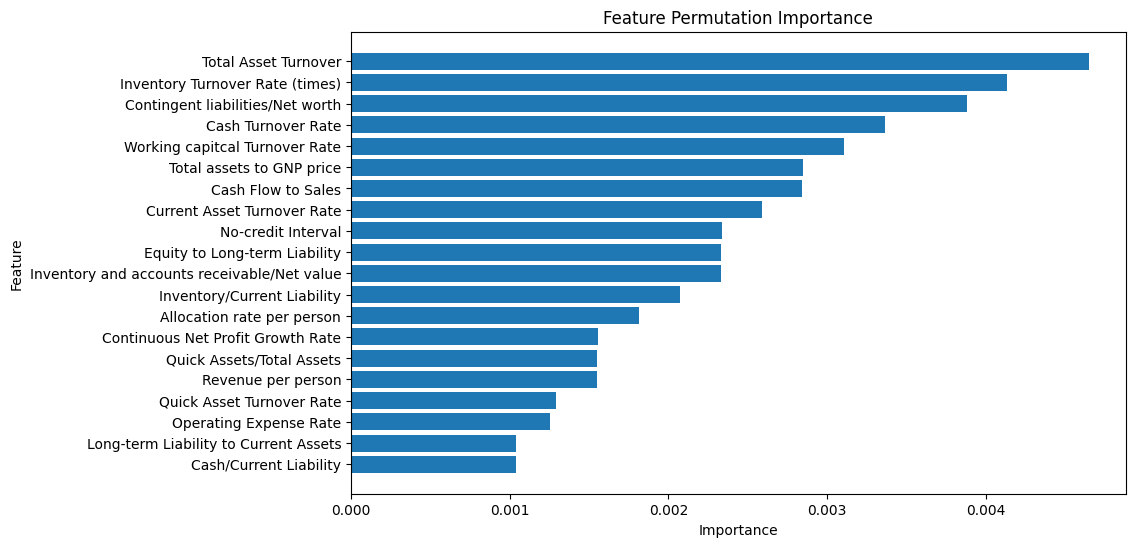

In [ ]:
plot_feat_permut_importance(et_feat_permut_import_df)

In [ ]:
et_perf, et_orig_missing, et_missing = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Original feat removed so far:  ['Total Asset Turnover']

--- NEW ITERATION ---
Removing feature:  Inventory Turnover Rate (times)
Original feat removed so far:  ['Total Asset Turnover', 'Inventory Turnover Rate (times)']

--- NEW ITERATION ---
Removing feature:  Contingent liabilities/Net worth
Original feat removed so far:  ['Total Asset Turnover', 'Inventory Turnover Rate (times)', 'Contingent liabilities/Net worth']

--- NEW ITERATION ---
Removing feature:  Cash Turnover Rate
Original feat removed so far:  ['Total Asset Turnover', 'Inventory Turnover Rate (times)', 'Contingent liabilities/Net worth', 'Cash Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Working capitcal Turnover Rate
Original feat removed so far:  ['Total Asset Turnover', 'Inventory Turnover Rate (times)', 'Contingent liabilities/Net worth', 'Cash Turnover Rate', 'Working capitcal Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Total 

In [ ]:
et_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   25  1282  38  19      39.68   56.82        97.12     95.82     46.73   
1   26  1281  39  18      40.00   59.09        97.05     95.82     47.71   
2   26  1280  40  18      39.39   59.09        96.97     95.75     47.27   
3   26  1280  40  18      39.39   59.09        96.97     95.75     47.27   
4   26  1279  41  18      38.81   59.09        96.89     95.67     46.85   
5   26  1280  40  18      39.39   59.09        96.97     95.75     47.27   
6   26  1279  41  18      38.81   59.09        96.89     95.67     46.85   
7   27  1280  40  17      40.30   61.36        96.97     95.82     48.65   
8   27  1279  41  17      39.71   61.36        96.89     95.75     48.21   
9   27  1280  40  17      40.30   61.36        96.97     95.82     48.65   
10  27  1280  40  17      40.30   61.36        96.97     95.82     48.65   
11  28  1284  36  16      43.75   63.64        97.27     96.19     51.85   
12  28  1282  38  16      42.42   63.64        97.12     96.04     50.91   
13  27  1282  38  17      41.54   61.36        97.12     95.97     49.54   
14  27  1281  39  17      40.91   61.36        97.05     95.89     49.09   
15  26  1283  37  18      41.27   59.09        97.20     95.97     48.60   
16  26  1283  37  18      41.27   59.09        97.20     95.97     48.60   
17  26  1283  37  18      41.27   59.09        97.20     95.97     48.60   
18  26  1283  37  18      41.27   59.09        97.20     95.97     48.60   
19  26  1283  37  18      41.27   59.09        97.20     95.97     48.60   
20  26  1283  37  18      41.27   59.09        97.20     95.97     48.60   

    balanced_accuracy  num_feat_missing  \
0               76.97                 0   
1               78.07                 1   
2               78.03                 2   
3               78.03                 3   
4               77.99                 4   
5               78.03                 5   
6               77.99                 6   
7               79.17                 7   
8               79.13                 8   
9               79.17                 9   
10              79.17                10   
11              80.45                11   
12              80.38                12   
13              79.24                13   
14              79.20                14   
15              78.14                15   
16              78.14                16   
17              78.14                17   
18              78.14                18   
19              78.14                19   
20              78.14                20   

                                              imputed  
0                                                      
1                    ['Total Asset Turnover'] imputed  
2   ['Total Asset Turnover', 'Inventory Turnover R...  
3   ['Total Asset Turnover', 'Inventory Turnover R...  
4   ['Total Asset Turnover', 'Inventory Turnover R...  
5   ['Total Asset Turnover', 'Inventory Turnover R...  
6   ['Total Asset Turnover', 'Inventory Turnover R...  
7   ['Total Asset Turnover', 'Inventory Turnover R...  
8   ['Total Asset Turnover', 'Inventory Turnover R...  
9   ['Total Asset Turnover', 'Inventory Turnover R...  
10  ['Total Asset Turnover', 'Inventory Turnover R...  
11  ['Total Asset Turnover', 'Inventory Turnover R...  
12  ['Total Asset Turnover', 'Inventory Turnover R...  
13  ['Total Asset Turnover', 'Inventory Turnover R...  
14  ['Total Asset Turnover', 'Inventory Turnover R...  
15  ['Total Asset Turnover', 'Inventory Turnover R...  
16  ['Total Asset Turnover', 'Inventory Turnover R...  
17  ['Total Asset Turnover', 'Inventory Turnover R...  
18  ['Total Asset Turnover', 'Inventory Turnover R...  
19  ['Total Asset Turnover', 'Inventory Turnover R...  
20  ['Total Asset Turnover', 'Inventory Turnover R...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et_perf_mf, et_orig_missing_mf, et_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 11:18:28.973567

--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Continuous interest rate (after tax)', 'Total income/Total expense', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Non-industry income and expenditure/revenue', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Operating Gross Margin', 'Interest Expense Ratio', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Total expense/Assets', 'Total Asset Return Growth Rate Ratio', 'Cash flow rate', 'Cash Flow Per Share', 'Inventory and accounts receivable/Net value', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Cash Flow to Equity', 'Working capitcal Turnover Rate', 'Cash/Curren

In [ ]:
et_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   25  1282  38  19      39.68   56.82        97.12     95.82     46.73   
1   25  1281  39  19      39.06   56.82        97.05     95.75     46.30   
2   25  1280  40  19      38.46   56.82        96.97     95.67     45.87   
3   25  1281  39  19      39.06   56.82        97.05     95.75     46.30   
4   26  1281  39  18      40.00   59.09        97.05     95.82     47.71   
5   26  1280  40  18      39.39   59.09        96.97     95.75     47.27   
6   26  1281  39  18      40.00   59.09        97.05     95.82     47.71   
7   26  1281  39  18      40.00   59.09        97.05     95.82     47.71   
8   26  1279  41  18      38.81   59.09        96.89     95.67     46.85   
9   26  1279  41  18      38.81   59.09        96.89     95.67     46.85   
10  26  1279  41  18      38.81   59.09        96.89     95.67     46.85   
11  26  1279  41  18      38.81   59.09        96.89     95.67     46.85   
12  26  1278  42  18      38.24   59.09        96.82     95.60     46.43   
13  26  1278  42  18      38.24   59.09        96.82     95.60     46.43   
14  26  1278  42  18      38.24   59.09        96.82     95.60     46.43   
15  26  1278  42  18      38.24   59.09        96.82     95.60     46.43   
16  26  1279  41  18      38.81   59.09        96.89     95.67     46.85   
17  26  1281  39  18      40.00   59.09        97.05     95.82     47.71   
18  26  1279  41  18      38.81   59.09        96.89     95.67     46.85   
19  26  1279  41  18      38.81   59.09        96.89     95.67     46.85   
20  26  1280  40  18      39.39   59.09        96.97     95.75     47.27   

    balanced_accuracy  num_feat_missing  \
0               76.97                 0   
1               76.93                 1   
2               76.89                 2   
3               76.93                 3   
4               78.07                 4   
5               78.03                 5   
6               78.07                 6   
7               78.07                 7   
8               77.99                 8   
9               77.99                 9   
10              77.99                10   
11              77.99                11   
12              77.95                12   
13              77.95                13   
14              77.95                14   
15              77.95                15   
16              77.99                16   
17              78.07                17   
18              77.99                18   
19              77.99                19   
20              78.03                20   

                                              imputed  
0                                                      
1                    ['Total Asset Turnover'] imputed  
2   ['Total Asset Turnover', 'Inventory Turnover R...  
3   ['Total Asset Turnover', 'Inventory Turnover R...  
4   ['Total Asset Turnover', 'Inventory Turnover R...  
5   ['Total Asset Turnover', 'Inventory Turnover R...  
6   ['Total Asset Turnover', 'Inventory Turnover R...  
7   ['Total Asset Turnover', 'Inventory Turnover R...  
8   ['Total Asset Turnover', 'Inventory Turnover R...  
9   ['Total Asset Turnover', 'Inventory Turnover R...  
10  ['Total Asset Turnover', 'Inventory Turnover R...  
11  ['Total Asset Turnover', 'Inventory Turnover R...  
12  ['Total Asset Turnover', 'Inventory Turnover R...  
13  ['Total Asset Turnover', 'Inventory Turnover R...  
14  ['Total Asset Turnover', 'Inventory Turnover R...  
15  ['Total Asset Turnover', 'Inventory Turnover R...  
16  ['Total Asset Turnover', 'Inventory Turnover R...  
17  ['Total Asset Turnover', 'Inventory Turnover R...  
18  ['Total Asset Turnover', 'Inventory Turnover R...  
19  ['Total Asset Turnover', 'Inventory Turnover R...  
20  ['Total Asset Turnover', 'Inventory Turnover R...

##**Support Vector Classifier**

In [ ]:
# scale data with MinMax
X_train_scaled, taiwan_scaler = scale_minmax_features(X_train, mode="train", scaler = None)
X_test_scaled, _ = scale_minmax_features(X_test, mode="test", scaler = taiwan_scaler)

In [ ]:
taiwan_imputation_scaled_values_dict = calculate_imputation_values_for_missing(X_train_scaled)

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],
      'kernel': ['linear', 'poly', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1, 2],
      'degree': [2, 3, 4, 5]
  }
else:
  # best model
  svm_param_grid = {
    'C': [20.0],
    'kernel': ['poly'],
    'gamma': [0.5],
    'degree': [3]
}

svm_classifier = SVC(class_weight='balanced', random_state=RANDOM_STATE)
svm_grid_search, svm_best_model, svm_best_params = hyperparameter_tuning(
    svm_classifier, svm_param_grid, 3, 3, 'f1', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-16 11:23:52.883947

Nested Cross-validation Results:
Individual scores: [0.27807487 0.31016043 0.25668449]
Average nested CV score: 0.282 (+/- 0.044)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 20.0, 'degree': 3, 'gamma': 0.5, 'kernel': 'poly'}

Best Model Performance:
Best CV score: 0.282
2025-01-16 11:23:57.983427

Execution time: 0.08 minutes




```
Starting hyperparameter tuning at: 2025-01-15 14:40:40.306880

Nested Cross-validation Results:
Individual scores: [0.23021583 0.27096774 0.24113475]
Average nested CV score: 0.247 (+/- 0.034)

Fitting final model on entire dataset...
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best parameters: {'C': 20, 'degree': 3, 'gamma': 0.5, 'kernel': 'poly'}

Best Model Performance:
Best CV score: 0.282

Train score: 0.644
Test score: 0.282
Train-test score difference: 0.362
2025-01-15 14:45:58.264706

Execution time: 5.30 minutes
```



In [ ]:
svm_classifier, train_pred, test_pred = apply_model(svm_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm_feat_permut_import_df = analyze_feat_permut_import(svm_classifier, X_train_scaled, y_train, scoring_metric="f1")
svm_feat_permut_import_df[svm_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
35                         Total Asset Turnover    0.247974  0.006343
13                          Equity to Liability    0.188448  0.013730
31                    Quick Assets/Total Assets    0.186233  0.006392
50                    Quick Asset Turnover Rate    0.137735  0.011823
52                Current Liabilities/Liability    0.121038  0.012995
..                                          ...         ...       ...
12                Equity to Long-term Liability   -0.002362  0.003888
23  Inventory and accounts receivable/Net value   -0.002552  0.001182
1                          Borrowing dependency   -0.004750  0.004860
21                               Cash flow rate   -0.009140  0.003827
22                          Cash Flow Per Share   -0.009388  0.003107

[63 rows x 3 columns]

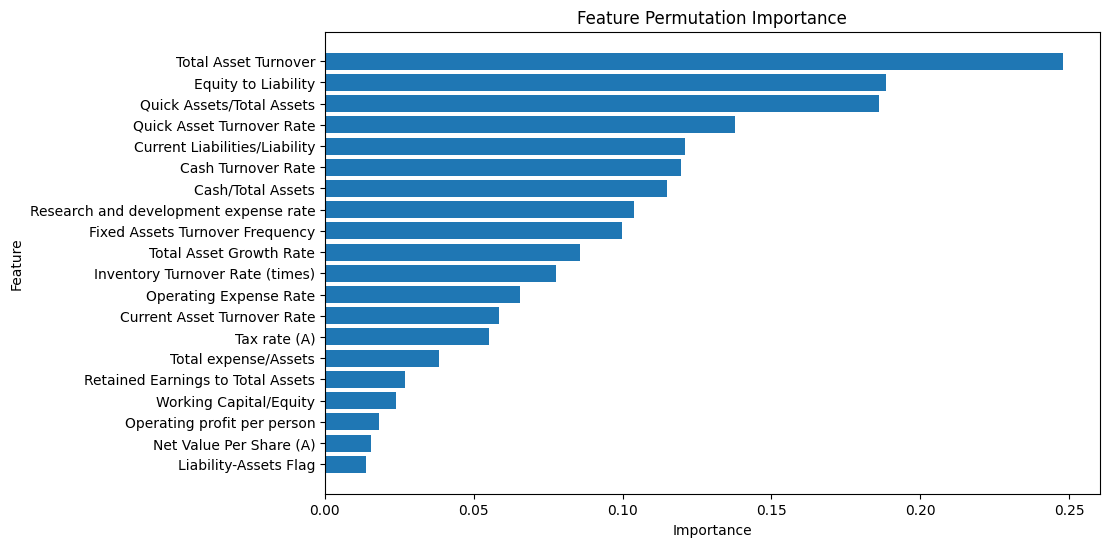

In [ ]:
plot_feat_permut_importance(svm_feat_permut_import_df)

In [ ]:
svm_perf, svm_orig_missing, svm_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    taiwan_imputation_scaled_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Original feat removed so far:  ['Total Asset Turnover']

--- NEW ITERATION ---
Removing feature:  Equity to Liability
Original feat removed so far:  ['Total Asset Turnover', 'Equity to Liability']

--- NEW ITERATION ---
Removing feature:  Quick Assets/Total Assets
Original feat removed so far:  ['Total Asset Turnover', 'Equity to Liability', 'Quick Assets/Total Assets']

--- NEW ITERATION ---
Removing feature:  Quick Asset Turnover Rate
Original feat removed so far:  ['Total Asset Turnover', 'Equity to Liability', 'Quick Assets/Total Assets', 'Quick Asset Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Current Liabilities/Liability
Original feat removed so far:  ['Total Asset Turnover', 'Equity to Liability', 'Quick Assets/Total Assets', 'Quick Asset Turnover Rate', 'Current Liabilities/Liability']

--- NEW ITERATION ---
Removing feature:  Cash Turnover Rate
Original feat removed so far:  ['Total Asset Turnover', 

In [ ]:
svm_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   22  1233   87  22      20.18   50.00        93.41     92.01     28.76   
1   19  1218  102  25      15.70   43.18        92.27     90.69     23.03   
2   15  1235   85  29      15.00   34.09        93.56     91.64     20.83   
3   23  1208  112  21      17.04   52.27        91.52     90.25     25.70   
4   19  1217  103  25      15.57   43.18        92.20     90.62     22.89   
5   26  1171  149  18      14.86   59.09        88.71     87.76     23.74   
6   27  1126  194  17      12.22   61.36        85.30     84.53     20.38   
7   22  1152  168  22      11.58   50.00        87.27     86.07     18.80   
8   20  1130  190  24       9.52   45.45        85.61     84.31     15.75   
9   23  1117  203  21      10.18   52.27        84.62     83.58     17.04   
10  27  1063  257  17       9.51   61.36        80.53     79.91     16.46   
11  26  1071  249  18       9.45   59.09        81.14     80.43     16.30   
12  25  1115  205  19      10.87   56.82        84.47     83.58     18.25   
13  26  1111  209  18      11.06   59.09        84.17     83.36     18.64   
14  26  1136  184  18      12.38   59.09        86.06     85.19     20.47   
15  21  1210  110  23      16.03   47.73        91.67     90.25     24.00   
16  27  1180  140  17      16.17   61.36        89.39     88.49     25.59   
17  29  1189  131  15      18.12   65.91        90.08     89.30     28.43   
18  32  1175  145  12      18.08   72.73        89.02     88.49     28.96   
19  28  1217  103  16      21.37   63.64        92.20     91.28     32.00   
20  27  1217  103  17      20.77   61.36        92.20     91.20     31.03   

    balanced_accuracy  num_feat_missing  \
0               71.70                 0   
1               67.73                 1   
2               63.83                 2   
3               71.89                 3   
4               67.69                 4   
5               73.90                 5   
6               73.33                 6   
7               68.64                 7   
8               65.53                 8   
9               68.45                 9   
10              70.95                10   
11              70.11                11   
12              70.64                12   
13              71.63                13   
14              72.58                14   
15              69.70                15   
16              75.38                16   
17              77.99                17   
18              80.87                18   
19              77.92                19   
20              76.78                20   

                                              imputed  
0                                                      
1                    ['Total Asset Turnover'] imputed  
2   ['Total Asset Turnover', 'Equity to Liability'...  
3   ['Total Asset Turnover', 'Equity to Liability'...  
4   ['Total Asset Turnover', 'Equity to Liability'...  
5   ['Total Asset Turnover', 'Equity to Liability'...  
6   ['Total Asset Turnover', 'Equity to Liability'...  
7   ['Total Asset Turnover', 'Equity to Liability'...  
8   ['Total Asset Turnover', 'Equity to Liability'...  
9   ['Total Asset Turnover', 'Equity to Liability'...  
10  ['Total Asset Turnover', 'Equity to Liability'...  
11  ['Total Asset Turnover', 'Equity to Liability'...  
12  ['Total Asset Turnover', 'Equity to Liability'...  
13  ['Total Asset Turnover', 'Equity to Liability'...  
14  ['Total Asset Turnover', 'Equity to Liability'...  
15  ['Total Asset Turnover', 'Equity to Liability'...  
16  ['Total Asset Turnover', 'Equity to Liability'...  
17  ['Total Asset Turnover', 'Equity to Liability'...  
18  ['Total Asset Turnover', 'Equity to Liability'...  
19  ['Total Asset Turnover', 'Equity to Liability'...  
20  ['Total Asset Turnover', 'Equity to Liability'...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm_perf_mf, svm_orig_missing_mf, svm_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 11:24:09.532552

--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Continuous interest rate (after tax)', 'Total income/Total expense', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Non-industry income and expenditure/revenue', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Operating Gross Margin', 'Interest Expense Ratio', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Total expense/Assets', 'Total Asset Return Growth Rate Ratio', 'Cash flow rate', 'Cash Flow Per Share', 'Inventory and accounts receivable/Net value', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Cash Flow to Equity', 'Working capitcal Turnover Rate', 'Cash/Curren

In [ ]:
svm_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   22  1233   87  22      20.18   50.00        93.41     92.01     28.76   
1   22  1240   80  22      21.57   50.00        93.94     92.52     30.14   
2   21  1257   63  23      25.00   47.73        95.23     93.70     32.81   
3   24  1244   76  20      24.00   54.55        94.24     92.96     33.33   
4   27  1188  132  17      16.98   61.36        90.00     89.08     26.60   
5   27  1183  137  17      16.46   61.36        89.62     88.71     25.96   
6   30  1174  146  14      17.05   68.18        88.94     88.27     27.27   
7   28  1188  132  16      17.50   63.64        90.00     89.15     27.45   
8   28  1163  157  16      15.14   63.64        88.11     87.32     24.45   
9   31  1158  162  13      16.06   70.45        87.73     87.17     26.16   
10  35  1107  213   9      14.11   79.55        83.86     83.72     23.97   
11  38  1057  263   6      12.62   86.36        80.08     80.28     22.03   
12  39   973  347   5      10.10   88.64        73.71     74.19     18.14   
13  41   800  520   3       7.31   93.18        60.61     61.66     13.55   
14  41   822  498   3       7.61   93.18        62.27     63.27     14.07   
15  41   821  499   3       7.59   93.18        62.20     63.20     14.04   
16  41   824  496   3       7.64   93.18        62.42     63.42     14.11   
17  41   827  493   3       7.68   93.18        62.65     63.64     14.19   
18  41   826  494   3       7.66   93.18        62.58     63.56     14.16   
19  41   834  486   3       7.78   93.18        63.18     64.15     14.36   
20  40   834  486   4       7.60   90.91        63.18     64.08     14.04   

    balanced_accuracy  num_feat_missing  \
0               71.70                 0   
1               71.97                 1   
2               71.48                 2   
3               74.39                 3   
4               75.68                 4   
5               75.49                 5   
6               78.56                 6   
7               76.82                 7   
8               75.87                 8   
9               79.09                 9   
10              81.70                10   
11              83.22                11   
12              81.17                12   
13              76.89                13   
14              77.73                14   
15              77.69                15   
16              77.80                16   
17              77.92                17   
18              77.88                18   
19              78.18                19   
20              77.05                20   

                                              imputed  
0                                                      
1                    ['Total Asset Turnover'] imputed  
2   ['Total Asset Turnover', 'Equity to Liability'...  
3   ['Total Asset Turnover', 'Equity to Liability'...  
4   ['Total Asset Turnover', 'Equity to Liability'...  
5   ['Total Asset Turnover', 'Equity to Liability'...  
6   ['Total Asset Turnover', 'Equity to Liability'...  
7   ['Total Asset Turnover', 'Equity to Liability'...  
8   ['Total Asset Turnover', 'Equity to Liability'...  
9   ['Total Asset Turnover', 'Equity to Liability'...  
10  ['Total Asset Turnover', 'Equity to Liability'...  
11  ['Total Asset Turnover', 'Equity to Liability'...  
12  ['Total Asset Turnover', 'Equity to Liability'...  
13  ['Total Asset Turnover', 'Equity to Liability'...  
14  ['Total Asset Turnover', 'Equity to Liability'...  
15  ['Total Asset Turnover', 'Equity to Liability'...  
16  ['Total Asset Turnover', 'Equity to Liability'...  
17  ['Total Asset Turnover', 'Equity to Liability'...  
18  ['Total Asset Turnover', 'Equity to Liability'...  
19  ['Total Asset Turnover', 'Equity to Liability'...  
20  ['Total Asset Turnover', 'Equity to Liability'...

##**Logistic Regression**

**Data pre-processing:** It is highly recommended to mitigate as much as possible the presence of multicollinearity between features before applying Logistic regression.

In [ ]:
present_features = list(X_train_scaled.columns) + ['Target']
filtered_taiwan_dist_corr = taiwan_dist_corr[present_features]
filtered_taiwan_dist_corr = filtered_taiwan_dist_corr[filtered_taiwan_dist_corr.index.isin(present_features)]
filtered_feat = filter_out_intercorrelated_features(filtered_taiwan_dist_corr, 'Target', 0.8)

appended feature:  Net Income to Stockholder's Equity
appended feature:  Borrowing dependency
appended feature:  Retained Earnings to Total Assets
appended feature:  Current Liabilities/Equity
appended feature:  Current Liability to Current Assets
appended feature:  Continuous interest rate (after tax)
appended feature:  Total income/Total expense
appended feature:  Net Value Per Share (A)
appended feature:  Working Capital/Equity
appended feature:  Operating Profit Per Share (Yuan ¥)
appended feature:  Non-industry income and expenditure/revenue
appended feature:  Operating profit per person
appended feature:  Equity to Long-term Liability
appended feature:  Equity to Liability
appended feature:  Tax rate (A)
appended feature:  Liability-Assets Flag
appended feature:  Operating Gross Margin
appended feature:  Interest Expense Ratio
appended feature:  Interest Coverage Ratio (Interest expense to EBIT)
appended feature:  Total expense/Assets
appended feature:  Total Asset Return Growth 

In [ ]:
lr_X_train = X_train_scaled[filtered_feat]
lr_X_test = X_test_scaled[filtered_feat]

In [ ]:
print('Nr. features for Logistic Regression: ', len(lr_X_train.columns))

Nr. features for Logistic Regression:  64


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],  # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
  }
else:
  lr_param_grid = {
      'C': [10.0],
      'penalty': ['l1'],
      'solver': ['liblinear']
  }

lr_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr_grid_search, lr_best_model, lr_best_params = hyperparameter_tuning(
    lr_classifier, lr_param_grid, 3, 3, 'f1', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 11:28:53.628329

Nested Cross-validation Results:
Individual scores: [0.26900585 0.23529412 0.26595745]
Average nested CV score: 0.257 (+/- 0.030)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.257
2025-01-16 11:30:12.722451

Execution time: 1.32 minutes




```
Starting hyperparameter tuning at: 2025-01-15 14:45:59.143253

Nested Cross-validation Results:
Individual scores: [0.26900585 0.21195652 0.18095238]
Average nested CV score: 0.221 (+/- 0.073)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.257

Train score: 0.302
Test score: 0.257
Train-test score difference: 0.045
2025-01-15 14:48:25.530217

Execution time: 2.44 minutes
```



In [ ]:
lr_classifier, train_pred, test_pred = apply_model(lr_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr_feat_permut_import_df = analyze_feat_permut_import(lr_classifier, lr_X_train, y_train, scoring_metric="f1")
lr_feat_permut_import_df[lr_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
13                          Equity to Liability    0.050750  0.009315
32                       Cash Flow to Liability    0.015584  0.006300
52                Current Liabilities/Liability    0.014699  0.003304
31                    Quick Assets/Total Assets    0.013799  0.003112
23  Inventory and accounts receivable/Net value    0.013582  0.003914
19                         Total expense/Assets    0.011729  0.002427
46                           Cash Turnover Rate    0.009698  0.003904
56              Inventory Turnover Rate (times)    0.008708  0.002937
26                          Cash Flow to Equity    0.008469  0.004035
6                    Total income/Total expense    0.005095  0.008938
12                Equity to Long-term Liability    0.004866  0.001275
55                       Operating Expense Rate    0.004740  0.001318
15                        Liability-Assets Flag    0.004640  0.000131
47        Research and development expense rate    0.003332  0.001347
50                    Quick Asset Turnover Rate    0.003182  0.002760
25             After-tax Net Profit Growth Rate    0.002916  0.000200
60                 Accounts Receivable Turnover    0.001782  0.000781
51                   Total debt/Total net worth    0.001715  0.000866
54                  Current Asset Turnover Rate    0.001547  0.000952
1                          Borrowing dependency    0.001543  0.003184
33                    Inventory/Working Capital    0.001219  0.000766
42         Long-term fund suitability ratio (A)    0.001156  0.000776
30           Degree of Financial Leverage (DFL)    0.000456  0.000820
14                                 Tax rate (A)    0.000428  0.001081
48                    Total assets to GNP price    0.000428  0.000595
17                       Interest Expense Ratio    0.000381  0.000133
61                      Average Collection Days    0.000364  0.000800
35                         Total Asset Turnover    0.000289  0.004416
58                  Inventory/Current Liability    0.000218  0.000109
41            Continuous Net Profit Growth Rate    0.000109  0.000133
37                 Operating Profit Growth Rate    0.000109  0.000133
44                           Cash Flow to Sales    0.000109  0.000133
29                           No-credit Interval    0.000053  0.000609
62               Quick Assets/Current Liability   -0.000055  0.000109
4           Current Liability to Current Assets   -0.000072  0.000612
0            Net Income to Stockholder's Equity   -0.000109  0.000219
57                   Allocation rate per person   -0.000109  0.000278
45      Realized Sales Gross Profit Growth Rate   -0.000164  0.000134
59        Long-term Liability to Current Assets   -0.000218  0.000109
22                          Cash Flow Per Share   -0.000218  0.000204
39                      Total Asset Growth Rate   -0.000292  0.000816
28                       Cash/Current Liability   -0.000492  0.000319
53          Interest-bearing debt interest rate   -0.000522  0.001124
9           Operating Profit Per Share (Yuan ¥)   -0.000567  0.002516
36              Fixed Assets Turnover Frequency   -0.000750  0.002033
11                  Operating profit per person   -0.000995  0.001570
16                       Operating Gross Margin   -0.001154  0.002774
24                            Cash/Total Assets   -0.001273  0.005961
21                               Cash flow rate   -0.002012  0.001568
2             Retained Earnings to Total Assets   -0.004342  0.004963
7                       Net Value Per Share (A)   -0.004450  0.004306

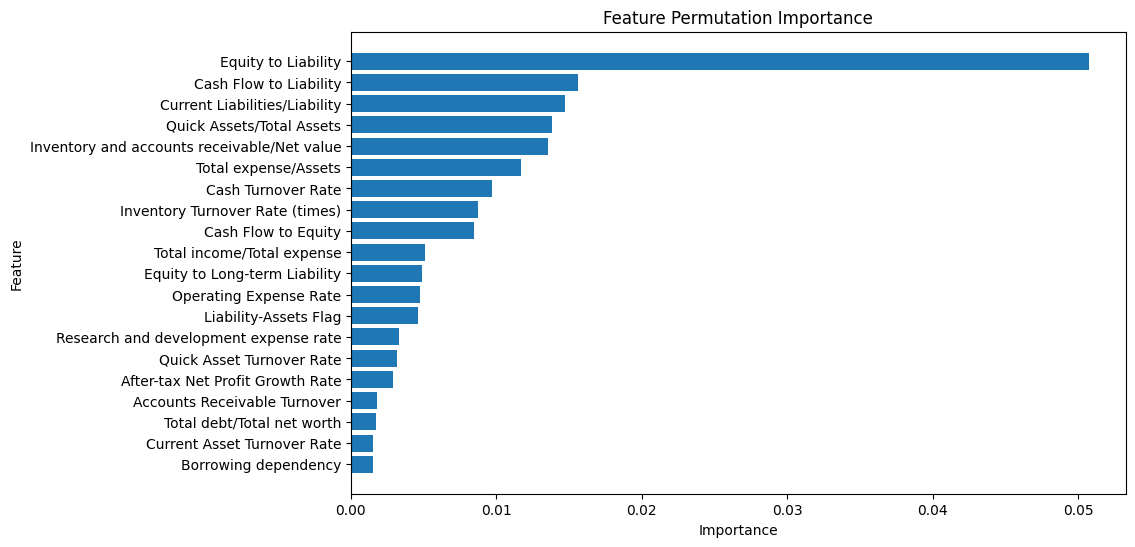

In [ ]:
plot_feat_permut_importance(lr_feat_permut_import_df)

In [ ]:
lr_perf, lr_orig_missing, lr_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Equity to Liability
Original feat removed so far:  ['Equity to Liability']

--- NEW ITERATION ---
Removing feature:  Cash Flow to Liability
Original feat removed so far:  ['Equity to Liability', 'Cash Flow to Liability']

--- NEW ITERATION ---
Removing feature:  Current Liabilities/Liability
Original feat removed so far:  ['Equity to Liability', 'Cash Flow to Liability', 'Current Liabilities/Liability']

--- NEW ITERATION ---
Removing feature:  Quick Assets/Total Assets
Original feat removed so far:  ['Equity to Liability', 'Cash Flow to Liability', 'Current Liabilities/Liability', 'Quick Assets/Total Assets']

--- NEW ITERATION ---
Removing feature:  Inventory and accounts receivable/Net value
Original feat removed so far:  ['Equity to Liability', 'Cash Flow to Liability', 'Current Liabilities/Liability', 'Quick Assets/Total Assets', 'Inventory and accounts receivable/Net value']

--- NEW ITERATION ---
Removing feature:  Total expense/Assets
O

In [ ]:
lr_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1165  155   8      18.85   81.82        88.26     88.05     30.64   
1   33  1173  147  11      18.33   75.00        88.86     88.42     29.46   
2   31  1186  134  13      18.79   70.45        89.85     89.22     29.67   
3   33  1176  144  11      18.64   75.00        89.09     88.64     29.86   
4   36  1169  151   8      19.25   81.82        88.56     88.34     31.17   
5   36  1164  156   8      18.75   81.82        88.18     87.98     30.51   
6   36  1166  154   8      18.95   81.82        88.33     88.12     30.77   
7    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
8    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               85.04                 0   
1               81.93                 1   
2               80.15                 2   
3               82.05                 3   
4               85.19                 4   
5               85.00                 5   
6               85.08                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Cash Flow to Liabilit...  
3   ['Equity to Liability', 'Cash Flow to Liabilit...  
4   ['Equity to Liability', 'Cash Flow to Liabilit...  
5   ['Equity to Liability', 'Cash Flow to Liabilit...  
6   ['Equity to Liability', 'Cash Flow to Liabilit...  
7   ['Equity to Liability', 'Cash Flow to Liabilit...  
8   ['Equity to Liability', 'Cash Flow to Liabilit...  
9   ['Equity to Liability', 'Cash Flow to Liabilit...  
10  ['Equity to Liability', 'Cash Flow to Liabilit...  
11  ['Equity to Liability', 'Cash Flow to Liabilit...  
12  ['Equity to Liability', 'Cash Flow to Liabilit...  
13  ['Equity to Liability', 'Cash Flow to Liabilit...  
14  ['Equity to Liability', 'Cash Flow to Liabilit...  
15  ['Equity to Liability', 'Cash Flow to Liabilit...  
16  ['Equity to Liability', 'Cash Flow to Liabilit...  
17  ['Equity to Liability', 'Cash Flow to Liabilit...  
18  ['Equity to Liability', 'Cash Flow to Liabilit...  
19  ['Equity to Liability', 'Cash Flow to Liabilit...  
20  ['Equity to Liability', 'Cash Flow to Liabilit...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr_perf_mf, lr_orig_missing_mf, lr_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 11:30:36.475242

--- NEW ITERATION ---
Removing feature:  Equity to Liability
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Continuous interest rate (after tax)', 'Total income/Total expense', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Non-industry income and expenditure/revenue', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Operating Gross Margin', 'Interest Expense Ratio', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Total expense/Assets', 'Total Asset Return Growth Rate Ratio', 'Cash flow rate', 'Cash Flow Per Share', 'Inventory and accounts receivable/Net value', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Cash Flow to Equity', 'Working capitcal Turnover Rate', 'Cash/Current

In [ ]:
lr_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1165  155   8      18.85   81.82        88.26     88.05     30.64   
1   36  1184  136   8      20.93   81.82        89.70     89.44     33.33   
2   36  1186  134   8      21.18   81.82        89.85     89.59     33.64   
3   36  1186  134   8      21.18   81.82        89.85     89.59     33.64   
4   36  1188  132   8      21.43   81.82        90.00     89.74     33.96   
5   36  1187  133   8      21.30   81.82        89.92     89.66     33.80   
6   35  1187  133   9      20.83   79.55        89.92     89.59     33.02   
7   35  1184  136   9      20.47   79.55        89.70     89.37     32.56   
8   34  1186  134  10      20.24   77.27        89.85     89.44     32.08   
9   33  1185  135  11      19.64   75.00        89.77     89.30     31.13   
10  34  1185  135  10      20.12   77.27        89.77     89.37     31.92   
11  34  1185  135  10      20.12   77.27        89.77     89.37     31.92   
12  34  1181  139  10      19.65   77.27        89.47     89.08     31.34   
13  33  1181  139  11      19.19   75.00        89.47     89.00     30.56   
14  35  1180  140   9      20.00   79.55        89.39     89.08     31.96   
15  34  1176  144  10      19.10   77.27        89.09     88.71     30.63   
16  36  1178  142   8      20.22   81.82        89.24     89.00     32.43   
17  36  1178  142   8      20.22   81.82        89.24     89.00     32.43   
18  36  1178  142   8      20.22   81.82        89.24     89.00     32.43   
19  36  1167  153   8      19.05   81.82        88.41     88.20     30.90   
20  32  1187  133  12      19.39   72.73        89.92     89.37     30.62   

    balanced_accuracy  num_feat_missing  \
0               85.04                 0   
1               85.76                 1   
2               85.83                 2   
3               85.83                 3   
4               85.91                 4   
5               85.87                 5   
6               84.73                 6   
7               84.62                 7   
8               83.56                 8   
9               82.39                 9   
10              83.52                10   
11              83.52                11   
12              83.37                12   
13              82.23                13   
14              84.47                14   
15              83.18                15   
16              85.53                16   
17              85.53                17   
18              85.53                18   
19              85.11                19   
20              81.33                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Cash Flow to Liabilit...  
3   ['Equity to Liability', 'Cash Flow to Liabilit...  
4   ['Equity to Liability', 'Cash Flow to Liabilit...  
5   ['Equity to Liability', 'Cash Flow to Liabilit...  
6   ['Equity to Liability', 'Cash Flow to Liabilit...  
7   ['Equity to Liability', 'Cash Flow to Liabilit...  
8   ['Equity to Liability', 'Cash Flow to Liabilit...  
9   ['Equity to Liability', 'Cash Flow to Liabilit...  
10  ['Equity to Liability', 'Cash Flow to Liabilit...  
11  ['Equity to Liability', 'Cash Flow to Liabilit...  
12  ['Equity to Liability', 'Cash Flow to Liabilit...  
13  ['Equity to Liability', 'Cash Flow to Liabilit...  
14  ['Equity to Liability', 'Cash Flow to Liabilit...  
15  ['Equity to Liability', 'Cash Flow to Liabilit...  
16  ['Equity to Liability', 'Cash Flow to Liabilit...  
17  ['Equity to Liability', 'Cash Flow to Liabilit...  
18  ['Equity to Liability', 'Cash Flow to Liabilit...  
19  ['Equity to Liability', 'Cash Flow to Liabilit...  
20  ['Equity to Liability', 'Cash Flow to Liabilit...

# **Models optimized for Balanced Accuracy**

##**Decision tree**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt2_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  dt2_param_grid = {
      'max_depth': [4],
      'min_samples_split': [0.10],
      'min_samples_leaf': [0.01]
  }

dt2_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt2_grid_search, dt2_best_model, dt2_best_params = hyperparameter_tuning(
    dt2_classifier, dt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 11:35:16.984632

Nested Cross-validation Results:
Individual scores: [0.85322612 0.82772335 0.83692583]
Average nested CV score: 0.839 (+/- 0.021)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 4, 'min_samples_leaf': 0.01, 'min_samples_split': 0.1}

Best Model Performance:
Best CV score: 0.839
2025-01-16 11:35:17.723881

Execution time: 0.01 minutes



```
Starting hyperparameter tuning at: 2025-01-15 14:48:25.541006

Nested Cross-validation Results:
Individual scores: [0.85322612 0.819279   0.79727021]
Average nested CV score: 0.823 (+/- 0.046)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': 4, 'min_samples_leaf': 0.01, 'min_samples_split': 0.1}

Best Model Performance:
Best CV score: 0.839

Train score: 0.889
Test score: 0.839
Train-test score difference: 0.050
2025-01-15 14:48:54.282822

Execution time: 0.48 minutes
```



In [ ]:
# dt_grid_search.cv_results_

In [ ]:
dt2_classifier, dt2_train_pred, dt2_test_pred = apply_model(dt2_best_model, X_train, y_train, X_test, y_test)
dt2_feat_permut_import_df = analyze_feat_permut_import(dt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
dt2_feat_permut_import_df[dt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
5          Continuous interest rate (after tax)    0.263217  0.010636
10  Non-industry income and expenditure/revenue    0.030814  0.007862
51                   Total debt/Total net worth    0.025267  0.002412
17                       Interest Expense Ratio    0.020870  0.003963
1                          Borrowing dependency    0.020228  0.001228
0            Net Income to Stockholder's Equity    0.015625  0.001327
33                    Inventory/Working Capital    0.012350  0.001626

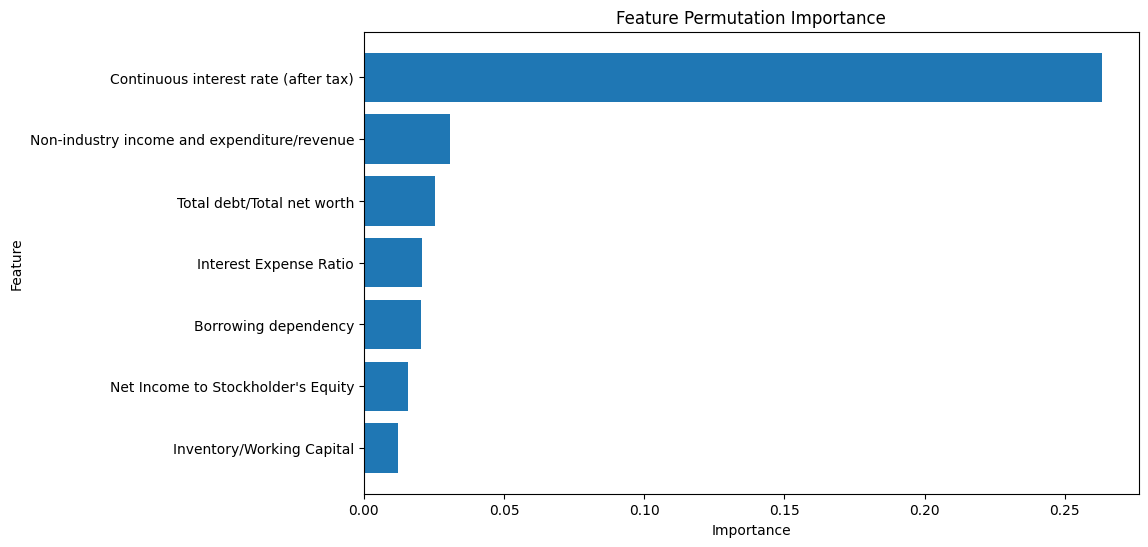

In [ ]:
plot_feat_permut_importance(dt2_feat_permut_import_df)

In [ ]:
dt2_perf, dt2_orig_missing, dt2_missing = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Original feat removed so far:  ['Continuous interest rate (after tax)']

--- NEW ITERATION ---
Removing feature:  Non-industry income and expenditure/revenue
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Non-industry income and expenditure/revenue']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Non-industry income and expenditure/revenue', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Interest Expense Ratio
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Non-industry income and expenditure/revenue', 'Total debt/Total net worth', 'Interest Expense Ratio']

--- NEW ITERATION ---
Removing feature:  Borrowing dependency
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Non-industry income and expenditure/revenue', 'Tot

In [ ]:
dt2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   39  1113  207   5      15.85   88.64        84.32     84.46     26.90   
1    7  1251   69  37       9.21   15.91        94.77     92.23     11.67   
2    4  1298   22  40      15.38    9.09        98.33     95.45     11.43   
3    4  1298   22  40      15.38    9.09        98.33     95.45     11.43   
4    7  1285   35  37      16.67   15.91        97.35     94.72     16.28   
5    7  1285   35  37      16.67   15.91        97.35     94.72     16.28   
6    7  1285   35  37      16.67   15.91        97.35     94.72     16.28   
7    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
8    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               86.48                 0   
1               55.34                 1   
2               53.71                 2   
3               53.71                 3   
4               56.63                 4   
5               56.63                 5   
6               56.63                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1    ['Continuous interest rate (after tax)'] imputed  
2   ['Continuous interest rate (after tax)', 'Non-...  
3   ['Continuous interest rate (after tax)', 'Non-...  
4   ['Continuous interest rate (after tax)', 'Non-...  
5   ['Continuous interest rate (after tax)', 'Non-...  
6   ['Continuous interest rate (after tax)', 'Non-...  
7   ['Continuous interest rate (after tax)', 'Non-...  
8   ['Continuous interest rate (after tax)', 'Non-...  
9   ['Continuous interest rate (after tax)', 'Non-...  
10  ['Continuous interest rate (after tax)', 'Non-...  
11  ['Continuous interest rate (after tax)', 'Non-...  
12  ['Continuous interest rate (after tax)', 'Non-...  
13  ['Continuous interest rate (after tax)', 'Non-...  
14  ['Continuous interest rate (after tax)', 'Non-...  
15  ['Continuous interest rate (after tax)', 'Non-...  
16  ['Continuous interest rate (after tax)', 'Non-...  
17  ['Continuous interest rate (after tax)', 'Non-...  
18  ['Continuous interest rate (after tax)', 'Non-...  
19  ['Continuous interest rate (after tax)', 'Non-...  
20  ['Continuous interest rate (after tax)', 'Non-...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt2_perf_mf, dt2_orig_missing_mf, dt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 11:35:18.845172

--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Continuous interest rate (after tax)', 'Total income/Total expense', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Non-industry income and expenditure/revenue', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Operating Gross Margin', 'Interest Expense Ratio', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Total expense/Assets', 'Total Asset Return Growth Rate Ratio', 'Cash flow rate', 'Cash Flow Per Share', 'Inventory and accounts receivable/Net value', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Cash Flow to Equity', 'Working capitcal Turnover Rat

In [ ]:
dt2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   39  1113  207   5      15.85   88.64        84.32     84.46     26.90   
1   38  1101  219   6      14.79   86.36        83.41     83.50     25.25   
2   36  1129  191   8      15.86   81.82        85.53     85.41     26.57   
3   36  1112  208   8      14.75   81.82        84.24     84.16     25.00   
4   37  1116  204   7      15.35   84.09        84.55     84.53     25.96   
5   35  1097  223   9      13.57   79.55        83.11     82.99     23.18   
6   35  1104  216   9      13.94   79.55        83.64     83.50     23.73   
7   34  1094  226  10      13.08   77.27        82.88     82.70     22.37   
8   33  1094  226  11      12.74   75.00        82.88     82.62     21.78   
9   33  1103  217  11      13.20   75.00        83.56     83.28     22.45   
10  34  1106  214  10      13.71   77.27        83.79     83.58     23.29   
11  34  1106  214  10      13.71   77.27        83.79     83.58     23.29   
12  34  1109  211  10      13.88   77.27        84.02     83.80     23.53   
13  34  1111  209  10      13.99   77.27        84.17     83.94     23.69   
14  33  1108  212  11      13.47   75.00        83.94     83.65     22.84   
15  34  1112  208  10      14.05   77.27        84.24     84.02     23.78   
16  35  1123  197   9      15.09   79.55        85.08     84.90     25.36   
17  34  1126  194  10      14.91   77.27        85.30     85.04     25.00   
18  33  1124  196  11      14.41   75.00        85.15     84.82     24.18   
19  33  1123  197  11      14.35   75.00        85.08     84.75     24.09   
20  33  1135  185  11      15.14   75.00        85.98     85.63     25.19   

    balanced_accuracy  num_feat_missing  \
0               86.48                 0   
1               84.89                 1   
2               83.67                 2   
3               83.03                 3   
4               84.32                 4   
5               81.33                 5   
6               81.59                 6   
7               80.08                 7   
8               78.94                 8   
9               79.28                 9   
10              80.53                10   
11              80.53                11   
12              80.64                12   
13              80.72                13   
14              79.47                14   
15              80.76                15   
16              82.31                16   
17              81.29                17   
18              80.08                18   
19              80.04                19   
20              80.49                20   

                                              imputed  
0                                                      
1    ['Continuous interest rate (after tax)'] imputed  
2   ['Continuous interest rate (after tax)', 'Non-...  
3   ['Continuous interest rate (after tax)', 'Non-...  
4   ['Continuous interest rate (after tax)', 'Non-...  
5   ['Continuous interest rate (after tax)', 'Non-...  
6   ['Continuous interest rate (after tax)', 'Non-...  
7   ['Continuous interest rate (after tax)', 'Non-...  
8   ['Continuous interest rate (after tax)', 'Non-...  
9   ['Continuous interest rate (after tax)', 'Non-...  
10  ['Continuous interest rate (after tax)', 'Non-...  
11  ['Continuous interest rate (after tax)', 'Non-...  
12  ['Continuous interest rate (after tax)', 'Non-...  
13  ['Continuous interest rate (after tax)', 'Non-...  
14  ['Continuous interest rate (after tax)', 'Non-...  
15  ['Continuous interest rate (after tax)', 'Non-...  
16  ['Continuous interest rate (after tax)', 'Non-...  
17  ['Continuous interest rate (after tax)', 'Non-...  
18  ['Continuous interest rate (after tax)', 'Non-...  
19  ['Continuous interest rate (after tax)', 'Non-...  
20  ['Continuous interest rate (after tax)', 'Non-...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  rf2_param_grid = {
    'n_estimators': [100],
    'max_features': ['sqrt'],
    'min_samples_split': [0.01],
    'min_samples_leaf': [0.01],
    'max_depth': [3]
}

rf2_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf2_grid_search, rf2_best_model, rf2_best_params = hyperparameter_tuning(
    rf2_classifier, rf2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 11:40:42.839088

Nested Cross-validation Results:
Individual scores: [0.86241333 0.82628331 0.84543414]
Average nested CV score: 0.845 (+/- 0.030)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.845
2025-01-16 11:40:48.823948

Execution time: 0.10 minutes




```
Starting hyperparameter tuning at: 2025-01-15 22:55:29.079733

Nested Cross-validation Results:
Individual scores: [0.85365466 0.82628331 0.81158883]
Average nested CV score: 0.831 (+/- 0.035)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.845
2025-01-16 00:07:29.770528

Execution time: 72.01 minutes
```



In [ ]:
# rf2_grid_search.cv_results_

In [ ]:
rf2_classifier, rf2_train_pred, rf2_test_pred = apply_model(rf2_best_model, X_train, y_train, X_test, y_test)
rf2_feat_permut_import_df = analyze_feat_permut_import(rf2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
rf2_feat_permut_import_df[rf2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
2                   Retained Earnings to Total Assets    0.014182  0.006531
1                                Borrowing dependency    0.011912  0.002587
0                  Net Income to Stockholder's Equity    0.010094  0.002567
7                             Net Value Per Share (A)    0.009091  0.001549
28                             Cash/Current Liability    0.008617  0.002133
51                         Total debt/Total net worth    0.008504  0.001317
6                          Total income/Total expense    0.008483  0.004742
10        Non-industry income and expenditure/revenue    0.007954  0.002283
5                Continuous interest rate (after tax)    0.006911  0.004391
13                                Equity to Liability    0.006117  0.003123
30                 Degree of Financial Leverage (DFL)    0.005890  0.002184
53                Interest-bearing debt interest rate    0.005606  0.001999
24                                  Cash/Total Assets    0.005568  0.002058
49                                        Quick Ratio    0.005283  0.003496
4                 Current Liability to Current Assets    0.004962  0.001491
18  Interest Coverage Ratio (Interest expense to E...    0.004848  0.003715
62                     Quick Assets/Current Liability    0.004621  0.002793
63                                      Current Ratio    0.004394  0.002132
9                 Operating Profit Per Share (Yuan ¥)    0.003939  0.002602
14                                       Tax rate (A)    0.002935  0.002796
36                    Fixed Assets Turnover Frequency    0.002746  0.000085
33                          Inventory/Working Capital    0.002689  0.000142
12                      Equity to Long-term Liability    0.002670  0.000093
20               Total Asset Return Growth Rate Ratio    0.002424  0.000076
40                              Net Value Growth Rate    0.002405  0.001274
23        Inventory and accounts receivable/Net value    0.002273  0.001184
3                          Current Liabilities/Equity    0.002159  0.001370
42               Long-term fund suitability ratio (A)    0.002045  0.001072
45            Realized Sales Gross Profit Growth Rate    0.001875  0.001132
17                             Interest Expense Ratio    0.001837  0.001390
44                                 Cash Flow to Sales    0.001458  0.002250
26                                Cash Flow to Equity    0.000606  0.000982
32                             Cash Flow to Liability    0.000511  0.001072
46                                 Cash Turnover Rate    0.000473  0.001138
27                     Working capitcal Turnover Rate    0.000265  0.001107
19                               Total expense/Assets    0.000170  0.000110
29                                 No-credit Interval    0.000095  0.000085
47              Research and development expense rate    0.000057  0.000046
25                   After-tax Net Profit Growth Rate    0.000019  0.000093
8                              Working Capital/Equity    0.000019  0.000038
54                        Current Asset Turnover Rate    0.000019  0.000071
58                        Inventory/Current Liability   -0.000019  0.000071
35                               Total Asset Turnover   -0.000076  0.000071
37                       Operating Profit Growth Rate   -0.000076  0.000071
48                          Total assets to GNP price   -0.000095  0.000158
38                             Fixed Assets to Assets   -0.000114  0.000110
57                         Allocation rate per person   -0.000133  0.000046
61                            Average Collection Days   -0.000133  0.000046
22                                Cash Flow Per Share   -0.000189  0.000134
59              Long-term Liability to Current Assets   -0.000189  0.000120
41                  Continuous Net Profit Growth Rate   -0.000227  0.000176
34                   Contingent liabilities/Net worth   -0.000227  0.000097
16                

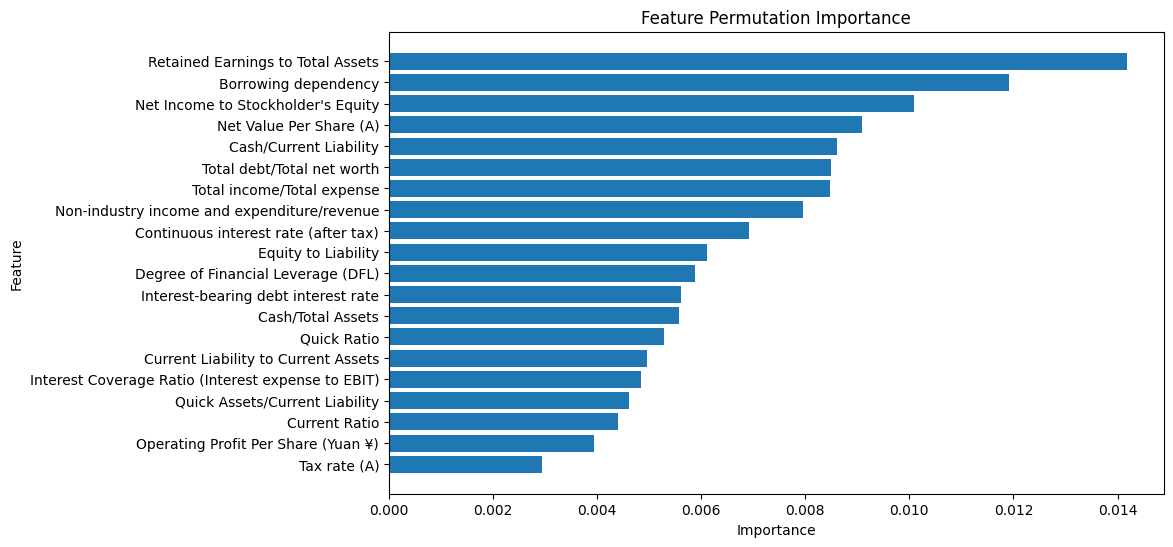

In [ ]:
plot_feat_permut_importance(rf2_feat_permut_import_df)

In [ ]:
rf2_perf, rf2_orig_missing, rf2_missing = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Retained Earnings to Total Assets
Original feat removed so far:  ['Retained Earnings to Total Assets']

--- NEW ITERATION ---
Removing feature:  Borrowing dependency
Original feat removed so far:  ['Retained Earnings to Total Assets', 'Borrowing dependency']

--- NEW ITERATION ---
Removing feature:  Net Income to Stockholder's Equity
Original feat removed so far:  ['Retained Earnings to Total Assets', 'Borrowing dependency', "Net Income to Stockholder's Equity"]

--- NEW ITERATION ---
Removing feature:  Net Value Per Share (A)
Original feat removed so far:  ['Retained Earnings to Total Assets', 'Borrowing dependency', "Net Income to Stockholder's Equity", 'Net Value Per Share (A)']

--- NEW ITERATION ---
Removing feature:  Cash/Current Liability
Original feat removed so far:  ['Retained Earnings to Total Assets', 'Borrowing dependency', "Net Income to Stockholder's Equity", 'Net Value Per Share (A)', 'Cash/Current Liability']

--- NEW ITERATION

In [ ]:
rf2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1185  135   8      21.05   81.82        89.77     89.52     33.49   
1   34  1242   78  10      30.36   77.27        94.09     93.55     43.59   
2   31  1262   58  13      34.83   70.45        95.61     94.79     46.62   
3   27  1277   43  17      38.57   61.36        96.74     95.60     47.37   
4   25  1283   37  19      40.32   56.82        97.20     95.89     47.17   
5   25  1283   37  19      40.32   56.82        97.20     95.89     47.17   
6   12  1306   14  32      46.15   27.27        98.94     96.63     34.29   
7    4  1320    0  40     100.00    9.09       100.00     97.07     16.67   
8    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               85.80                 0   
1               85.68                 1   
2               83.03                 2   
3               79.05                 3   
4               77.01                 4   
5               77.01                 5   
6               63.11                 6   
7               54.55                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1       ['Retained Earnings to Total Assets'] imputed  
2   ['Retained Earnings to Total Assets', 'Borrowi...  
3   ['Retained Earnings to Total Assets', 'Borrowi...  
4   ['Retained Earnings to Total Assets', 'Borrowi...  
5   ['Retained Earnings to Total Assets', 'Borrowi...  
6   ['Retained Earnings to Total Assets', 'Borrowi...  
7   ['Retained Earnings to Total Assets', 'Borrowi...  
8   ['Retained Earnings to Total Assets', 'Borrowi...  
9   ['Retained Earnings to Total Assets', 'Borrowi...  
10  ['Retained Earnings to Total Assets', 'Borrowi...  
11  ['Retained Earnings to Total Assets', 'Borrowi...  
12  ['Retained Earnings to Total Assets', 'Borrowi...  
13  ['Retained Earnings to Total Assets', 'Borrowi...  
14  ['Retained Earnings to Total Assets', 'Borrowi...  
15  ['Retained Earnings to Total Assets', 'Borrowi...  
16  ['Retained Earnings to Total Assets', 'Borrowi...  
17  ['Retained Earnings to Total Assets', 'Borrowi...  
18  ['Retained Earnings to Total Assets', 'Borrowi...  
19  ['Retained Earnings to Total Assets', 'Borrowi...  
20  ['Retained Earnings to Total Assets', 'Borrowi...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf2_perf_mf, rf2_orig_missing_mf, rf2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 11:40:52.176216

--- NEW ITERATION ---
Removing feature:  Retained Earnings to Total Assets
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Continuous interest rate (after tax)', 'Total income/Total expense', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Non-industry income and expenditure/revenue', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Operating Gross Margin', 'Interest Expense Ratio', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Total expense/Assets', 'Total Asset Return Growth Rate Ratio', 'Cash flow rate', 'Cash Flow Per Share', 'Inventory and accounts receivable/Net value', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Cash Flow to Equity', 'Working capitcal Turnover Rate',

In [ ]:
rf2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1185  135   8      21.05   81.82        89.77     89.52     33.49   
1   36  1183  137   8      20.81   81.82        89.62     89.37     33.18   
2   35  1183  137   9      20.35   79.55        89.62     89.30     32.41   
3   35  1185  135   9      20.59   79.55        89.77     89.44     32.71   
4   35  1195  125   9      21.88   79.55        90.53     90.18     34.31   
5   35  1198  122   9      22.29   79.55        90.76     90.40     34.83   
6   35  1202  118   9      22.88   79.55        91.06     90.69     35.53   
7   36  1208  112   8      24.32   81.82        91.52     91.20     37.50   
8   34  1216  104  10      24.64   77.27        92.12     91.64     37.36   
9   32  1229   91  12      26.02   72.73        93.11     92.45     38.32   
10  29  1248   72  15      28.71   65.91        94.55     93.62     40.00   
11  29  1252   68  15      29.90   65.91        94.85     93.91     41.13   
12  28  1250   70  16      28.57   63.64        94.70     93.70     39.44   
13  27  1257   63  17      30.00   61.36        95.23     94.13     40.30   
14  25  1282   38  19      39.68   56.82        97.12     95.82     46.73   
15  25  1282   38  19      39.68   56.82        97.12     95.82     46.73   
16  21  1282   38  23      35.59   47.73        97.12     95.53     40.78   
17  21  1289   31  23      40.38   47.73        97.65     96.04     43.75   
18  15  1294   26  29      36.59   34.09        98.03     95.97     35.29   
19  13  1306   14  31      48.15   29.55        98.94     96.70     36.62   
20   8  1313    7  36      53.33   18.18        99.47     96.85     27.12   

    balanced_accuracy  num_feat_missing  \
0               85.80                 0   
1               85.72                 1   
2               84.58                 2   
3               84.66                 3   
4               85.04                 4   
5               85.15                 5   
6               85.30                 6   
7               86.67                 7   
8               84.70                 8   
9               82.92                 9   
10              80.23                10   
11              80.38                11   
12              79.17                12   
13              78.30                13   
14              76.97                14   
15              76.97                15   
16              72.42                16   
17              72.69                17   
18              66.06                18   
19              64.24                19   
20              58.83                20   

                                              imputed  
0                                                      
1       ['Retained Earnings to Total Assets'] imputed  
2   ['Retained Earnings to Total Assets', 'Borrowi...  
3   ['Retained Earnings to Total Assets', 'Borrowi...  
4   ['Retained Earnings to Total Assets', 'Borrowi...  
5   ['Retained Earnings to Total Assets', 'Borrowi...  
6   ['Retained Earnings to Total Assets', 'Borrowi...  
7   ['Retained Earnings to Total Assets', 'Borrowi...  
8   ['Retained Earnings to Total Assets', 'Borrowi...  
9   ['Retained Earnings to Total Assets', 'Borrowi...  
10  ['Retained Earnings to Total Assets', 'Borrowi...  
11  ['Retained Earnings to Total Assets', 'Borrowi...  
12  ['Retained Earnings to Total Assets', 'Borrowi...  
13  ['Retained Earnings to Total Assets', 'Borrowi...  
14  ['Retained Earnings to Total Assets', 'Borrowi...  
15  ['Retained Earnings to Total Assets', 'Borrowi...  
16  ['Retained Earnings to Total Assets', 'Borrowi...  
17  ['Retained Earnings to Total Assets', 'Borrowi...  
18  ['Retained Earnings to Total Assets', 'Borrowi...  
19  ['Retained Earnings to Total Assets', 'Borrowi...  
20  ['Retained Earnings to Total Assets', 'Borrowi...

##**Gradient-Boosted Trees**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [25, 15, 1],
      'min_split_gain': [1.0, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt2_param_grid = {
      'n_estimators': [100],
      'max_depth': [2],
      'min_child_samples': [15],
      'min_split_gain': [1.0],
      'reg_lambda': [10.0]
  }

gbt2_classifier = LGBMClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt2_grid_search, gbt2_best_model, gbt2_best_params = hyperparameter_tuning(
    gbt2_classifier, gbt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 11:46:20.270896

Nested Cross-validation Results:
Individual scores: [0.88509245 0.81860306 0.83559129]
Average nested CV score: 0.846 (+/- 0.056)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 15, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.846
2025-01-16 11:46:24.528396

Execution time: 0.07 minutes




```
Starting hyperparameter tuning at: 2025-01-13 02:38:19.428751

Nested Cross-validation Results:
Individual scores: [0.87462924 0.81263715 0.82063191]
Average nested CV score: 0.836 (+/- 0.055)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 25, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 0.5}

Best Model Performance:
Best CV score: 0.843

Train score: 0.962
Test score: 0.843
Train-test score difference: 0.119
2025-01-13 02:45:44.987140

Execution time: 7.43 minutes
---
WITH SCALE_POS_WEIGHT

Starting hyperparameter tuning at: 2025-01-15 14:48:54.290680

Nested Cross-validation Results:
Individual scores: [0.86785921 0.82836011 0.80595677]
Average nested CV score: 0.834 (+/- 0.051)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 15, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.846

Train score: 0.960
Test score: 0.846
Train-test score difference: 0.114
2025-01-15 14:56:19.566660

Execution time: 7.42 minutes
```



In [ ]:
gbt2_classifier, gbt2_train_pred, gbt2_test_pred = apply_model(gbt2_best_model, X_train, y_train, X_test, y_test)
gbt2_feat_permut_import_df = analyze_feat_permut_import(gbt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
gbt2_feat_permut_import_df[gbt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
2                   Retained Earnings to Total Assets    0.084447  0.010827
51                         Total debt/Total net worth    0.072630  0.008691
49                                        Quick Ratio    0.012897  0.002429
7                             Net Value Per Share (A)    0.011004  0.001583
43                                 Revenue per person    0.005777  0.001451
17                             Interest Expense Ratio    0.005719  0.002346
53                Interest-bearing debt interest rate    0.005132  0.002482
11                        Operating profit per person    0.003978  0.001273
46                                 Cash Turnover Rate    0.003731  0.001364
57                         Allocation rate per person    0.003182  0.001764
33                          Inventory/Working Capital    0.002993  0.003395
40                              Net Value Growth Rate    0.002992  0.001066
60                       Accounts Receivable Turnover    0.002689  0.001288
47              Research and development expense rate    0.002500  0.001332
56                    Inventory Turnover Rate (times)    0.002292  0.001206
23        Inventory and accounts receivable/Net value    0.002121  0.001165
16                             Operating Gross Margin    0.001894  0.001138
50                          Quick Asset Turnover Rate    0.001742  0.001372
44                                 Cash Flow to Sales    0.001667  0.002103
39                            Total Asset Growth Rate    0.001629  0.002063
26                                Cash Flow to Equity    0.001610  0.002255
30                 Degree of Financial Leverage (DFL)    0.001421  0.001393
5                Continuous interest rate (after tax)    0.001267  0.003216
28                             Cash/Current Liability    0.001231  0.001046
10        Non-industry income and expenditure/revenue    0.001117  0.000534
3                          Current Liabilities/Equity    0.000795  0.001454
48                          Total assets to GNP price    0.000549  0.001102
41                  Continuous Net Profit Growth Rate    0.000511  0.001325
32                             Cash Flow to Liability    0.000455  0.000038
29                                 No-credit Interval    0.000265  0.000152
35                               Total Asset Turnover    0.000189  0.000000
25                   After-tax Net Profit Growth Rate    0.000170  0.000093
36                    Fixed Assets Turnover Frequency    0.000095  0.000216
42               Long-term fund suitability ratio (A)    0.000057  0.000165
37                       Operating Profit Growth Rate    0.000038  0.000176
34                   Contingent liabilities/Net worth   -0.000019  0.000038
62                     Quick Assets/Current Liability   -0.000038  0.000195
24                                  Cash/Total Assets   -0.000057  0.000128
52                      Current Liabilities/Liability   -0.000095  0.000216
55                             Operating Expense Rate   -0.000114  0.000071
54                        Current Asset Turnover Rate   -0.000189  0.000120
31                          Quick Assets/Total Assets   -0.000246  0.002204
6                          Total income/Total expense   -0.000246  0.001294
20               Total Asset Return Growth Rate Ratio   -0.000379  0.000104
21                                     Cash flow rate   -0.000398  0.000277
22                                Cash Flow Per Share   -0.000530  0.000221
18  Interest Coverage Ratio (Interest expense to E...   -0.000644  0.001148
1                                Borrowing dependency   -0.001213  0.001934
61                            Average Collection Days   -0.001496  0.001060
0                  Net Income to Stockholder's Equity   -0.002254  0.001197

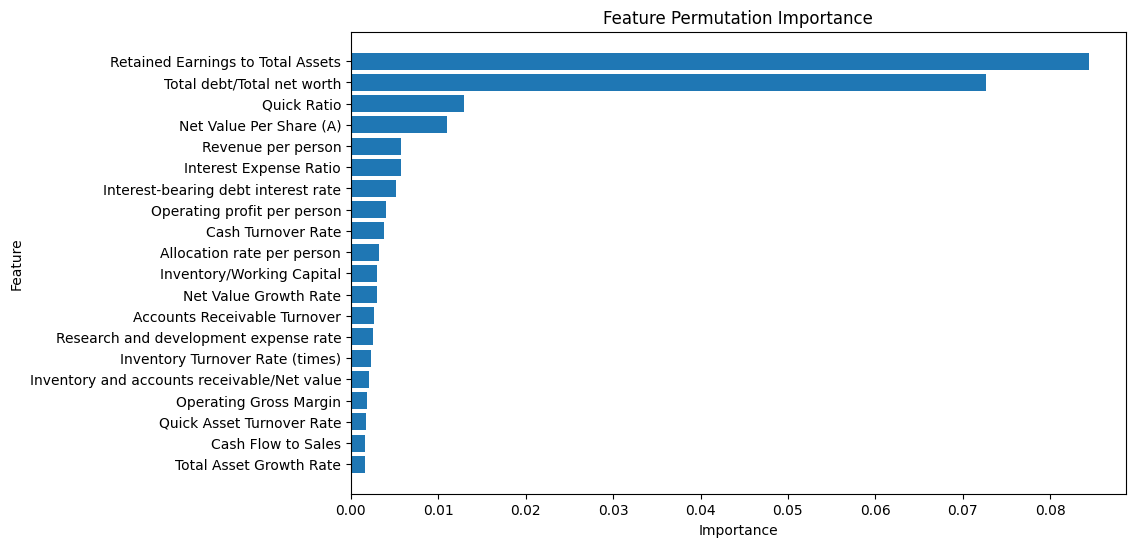

In [ ]:
plot_feat_permut_importance(gbt2_feat_permut_import_df)

In [ ]:
gbt2_perf, gbt2_orig_missing, gbt2_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Retained Earnings to Total Assets
Original feat removed so far:  ['Retained Earnings to Total Assets']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Retained Earnings to Total Assets', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Quick Ratio
Original feat removed so far:  ['Retained Earnings to Total Assets', 'Total debt/Total net worth', 'Quick Ratio']

--- NEW ITERATION ---
Removing feature:  Net Value Per Share (A)
Original feat removed so far:  ['Retained Earnings to Total Assets', 'Total debt/Total net worth', 'Quick Ratio', 'Net Value Per Share (A)']

--- NEW ITERATION ---
Removing feature:  Revenue per person
Original feat removed so far:  ['Retained Earnings to Total Assets', 'Total debt/Total net worth', 'Quick Ratio', 'Net Value Per Share (A)', 'Revenue per person']

--- NEW ITERATION ---
Removing feature:  Interest Expense Ratio
Original feat removed s

In [ ]:
gbt2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   37  1205  115   7      24.34   84.09        91.29     91.06     37.76   
1   18  1301   19  26      48.65   40.91        98.56     96.70     44.44   
2   14  1309   11  30      56.00   31.82        99.17     96.99     40.58   
3    5  1315    5  39      50.00   11.36        99.62     96.77     18.52   
4    4  1316    4  40      50.00    9.09        99.70     96.77     15.38   
5    3  1316    4  41      42.86    6.82        99.70     96.70     11.76   
6    4  1320    0  40     100.00    9.09       100.00     97.07     16.67   
7    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
8    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
9    1  1320    0  43     100.00    2.27       100.00     96.85      4.44   
10   1  1320    0  43     100.00    2.27       100.00     96.85      4.44   
11   1  1320    0  43     100.00    2.27       100.00     96.85      4.44   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               87.69                 0   
1               69.73                 1   
2               65.49                 2   
3               55.49                 3   
4               54.39                 4   
5               53.26                 5   
6               54.55                 6   
7               50.00                 7   
8               50.00                 8   
9               51.14                 9   
10              51.14                10   
11              51.14                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1       ['Retained Earnings to Total Assets'] imputed  
2   ['Retained Earnings to Total Assets', 'Total d...  
3   ['Retained Earnings to Total Assets', 'Total d...  
4   ['Retained Earnings to Total Assets', 'Total d...  
5   ['Retained Earnings to Total Assets', 'Total d...  
6   ['Retained Earnings to Total Assets', 'Total d...  
7   ['Retained Earnings to Total Assets', 'Total d...  
8   ['Retained Earnings to Total Assets', 'Total d...  
9   ['Retained Earnings to Total Assets', 'Total d...  
10  ['Retained Earnings to Total Assets', 'Total d...  
11  ['Retained Earnings to Total Assets', 'Total d...  
12  ['Retained Earnings to Total Assets', 'Total d...  
13  ['Retained Earnings to Total Assets', 'Total d...  
14  ['Retained Earnings to Total Assets', 'Total d...  
15  ['Retained Earnings to Total Assets', 'Total d...  
16  ['Retained Earnings to Total Assets', 'Total d...  
17  ['Retained Earnings to Total Assets', 'Total d...  
18  ['Retained Earnings to Total Assets', 'Total d...  
19  ['Retained Earnings to Total Assets', 'Total d...  
20  ['Retained Earnings to Total Assets', 'Total d...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt2_perf_mf, gbt2_orig_missing_mf, gbt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 11:46:27.200299

--- NEW ITERATION ---
Removing feature:  Retained Earnings to Total Assets
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Continuous interest rate (after tax)', 'Total income/Total expense', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Non-industry income and expenditure/revenue', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Operating Gross Margin', 'Interest Expense Ratio', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Total expense/Assets', 'Total Asset Return Growth Rate Ratio', 'Cash flow rate', 'Cash Flow Per Share', 'Inventory and accounts receivable/Net value', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Cash Flow to Equity', 'Working capitcal Turnover Rate',

In [ ]:
gbt2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   37  1205  115   7      24.34   84.09        91.29     91.06     37.76   
1   37  1197  123   7      23.12   84.09        90.68     90.47     36.27   
2   35  1192  128   9      21.47   79.55        90.30     89.96     33.82   
3   30  1233   87  14      25.64   68.18        93.41     92.60     37.27   
4   30  1239   81  14      27.03   68.18        93.86     93.04     38.71   
5   31  1234   86  13      26.50   70.45        93.48     92.74     38.51   
6   31  1233   87  13      26.27   70.45        93.41     92.67     38.27   
7   35  1209  111   9      23.97   79.55        91.59     91.20     36.84   
8   33  1212  108  11      23.40   75.00        91.82     91.28     35.68   
9   34  1212  108  10      23.94   77.27        91.82     91.35     36.56   
10  34  1190  130  10      20.73   77.27        90.15     89.74     32.69   
11  34  1188  132  10      20.48   77.27        90.00     89.59     32.38   
12  32  1203  117  12      21.48   72.73        91.14     90.54     33.16   
13  31  1217  103  13      23.13   70.45        92.20     91.50     34.83   
14  32  1221   99  12      24.43   72.73        92.50     91.86     36.57   
15  31  1220  100  13      23.66   70.45        92.42     91.72     35.43   
16  31  1223   97  13      24.22   70.45        92.65     91.94     36.05   
17  33  1223   97  11      25.38   75.00        92.65     92.08     37.93   
18  31  1220  100  13      23.66   70.45        92.42     91.72     35.43   
19  31  1221   99  13      23.85   70.45        92.50     91.79     35.63   
20  30  1220  100  14      23.08   68.18        92.42     91.64     34.48   

    balanced_accuracy  num_feat_missing  \
0               87.69                 0   
1               87.39                 1   
2               84.92                 2   
3               80.80                 3   
4               81.02                 4   
5               81.97                 5   
6               81.93                 6   
7               85.57                 7   
8               83.41                 8   
9               84.55                 9   
10              83.71                10   
11              83.64                11   
12              81.93                12   
13              81.33                13   
14              82.61                14   
15              81.44                15   
16              81.55                16   
17              83.83                17   
18              81.44                18   
19              81.48                19   
20              80.30                20   

                                              imputed  
0                                                      
1       ['Retained Earnings to Total Assets'] imputed  
2   ['Retained Earnings to Total Assets', 'Total d...  
3   ['Retained Earnings to Total Assets', 'Total d...  
4   ['Retained Earnings to Total Assets', 'Total d...  
5   ['Retained Earnings to Total Assets', 'Total d...  
6   ['Retained Earnings to Total Assets', 'Total d...  
7   ['Retained Earnings to Total Assets', 'Total d...  
8   ['Retained Earnings to Total Assets', 'Total d...  
9   ['Retained Earnings to Total Assets', 'Total d...  
10  ['Retained Earnings to Total Assets', 'Total d...  
11  ['Retained Earnings to Total Assets', 'Total d...  
12  ['Retained Earnings to Total Assets', 'Total d...  
13  ['Retained Earnings to Total Assets', 'Total d...  
14  ['Retained Earnings to Total Assets', 'Total d...  
15  ['Retained Earnings to Total Assets', 'Total d...  
16  ['Retained Earnings to Total Assets', 'Total d...  
17  ['Retained Earnings to Total Assets', 'Total d...  
18  ['Retained Earnings to Total Assets', 'Total d...  
19  ['Retained Earnings to Total Assets', 'Total d...  
20  ['Retained Earnings to Total Assets', 'Total d...

## **XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0],     # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  # best model
  xgb2_param_grid = {
    'n_estimators': [100],
    'max_depth': [2],
    'reg_lambda':[10.0],
    'gamma': [1.0],
    'colsample_bytree':[0.5]
}

xgb2_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE
)
xgb2_grid_search, xgb2_best_model, xgb2_best_params = hyperparameter_tuning(
    xgb2_classifier, xgb2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 11:52:05.488137

Nested Cross-validation Results:
Individual scores: [0.80920166 0.81461599 0.78063904]
Average nested CV score: 0.801 (+/- 0.030)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 1.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.801
2025-01-16 11:52:09.281343

Execution time: 0.06 minutes




```
Starting hyperparameter tuning at: 2025-01-13 02:09:56.887533

Nested Cross-validation Results:
Individual scores: [0.59037943 0.6359424  0.65874293]
Average nested CV score: 0.628 (+/- 0.057)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 0}

Best Model Performance:
Best CV score: 0.667

Train score: 0.969
Test score: 0.667
Train-test score difference: 0.301
2025-01-13 02:30:42.096814

Execution time: 20.75 minutes
---
WITH SCALE_POS_WEIGHT
Starting hyperparameter tuning at: 2025-01-15 14:56:19.575798

Nested Cross-validation Results:
Individual scores: [0.78519838 0.81461599 0.77330147]
Average nested CV score: 0.791 (+/- 0.035)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 1.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.801

Train score: 0.986
Test score: 0.801
Train-test score difference: 0.184
2025-01-15 15:16:24.964560

Execution time: 20.09 minutes
```


In [ ]:
xgb2_classifier, xgb2_train_pred, xgb2_test_pred = apply_model(xgb2_best_model, X_train, y_train, X_test, y_test)
xgb2_feat_permut_import_df = analyze_feat_permut_import(xgb2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
xgb2_feat_permut_import_df[xgb2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
49                                        Quick Ratio    0.035150  0.003077
60                       Accounts Receivable Turnover    0.006136  0.001739
25                   After-tax Net Profit Growth Rate    0.004376  0.000503
43                                 Revenue per person    0.003902  0.001583
28                             Cash/Current Liability    0.002917  0.000395
11                        Operating profit per person    0.001932  0.000418
47              Research and development expense rate    0.001610  0.000311
31                          Quick Assets/Total Assets    0.001440  0.000336
23        Inventory and accounts receivable/Net value    0.000871  0.000126
16                             Operating Gross Margin    0.000777  0.000346
52                      Current Liabilities/Liability    0.000777  0.000250
27                     Working capitcal Turnover Rate    0.000644  0.000193
20               Total Asset Return Growth Rate Ratio    0.000625  0.000244
58                        Inventory/Current Liability    0.000511  0.000285
37                       Operating Profit Growth Rate    0.000455  0.000250
42               Long-term fund suitability ratio (A)    0.000417  0.000213
8                              Working Capital/Equity    0.000360  0.000071
46                                 Cash Turnover Rate    0.000360  0.000302
33                          Inventory/Working Capital    0.000303  0.000110
38                             Fixed Assets to Assets    0.000303  0.000336
50                          Quick Asset Turnover Rate    0.000189  0.000364
29                                 No-credit Interval    0.000170  0.000139
63                                      Current Ratio    0.000170  0.000071
21                                     Cash flow rate    0.000170  0.000093
56                    Inventory Turnover Rate (times)    0.000152  0.000244
41                  Continuous Net Profit Growth Rate    0.000095  0.000287
4                 Current Liability to Current Assets    0.000057  0.000076
34                   Contingent liabilities/Net worth    0.000038  0.000213
36                    Fixed Assets Turnover Frequency    0.000038  0.000097
45            Realized Sales Gross Profit Growth Rate    0.000038  0.000413
26                                Cash Flow to Equity    0.000019  0.000576
35                               Total Asset Turnover   -0.000019  0.000038
39                            Total Asset Growth Rate   -0.000038  0.000382
19                               Total expense/Assets   -0.000114  0.000250
48                          Total assets to GNP price   -0.000114  0.000110
12                      Equity to Long-term Liability   -0.000227  0.000046
54                        Current Asset Turnover Rate   -0.000265  0.000540
3                          Current Liabilities/Equity   -0.000265  0.000264
32                             Cash Flow to Liability   -0.000284  0.000224
59              Long-term Liability to Current Assets   -0.000284  0.000240
55                             Operating Expense Rate   -0.000322  0.000128
53                Interest-bearing debt interest rate   -0.000341  0.001270
18  Interest Coverage Ratio (Interest expense to E...   -0.000417  0.000195
61                            Average Collection Days   -0.000455  0.000707
17                             Interest Expense Ratio   -0.000474  0.000104
7                             Net Value Per Share (A)   -0.000606  0.000447
57                         Allocation rate per person   -0.000890  0.000474
24                                  Cash/Total Assets   -0.001080  0.000142
14                                       Tax rate (A)   -0.001364  0.000342
10        Non-industry income and expenditure/revenue   -0.001364  0.000557
44                                 Cash Flow to Sales   -0.001402  0.000477
22                                Cash Flow Per Share   -0.001591  0.000325
40                

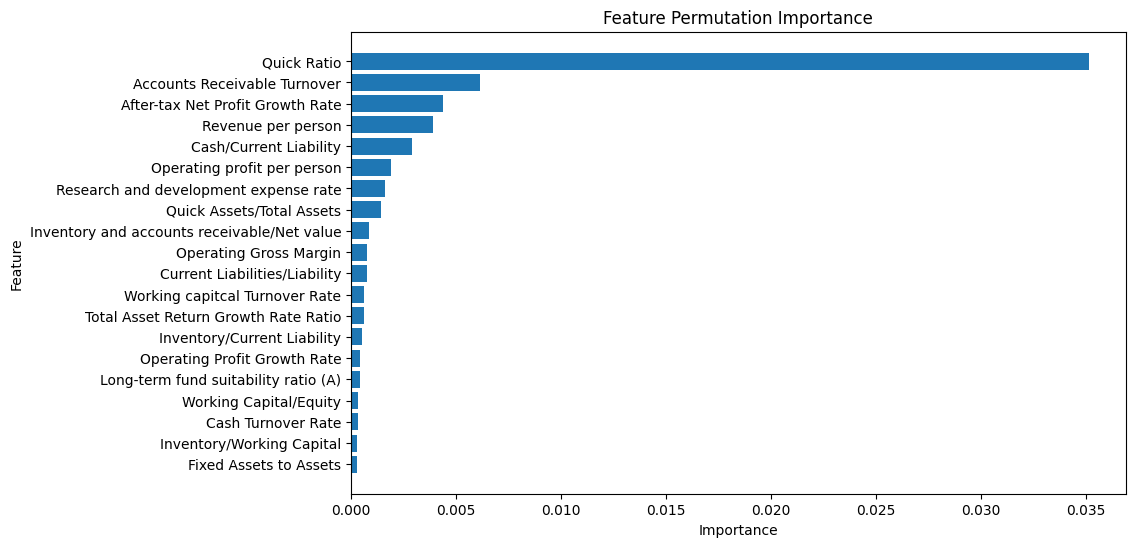

In [ ]:
plot_feat_permut_importance(xgb2_feat_permut_import_df)

In [ ]:
xgb2_perf, xgb2_orig_missing, xgb2_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Quick Ratio
Original feat removed so far:  ['Quick Ratio']

--- NEW ITERATION ---
Removing feature:  Accounts Receivable Turnover
Original feat removed so far:  ['Quick Ratio', 'Accounts Receivable Turnover']

--- NEW ITERATION ---
Removing feature:  After-tax Net Profit Growth Rate
Original feat removed so far:  ['Quick Ratio', 'Accounts Receivable Turnover', 'After-tax Net Profit Growth Rate']

--- NEW ITERATION ---
Removing feature:  Revenue per person
Original feat removed so far:  ['Quick Ratio', 'Accounts Receivable Turnover', 'After-tax Net Profit Growth Rate', 'Revenue per person']

--- NEW ITERATION ---
Removing feature:  Cash/Current Liability
Original feat removed so far:  ['Quick Ratio', 'Accounts Receivable Turnover', 'After-tax Net Profit Growth Rate', 'Revenue per person', 'Cash/Current Liability']

--- NEW ITERATION ---
Removing feature:  Operating profit per person
Original feat removed so far:  ['Quick Ratio', 'Accounts Receiv

In [ ]:
xgb2_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   29  1267  53  15      35.37   65.91        95.98     95.01     46.03   
1   22  1293  27  22      44.90   50.00        97.95     96.41     47.31   
2   20  1297  23  24      46.51   45.45        98.26     96.55     45.98   
3   23  1292  28  21      45.10   52.27        97.88     96.41     48.42   
4   24  1290  30  20      44.44   54.55        97.73     96.33     48.98   
5   27  1281  39  17      40.91   61.36        97.05     95.89     49.09   
6   26  1282  38  18      40.62   59.09        97.12     95.89     48.15   
7   28  1280  40  16      41.18   63.64        96.97     95.89     50.00   
8   29  1278  42  15      40.85   65.91        96.82     95.82     50.43   
9   29  1278  42  15      40.85   65.91        96.82     95.82     50.43   
10  29  1280  40  15      42.03   65.91        96.97     95.97     51.33   
11  29  1277  43  15      40.28   65.91        96.74     95.75     50.00   
12  29  1272  48  15      37.66   65.91        96.36     95.38     47.93   
13  30  1271  49  14      37.97   68.18        96.29     95.38     48.78   
14  29  1272  48  15      37.66   65.91        96.36     95.38     47.93   
15  30  1268  52  14      36.59   68.18        96.06     95.16     47.62   
16  30  1266  54  14      35.71   68.18        95.91     95.01     46.88   
17  30  1265  55  14      35.29   68.18        95.83     94.94     46.51   
18  32  1263  57  12      35.96   72.73        95.68     94.94     48.12   
19  30  1263  57  14      34.48   68.18        95.68     94.79     45.80   
20  30  1270  50  14      37.50   68.18        96.21     95.31     48.39   

    balanced_accuracy  num_feat_missing  \
0               80.95                 0   
1               73.98                 1   
2               71.86                 2   
3               75.08                 3   
4               76.14                 4   
5               79.20                 5   
6               78.11                 6   
7               80.30                 7   
8               81.36                 8   
9               81.36                 9   
10              81.44                10   
11              81.33                11   
12              81.14                12   
13              82.23                13   
14              81.14                14   
15              82.12                15   
16              82.05                16   
17              82.01                17   
18              84.20                18   
19              81.93                19   
20              82.20                20   

                                              imputed  
0                                                      
1                             ['Quick Ratio'] imputed  
2   ['Quick Ratio', 'Accounts Receivable Turnover'...  
3   ['Quick Ratio', 'Accounts Receivable Turnover'...  
4   ['Quick Ratio', 'Accounts Receivable Turnover'...  
5   ['Quick Ratio', 'Accounts Receivable Turnover'...  
6   ['Quick Ratio', 'Accounts Receivable Turnover'...  
7   ['Quick Ratio', 'Accounts Receivable Turnover'...  
8   ['Quick Ratio', 'Accounts Receivable Turnover'...  
9   ['Quick Ratio', 'Accounts Receivable Turnover'...  
10  ['Quick Ratio', 'Accounts Receivable Turnover'...  
11  ['Quick Ratio', 'Accounts Receivable Turnover'...  
12  ['Quick Ratio', 'Accounts Receivable Turnover'...  
13  ['Quick Ratio', 'Accounts Receivable Turnover'...  
14  ['Quick Ratio', 'Accounts Receivable Turnover'...  
15  ['Quick Ratio', 'Accounts Receivable Turnover'...  
16  ['Quick Ratio', 'Accounts Receivable Turnover'...  
17  ['Quick Ratio', 'Accounts Receivable Turnover'...  
18  ['Quick Ratio', 'Accounts Receivable Turnover'...  
19  ['Quick Ratio', 'Accounts Receivable Turnover'...  
20  ['Quick Ratio', 'Accounts Receivable Turnover'...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb2_perf_mf, xgb2_orig_missing_mf, xgb2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 11:52:12.196100

--- NEW ITERATION ---
Removing feature:  Quick Ratio
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Continuous interest rate (after tax)', 'Total income/Total expense', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Non-industry income and expenditure/revenue', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Operating Gross Margin', 'Interest Expense Ratio', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Total expense/Assets', 'Total Asset Return Growth Rate Ratio', 'Cash flow rate', 'Cash Flow Per Share', 'Inventory and accounts receivable/Net value', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Cash Flow to Equity', 'Working capitcal Turnover Rate', 'Cash/Current Liabili

In [ ]:
xgb2_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   29  1267  53  15      35.37   65.91        95.98     95.01     46.03   
1   22  1292  28  22      44.00   50.00        97.88     96.33     46.81   
2   20  1299  21  24      48.78   45.45        98.41     96.70     47.06   
3   19  1303  17  25      52.78   43.18        98.71     96.92     47.50   
4   19  1298  22  25      46.34   43.18        98.33     96.55     44.71   
5   23  1289  31  21      42.59   52.27        97.65     96.19     46.94   
6   21  1288  32  23      39.62   47.73        97.58     95.97     43.30   
7   24  1284  36  20      40.00   54.55        97.27     95.89     46.15   
8   23  1286  34  21      40.35   52.27        97.42     95.97     45.54   
9   23  1286  34  21      40.35   52.27        97.42     95.97     45.54   
10  24  1287  33  20      42.11   54.55        97.50     96.11     47.52   
11  23  1285  35  21      39.66   52.27        97.35     95.89     45.10   
12  23  1286  34  21      40.35   52.27        97.42     95.97     45.54   
13  23  1284  36  21      38.98   52.27        97.27     95.82     44.66   
14  22  1291  29  22      43.14   50.00        97.80     96.26     46.32   
15  22  1292  28  22      44.00   50.00        97.88     96.33     46.81   
16  21  1290  30  23      41.18   47.73        97.73     96.11     44.21   
17  22  1289  31  22      41.51   50.00        97.65     96.11     45.36   
18  22  1287  33  22      40.00   50.00        97.50     95.97     44.44   
19  23  1290  30  21      43.40   52.27        97.73     96.26     47.42   
20  23  1287  33  21      41.07   52.27        97.50     96.04     46.00   

    balanced_accuracy  num_feat_missing  \
0               80.95                 0   
1               73.94                 1   
2               71.93                 2   
3               70.95                 3   
4               70.76                 4   
5               74.96                 5   
6               72.65                 6   
7               75.91                 7   
8               74.85                 8   
9               74.85                 9   
10              76.02                10   
11              74.81                11   
12              74.85                12   
13              74.77                13   
14              73.90                14   
15              73.94                15   
16              72.73                16   
17              73.83                17   
18              73.75                18   
19              75.00                19   
20              74.89                20   

                                              imputed  
0                                                      
1                             ['Quick Ratio'] imputed  
2   ['Quick Ratio', 'Accounts Receivable Turnover'...  
3   ['Quick Ratio', 'Accounts Receivable Turnover'...  
4   ['Quick Ratio', 'Accounts Receivable Turnover'...  
5   ['Quick Ratio', 'Accounts Receivable Turnover'...  
6   ['Quick Ratio', 'Accounts Receivable Turnover'...  
7   ['Quick Ratio', 'Accounts Receivable Turnover'...  
8   ['Quick Ratio', 'Accounts Receivable Turnover'...  
9   ['Quick Ratio', 'Accounts Receivable Turnover'...  
10  ['Quick Ratio', 'Accounts Receivable Turnover'...  
11  ['Quick Ratio', 'Accounts Receivable Turnover'...  
12  ['Quick Ratio', 'Accounts Receivable Turnover'...  
13  ['Quick Ratio', 'Accounts Receivable Turnover'...  
14  ['Quick Ratio', 'Accounts Receivable Turnover'...  
15  ['Quick Ratio', 'Accounts Receivable Turnover'...  
16  ['Quick Ratio', 'Accounts Receivable Turnover'...  
17  ['Quick Ratio', 'Accounts Receivable Turnover'...  
18  ['Quick Ratio', 'Accounts Receivable Turnover'...  
19  ['Quick Ratio', 'Accounts Receivable Turnover'...  
20  ['Quick Ratio', 'Accounts Receivable Turnover'...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et2_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et2_param_grid = {
      'n_estimators': [200],
      'max_depth': [3],
      'max_features':[1.0],
      'min_samples_split': [0.005],
      'min_samples_leaf': [0.005]
  }

et2_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et2_grid_search, et2_best_model, et2_best_params = hyperparameter_tuning(
    et2_classifier, et2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 11:57:45.480033

Nested Cross-validation Results:
Individual scores: [0.87955027 0.81909287 0.91085073]
Average nested CV score: 0.870 (+/- 0.076)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 3, 'max_features': 1.0, 'min_samples_leaf': 0.005, 'min_samples_split': 0.005, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.870
2025-01-16 11:57:51.761572

Execution time: 0.10 minutes




```
Starting hyperparameter tuning at: 2025-01-15 15:16:24.974039

Nested Cross-validation Results:
Individual scores: [0.8739166  0.78034875 0.89896513]
Average nested CV score: 0.851 (+/- 0.102)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': 3, 'max_features': 1.0, 'min_samples_leaf': 0.005, 'min_samples_split': 0.005, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.870

Train score: 0.881
Test score: 0.870
Train-test score difference: 0.011
2025-01-15 15:37:10.304715

Execution time: 20.76 minutes
```



In [ ]:
# et2_grid_search.cv_results_

In [ ]:
et2_classifier, train_pred, test_pred = apply_model(et2_best_model, X_train, y_train, X_test, y_test)
et2_feat_permut_import_df = analyze_feat_permut_import(et2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
et2_feat_permut_import_df[et2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
1                                Borrowing dependency    0.014299  0.003206
14                                       Tax rate (A)    0.014068  0.007761
13                                Equity to Liability    0.013882  0.008059
24                                  Cash/Total Assets    0.006912  0.003177
3                          Current Liabilities/Equity    0.001913  0.001354
4                 Current Liability to Current Assets    0.001761  0.001769
36                    Fixed Assets Turnover Frequency    0.001704  0.001590
18  Interest Coverage Ratio (Interest expense to E...    0.000833  0.000139
23        Inventory and accounts receivable/Net value    0.000455  0.000219
46                                 Cash Turnover Rate    0.000208  0.000184
25                   After-tax Net Profit Growth Rate    0.000170  0.000093
40                              Net Value Growth Rate    0.000152  0.000176
27                     Working capitcal Turnover Rate    0.000133  0.000046
52                      Current Liabilities/Liability    0.000095  0.000085
50                          Quick Asset Turnover Rate    0.000057  0.000076
49                                        Quick Ratio    0.000038  0.000229
26                                Cash Flow to Equity    0.000019  0.000038
28                             Cash/Current Liability    0.000019  0.000038
43                                 Revenue per person    0.000019  0.000038
55                             Operating Expense Rate    0.000019  0.000038
53                Interest-bearing debt interest rate    0.000019  0.000038
37                       Operating Profit Growth Rate   -0.000019  0.000038
8                              Working Capital/Equity   -0.000038  0.000165
57                         Allocation rate per person   -0.000076  0.000038
62                     Quick Assets/Current Liability   -0.000076  0.000093
61                            Average Collection Days   -0.000076  0.000038
42               Long-term fund suitability ratio (A)   -0.000114  0.000110
10        Non-industry income and expenditure/revenue   -0.000114  0.000152
30                 Degree of Financial Leverage (DFL)   -0.000133  0.000076
51                         Total debt/Total net worth   -0.000152  0.000046
38                             Fixed Assets to Assets   -0.000170  0.000110
31                          Quick Assets/Total Assets   -0.000189  0.000254
35                               Total Asset Turnover   -0.000322  0.000303
20               Total Asset Return Growth Rate Ratio   -0.000322  0.000176
32                             Cash Flow to Liability   -0.000398  0.000110
16                             Operating Gross Margin   -0.000436  0.000176
63                                      Current Ratio   -0.000511  0.000326
19                               Total expense/Assets   -0.000511  0.000229
22                                Cash Flow Per Share   -0.000549  0.000346
21                                     Cash flow rate   -0.000682  0.000184
17                             Interest Expense Ratio   -0.000720  0.000046
5                Continuous interest rate (after tax)   -0.000852  0.000311
39                            Total Asset Growth Rate   -0.001023  0.004401
12                      Equity to Long-term Liability   -0.001080  0.000580
7                             Net Value Per Share (A)   -0.001099  0.002982
11                        Operating profit per person   -0.001193  0.000367
9                 Operating Profit Per Share (Yuan ¥)   -0.002918  0.001275
0                  Net Income to Stockholder's Equity   -0.003845  0.001502
2                   Retained Earnings to Total Assets   -0.005153  0.003288
6                          Total income/Total expense   -0.005438  0.002374

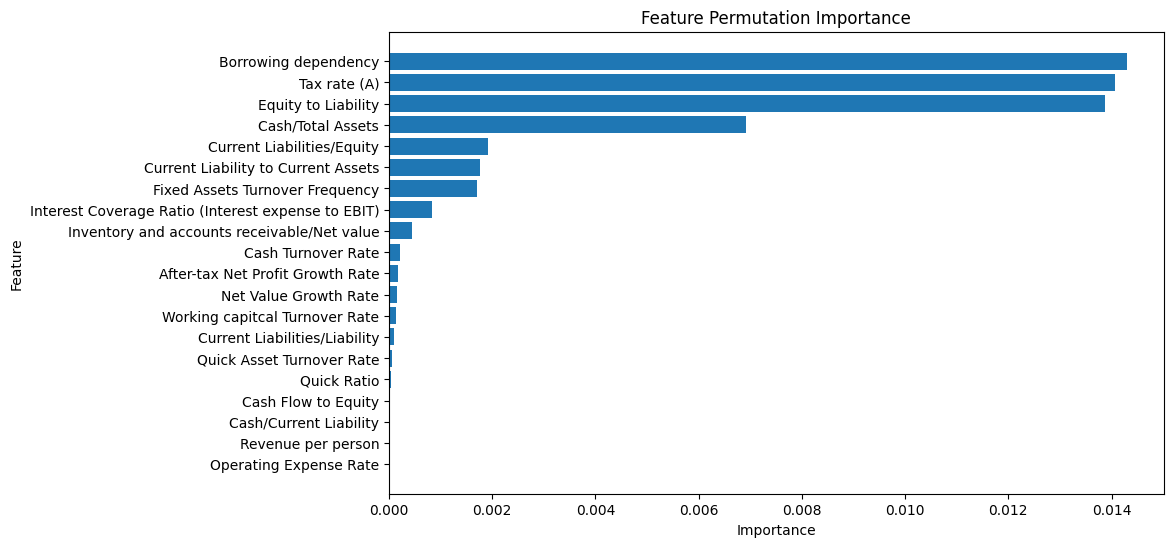

In [ ]:
plot_feat_permut_importance(et2_feat_permut_import_df)

In [ ]:
et2_perf, et2_orig_missing, et2_missing = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Borrowing dependency
Original feat removed so far:  ['Borrowing dependency']

--- NEW ITERATION ---
Removing feature:  Tax rate (A)
Original feat removed so far:  ['Borrowing dependency', 'Tax rate (A)']

--- NEW ITERATION ---
Removing feature:  Equity to Liability
Original feat removed so far:  ['Borrowing dependency', 'Tax rate (A)', 'Equity to Liability']

--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Original feat removed so far:  ['Borrowing dependency', 'Tax rate (A)', 'Equity to Liability', 'Cash/Total Assets']

--- NEW ITERATION ---
Removing feature:  Current Liabilities/Equity
Original feat removed so far:  ['Borrowing dependency', 'Tax rate (A)', 'Equity to Liability', 'Cash/Total Assets', 'Current Liabilities/Equity']

--- NEW ITERATION ---
Removing feature:  Current Liability to Current Assets
Original feat removed so far:  ['Borrowing dependency', 'Tax rate (A)', 'Equity to Liability', 'Cash/Total Assets', 'Current Lia

In [ ]:
et2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   39  1100  220   5      15.06   88.64        83.33     83.50     25.74   
1   37  1139  181   7      16.97   84.09        86.29     86.22     28.24   
2   29  1232   88  15      24.79   65.91        93.33     92.45     36.02   
3   25  1234   86  19      22.52   56.82        93.48     92.30     32.26   
4   24  1237   83  20      22.43   54.55        93.71     92.45     31.79   
5   23  1244   76  21      23.23   52.27        94.24     92.89     32.17   
6   20  1248   72  24      21.74   45.45        94.55     92.96     29.41   
7   20  1256   64  24      23.81   45.45        95.15     93.55     31.25   
8   20  1262   58  24      25.64   45.45        95.61     93.99     32.79   
9   20  1262   58  24      25.64   45.45        95.61     93.99     32.79   
10  20  1262   58  24      25.64   45.45        95.61     93.99     32.79   
11  20  1261   59  24      25.32   45.45        95.53     93.91     32.52   
12  20  1260   60  24      25.00   45.45        95.45     93.84     32.26   
13  20  1261   59  24      25.32   45.45        95.53     93.91     32.52   
14  20  1261   59  24      25.32   45.45        95.53     93.91     32.52   
15  20  1261   59  24      25.32   45.45        95.53     93.91     32.52   
16  20  1262   58  24      25.64   45.45        95.61     93.99     32.79   
17  20  1262   58  24      25.64   45.45        95.61     93.99     32.79   
18  20  1262   58  24      25.64   45.45        95.61     93.99     32.79   
19  20  1262   58  24      25.64   45.45        95.61     93.99     32.79   
20  20  1262   58  24      25.64   45.45        95.61     93.99     32.79   

    balanced_accuracy  num_feat_missing  \
0               85.98                 0   
1               85.19                 1   
2               79.62                 2   
3               75.15                 3   
4               74.13                 4   
5               73.26                 5   
6               70.00                 6   
7               70.30                 7   
8               70.53                 8   
9               70.53                 9   
10              70.53                10   
11              70.49                11   
12              70.45                12   
13              70.49                13   
14              70.49                14   
15              70.49                15   
16              70.53                16   
17              70.53                17   
18              70.53                18   
19              70.53                19   
20              70.53                20   

                                              imputed  
0                                                      
1                    ['Borrowing dependency'] imputed  
2    ['Borrowing dependency', 'Tax rate (A)'] imputed  
3   ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
4   ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
5   ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
6   ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
7   ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
8   ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
9   ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
10  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
11  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
12  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
13  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
14  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
15  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
16  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
17  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
18  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
19  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
20  ['Borrowing dependency', 'Tax rate (A)', 'Equi...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et2_perf_mf, et2_orig_missing_mf, et2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 11:57:56.671571

--- NEW ITERATION ---
Removing feature:  Borrowing dependency
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Continuous interest rate (after tax)', 'Total income/Total expense', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Non-industry income and expenditure/revenue', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Operating Gross Margin', 'Interest Expense Ratio', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Total expense/Assets', 'Total Asset Return Growth Rate Ratio', 'Cash flow rate', 'Cash Flow Per Share', 'Inventory and accounts receivable/Net value', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Cash Flow to Equity', 'Working capitcal Turnover Rate', 'Cash/Curren

In [ ]:
et2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   39  1100  220   5      15.06   88.64        83.33     83.50     25.74   
1   37  1099  221   7      14.34   84.09        83.26     83.28     24.50   
2   35  1167  153   9      18.62   79.55        88.41     88.12     30.17   
3   34  1185  135  10      20.12   77.27        89.77     89.37     31.92   
4   34  1183  137  10      19.88   77.27        89.62     89.22     31.63   
5   33  1185  135  11      19.64   75.00        89.77     89.30     31.13   
6   34  1188  132  10      20.48   77.27        90.00     89.59     32.38   
7   33  1187  133  11      19.88   75.00        89.92     89.44     31.43   
8   32  1189  131  12      19.63   72.73        90.08     89.52     30.92   
9   33  1189  131  11      20.12   75.00        90.08     89.59     31.73   
10  33  1179  141  11      18.97   75.00        89.32     88.86     30.28   
11  33  1179  141  11      18.97   75.00        89.32     88.86     30.28   
12  33  1182  138  11      19.30   75.00        89.55     89.08     30.70   
13  33  1186  134  11      19.76   75.00        89.85     89.37     31.28   
14  33  1187  133  11      19.88   75.00        89.92     89.44     31.43   
15  33  1187  133  11      19.88   75.00        89.92     89.44     31.43   
16  31  1189  131  13      19.14   70.45        90.08     89.44     30.10   
17  31  1192  128  13      19.50   70.45        90.30     89.66     30.54   
18  31  1195  125  13      19.87   70.45        90.53     89.88     31.00   
19  31  1194  126  13      19.75   70.45        90.45     89.81     30.85   
20  32  1193  127  12      20.13   72.73        90.38     89.81     31.53   

    balanced_accuracy  num_feat_missing  \
0               85.98                 0   
1               83.67                 1   
2               83.98                 2   
3               83.52                 3   
4               83.45                 4   
5               82.39                 5   
6               83.64                 6   
7               82.46                 7   
8               81.40                 8   
9               82.54                 9   
10              82.16                10   
11              82.16                11   
12              82.27                12   
13              82.42                13   
14              82.46                14   
15              82.46                15   
16              80.27                16   
17              80.38                17   
18              80.49                18   
19              80.45                19   
20              81.55                20   

                                              imputed  
0                                                      
1                    ['Borrowing dependency'] imputed  
2    ['Borrowing dependency', 'Tax rate (A)'] imputed  
3   ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
4   ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
5   ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
6   ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
7   ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
8   ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
9   ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
10  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
11  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
12  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
13  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
14  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
15  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
16  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
17  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
18  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
19  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  
20  ['Borrowing dependency', 'Tax rate (A)', 'Equi...

##**Support Vector Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],
      'kernel': ['linear', 'poly', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1, 2],
      'degree': [2, 3, 4, 5]
  }
else:
  # best model
  svm2_param_grid = {
    'C': [1],
    'kernel': ['linear'],
    'gamma': ['scale'],
    'degree': [2]
}

svm2_classifier = SVC(class_weight='balanced', random_state=RANDOM_STATE)
svm2_grid_search, svm2_best_model, svm2_best_params = hyperparameter_tuning(
    svm2_classifier, svm2_param_grid, 3, 3, 'balanced_accuracy', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-16 12:03:38.290409

Nested Cross-validation Results:
Individual scores: [0.84191063 0.75846395 0.87661518]
Average nested CV score: 0.826 (+/- 0.099)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

Best Model Performance:
Best CV score: 0.826
2025-01-16 12:03:43.020641

Execution time: 0.08 minutes


```
Starting hyperparameter tuning at: 2025-01-15 15:37:10.314513

Nested Cross-validation Results:
Individual scores: [0.82216872 0.76262735 0.88116322]
Average nested CV score: 0.822 (+/- 0.097)

Fitting final model on entire dataset...
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

Best Model Performance:
Best CV score: 0.826

Train score: 0.850
Test score: 0.826
Train-test score difference: 0.025
2025-01-15 15:42:21.458826

Execution time: 5.19 minutes
```



In [ ]:
svm2_classifier, train_pred, test_pred = apply_model(svm2_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm2_feat_permut_import_df = analyze_feat_permut_import(svm2_classifier, X_train_scaled, y_train, scoring_metric="balanced_accuracy")
svm2_feat_permut_import_df[svm2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
24                                  Cash/Total Assets    0.051059  0.008770
2                   Retained Earnings to Total Assets    0.012859  0.002492
7                             Net Value Per Share (A)    0.012612  0.004663
4                 Current Liability to Current Assets    0.011988  0.005674
13                                Equity to Liability    0.010037  0.006050
19                               Total expense/Assets    0.009887  0.003606
6                          Total income/Total expense    0.006685  0.005588
15                              Liability-Assets Flag    0.006193  0.000046
31                          Quick Assets/Total Assets    0.005949  0.004771
35                               Total Asset Turnover    0.004299  0.002692
36                    Fixed Assets Turnover Frequency    0.003731  0.003905
11                        Operating profit per person    0.003560  0.004016
9                 Operating Profit Per Share (Yuan ¥)    0.003086  0.002675
46                                 Cash Turnover Rate    0.003050  0.003786
30                 Degree of Financial Leverage (DFL)    0.002633  0.000093
51                         Total debt/Total net worth    0.002595  0.001209
32                             Cash Flow to Liability    0.000700  0.003083
55                             Operating Expense Rate    0.000587  0.001723
48                          Total assets to GNP price    0.000473  0.001189
1                                Borrowing dependency    0.000454  0.001222
37                       Operating Profit Growth Rate    0.000246  0.000046
42               Long-term fund suitability ratio (A)    0.000189  0.000085
29                                 No-credit Interval    0.000170  0.000126
25                   After-tax Net Profit Growth Rate    0.000114  0.000071
60                       Accounts Receivable Turnover    0.000095  0.000085
18  Interest Coverage Ratio (Interest expense to E...    0.000095  0.000060
14                                       Tax rate (A)    0.000075  0.004829
45            Realized Sales Gross Profit Growth Rate    0.000019  0.000038
52                      Current Liabilities/Liability   -0.000018  0.003311
56                    Inventory Turnover Rate (times)   -0.000019  0.000330
63                                      Current Ratio   -0.000019  0.000038
59              Long-term Liability to Current Assets   -0.000019  0.000038
62                     Quick Assets/Current Liability   -0.000019  0.000038
40                              Net Value Growth Rate   -0.000019  0.000038
41                  Continuous Net Profit Growth Rate   -0.000019  0.000038
61                            Average Collection Days   -0.000038  0.000046
34                   Contingent liabilities/Net worth   -0.000038  0.000046
3                          Current Liabilities/Equity   -0.000057  0.000258
57                         Allocation rate per person   -0.000076  0.000071
49                                        Quick Ratio   -0.000076  0.000093
26                                Cash Flow to Equity   -0.000095  0.000000
5                Continuous interest rate (after tax)   -0.000095  0.000000
10        Non-industry income and expenditure/revenue   -0.000095  0.000000
0                  Net Income to Stockholder's Equity   -0.000114  0.000071
28                             Cash/Current Liability   -0.000114  0.000163
54                        Current Asset Turnover Rate   -0.000133  0.000303
16                             Operating Gross Margin   -0.000190  0.003087
21                                     Cash flow rate   -0.000360  0.001182
22                                Cash Flow Per Share   -0.000568  0.001385
23        Inventory and accounts receivable/Net value   -0.000587  0.000899
8                              Working Capital/Equity   -0.000758  0.001199
39                            Total Asset Growth Rate   -0.001610  0.002598
53                

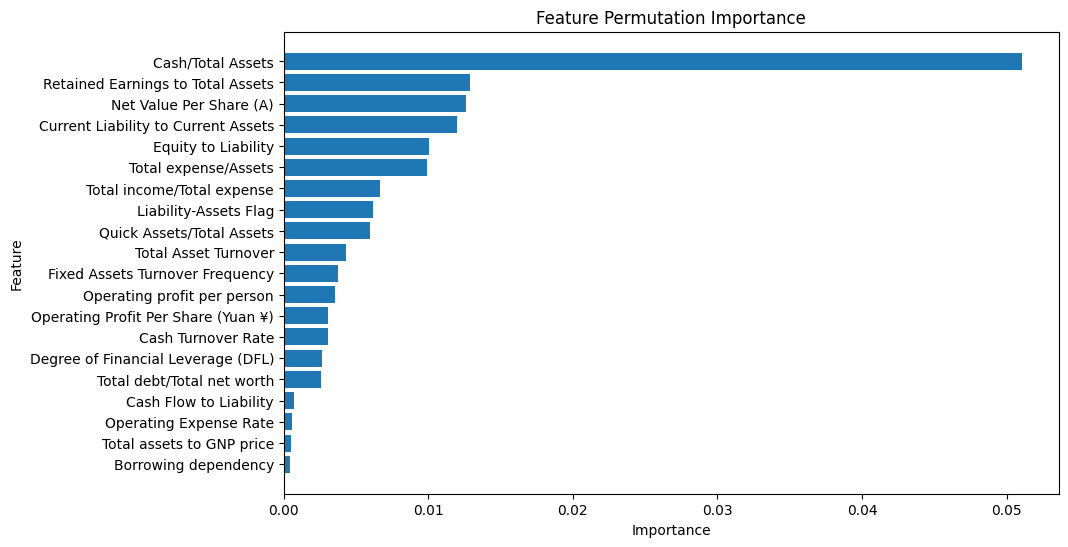

In [ ]:
plot_feat_permut_importance(svm2_feat_permut_import_df)

In [ ]:
svm2_perf, svm2_orig_missing, svm2_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    taiwan_imputation_scaled_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Original feat removed so far:  ['Cash/Total Assets']

--- NEW ITERATION ---
Removing feature:  Retained Earnings to Total Assets
Original feat removed so far:  ['Cash/Total Assets', 'Retained Earnings to Total Assets']

--- NEW ITERATION ---
Removing feature:  Net Value Per Share (A)
Original feat removed so far:  ['Cash/Total Assets', 'Retained Earnings to Total Assets', 'Net Value Per Share (A)']

--- NEW ITERATION ---
Removing feature:  Current Liability to Current Assets
Original feat removed so far:  ['Cash/Total Assets', 'Retained Earnings to Total Assets', 'Net Value Per Share (A)', 'Current Liability to Current Assets']

--- NEW ITERATION ---
Removing feature:  Equity to Liability
Original feat removed so far:  ['Cash/Total Assets', 'Retained Earnings to Total Assets', 'Net Value Per Share (A)', 'Current Liability to Current Assets', 'Equity to Liability']

--- NEW ITERATION ---
Removing feature:  Total expense/Assets


In [ ]:
svm2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   35  1116  204   9      14.64   79.55        84.55     84.38     24.73   
1   33  1109  211  11      13.52   75.00        84.02     83.72     22.92   
2   32  1148  172  12      15.69   72.73        86.97     86.51     25.81   
3   28  1172  148  16      15.91   63.64        88.79     87.98     25.45   
4   25  1207  113  19      18.12   56.82        91.44     90.32     27.47   
5   24  1167  153  20      13.56   54.55        88.41     87.32     21.72   
6   20  1184  136  24      12.82   45.45        89.70     88.27     20.00   
7   17  1202  118  27      12.59   38.64        91.06     89.37     18.99   
8   16  1202  118  28      11.94   36.36        91.06     89.30     17.98   
9   21  1183  137  23      13.29   47.73        89.62     88.27     20.79   
10  15  1228   92  29      14.02   34.09        93.03     91.13     19.87   
11   7  1293   27  37      20.59   15.91        97.95     95.31     17.95   
12   6  1298   22  38      21.43   13.64        98.33     95.60     16.67   
13   5  1305   15  39      25.00   11.36        98.86     96.04     15.62   
14   5  1306   14  39      26.32   11.36        98.94     96.11     15.87   
15   5  1309   11  39      31.25   11.36        99.17     96.33     16.67   
16   5  1309   11  39      31.25   11.36        99.17     96.33     16.67   
17   5  1314    6  39      45.45   11.36        99.55     96.70     18.18   
18   4  1314    6  40      40.00    9.09        99.55     96.63     14.81   
19   5  1314    6  39      45.45   11.36        99.55     96.70     18.18   
20   4  1315    5  40      44.44    9.09        99.62     96.70     15.09   

    balanced_accuracy  num_feat_missing  \
0               82.05                 0   
1               79.51                 1   
2               79.85                 2   
3               76.21                 3   
4               74.13                 4   
5               71.48                 5   
6               67.58                 6   
7               64.85                 7   
8               63.71                 8   
9               68.67                 9   
10              63.56                10   
11              56.93                11   
12              55.98                12   
13              55.11                13   
14              55.15                14   
15              55.27                15   
16              55.27                16   
17              55.45                17   
18              54.32                18   
19              55.45                19   
20              54.36                20   

                                              imputed  
0                                                      
1                       ['Cash/Total Assets'] imputed  
2   ['Cash/Total Assets', 'Retained Earnings to To...  
3   ['Cash/Total Assets', 'Retained Earnings to To...  
4   ['Cash/Total Assets', 'Retained Earnings to To...  
5   ['Cash/Total Assets', 'Retained Earnings to To...  
6   ['Cash/Total Assets', 'Retained Earnings to To...  
7   ['Cash/Total Assets', 'Retained Earnings to To...  
8   ['Cash/Total Assets', 'Retained Earnings to To...  
9   ['Cash/Total Assets', 'Retained Earnings to To...  
10  ['Cash/Total Assets', 'Retained Earnings to To...  
11  ['Cash/Total Assets', 'Retained Earnings to To...  
12  ['Cash/Total Assets', 'Retained Earnings to To...  
13  ['Cash/Total Assets', 'Retained Earnings to To...  
14  ['Cash/Total Assets', 'Retained Earnings to To...  
15  ['Cash/Total Assets', 'Retained Earnings to To...  
16  ['Cash/Total Assets', 'Retained Earnings to To...  
17  ['Cash/Total Assets', 'Retained Earnings to To...  
18  ['Cash/Total Assets', 'Retained Earnings to To...  
19  ['Cash/Total Assets', 'Retained Earnings to To...  
20  ['Cash/Total Assets', 'Retained Earnings to To...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm2_perf_mf, svm2_orig_missing_mf, svm2_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 12:04:09.753005

--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Continuous interest rate (after tax)', 'Total income/Total expense', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Non-industry income and expenditure/revenue', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Operating Gross Margin', 'Interest Expense Ratio', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Total expense/Assets', 'Total Asset Return Growth Rate Ratio', 'Cash flow rate', 'Cash Flow Per Share', 'Inventory and accounts receivable/Net value', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Cash Flow to Equity', 'Working capitcal Turnover Rate', 'Cash/Current L

In [ ]:
svm2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   35  1116  204   9      14.64   79.55        84.55     84.38     24.73   
1   35  1124  196   9      15.15   79.55        85.15     84.97     25.45   
2   34  1130  190  10      15.18   77.27        85.61     85.34     25.37   
3   35  1144  176   9      16.59   79.55        86.67     86.44     27.45   
4   35  1141  179   9      16.36   79.55        86.44     86.22     27.13   
5   35  1152  168   9      17.24   79.55        87.27     87.02     28.34   
6   34  1156  164  10      17.17   77.27        87.58     87.24     28.10   
7   34  1161  159  10      17.62   77.27        87.95     87.61     28.69   
8   33  1161  159  11      17.19   75.00        87.95     87.54     27.97   
9   32  1178  142  12      18.39   72.73        89.24     88.71     29.36   
10  31  1183  137  13      18.45   70.45        89.62     89.00     29.25   
11  28  1198  122  16      18.67   63.64        90.76     89.88     28.87   
12  27  1207  113  17      19.29   61.36        91.44     90.47     29.35   
13  24  1222   98  20      19.67   54.55        92.58     91.35     28.92   
14  29  1208  112  15      20.57   65.91        91.52     90.69     31.35   
15  29  1209  111  15      20.71   65.91        91.59     90.76     31.52   
16  29  1209  111  15      20.71   65.91        91.59     90.76     31.52   
17  29  1211  109  15      21.01   65.91        91.74     90.91     31.87   
18  31  1206  114  13      21.38   70.45        91.36     90.69     32.80   
19  31  1204  116  13      21.09   70.45        91.21     90.54     32.46   
20  28  1205  115  16      19.58   63.64        91.29     90.40     29.95   

    balanced_accuracy  num_feat_missing  \
0               82.05                 0   
1               82.35                 1   
2               81.44                 2   
3               83.11                 3   
4               82.99                 4   
5               83.41                 5   
6               82.42                 6   
7               82.61                 7   
8               81.48                 8   
9               80.98                 9   
10              80.04                10   
11              77.20                11   
12              76.40                12   
13              73.56                13   
14              78.71                14   
15              78.75                15   
16              78.75                16   
17              78.83                17   
18              80.91                18   
19              80.83                19   
20              77.46                20   

                                              imputed  
0                                                      
1                       ['Cash/Total Assets'] imputed  
2   ['Cash/Total Assets', 'Retained Earnings to To...  
3   ['Cash/Total Assets', 'Retained Earnings to To...  
4   ['Cash/Total Assets', 'Retained Earnings to To...  
5   ['Cash/Total Assets', 'Retained Earnings to To...  
6   ['Cash/Total Assets', 'Retained Earnings to To...  
7   ['Cash/Total Assets', 'Retained Earnings to To...  
8   ['Cash/Total Assets', 'Retained Earnings to To...  
9   ['Cash/Total Assets', 'Retained Earnings to To...  
10  ['Cash/Total Assets', 'Retained Earnings to To...  
11  ['Cash/Total Assets', 'Retained Earnings to To...  
12  ['Cash/Total Assets', 'Retained Earnings to To...  
13  ['Cash/Total Assets', 'Retained Earnings to To...  
14  ['Cash/Total Assets', 'Retained Earnings to To...  
15  ['Cash/Total Assets', 'Retained Earnings to To...  
16  ['Cash/Total Assets', 'Retained Earnings to To...  
17  ['Cash/Total Assets', 'Retained Earnings to To...  
18  ['Cash/Total Assets', 'Retained Earnings to To...  
19  ['Cash/Total Assets', 'Retained Earnings to To...  
20  ['Cash/Total Assets', 'Retained Earnings to To...

##**Logistic Regression**

In [ ]:
len(lr_X_test.columns)

64

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],            # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']         # Algorithm to use in the optimization problem
  }
else:
  lr2_param_grid = {
      'C': [5.0],
      'penalty': ['l1'],
      'solver': ['liblinear']
  }

lr2_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr2_grid_search, lr2_best_model, lr2_best_params = hyperparameter_tuning(
    lr2_classifier, lr2_param_grid, 3, 3, 'balanced_accuracy', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 12:09:12.880703

Nested Cross-validation Results:
Individual scores: [0.83916602 0.77067986 0.85573949]
Average nested CV score: 0.822 (+/- 0.074)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 5.0, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.822
2025-01-16 12:10:00.639034

Execution time: 0.80 minutes




```
Starting hyperparameter tuning at: 2025-01-15 15:42:21.473717

Nested Cross-validation Results:
Individual scores: [0.82250096 0.75978644 0.85573949]
Average nested CV score: 0.813 (+/- 0.080)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 5, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.822

Train score: 0.878
Test score: 0.822
Train-test score difference: 0.057
2025-01-15 15:44:43.101431

Execution time: 2.36 minutes
```



In [ ]:
lr2_classifier, train_pred, test_pred = apply_model(lr2_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr2_feat_permut_import_df = analyze_feat_permut_import(lr2_classifier, lr_X_train, y_train, scoring_metric="balanced_accuracy")
lr2_feat_permut_import_df[lr2_feat_permut_import_df['Importance']!=0]

Feature    Importance       Std
13                                Equity to Liability  9.397592e-02  0.008326
6                          Total income/Total expense  7.283792e-02  0.012036
24                                  Cash/Total Assets  3.535804e-02  0.006914
1                                Borrowing dependency  2.552890e-02  0.004179
32                             Cash Flow to Liability  1.859867e-02  0.011347
2                   Retained Earnings to Total Assets  9.033111e-03  0.006624
19                               Total expense/Assets  7.973919e-03  0.004448
15                              Liability-Assets Flag  6.193279e-03  0.000046
31                          Quick Assets/Total Assets  5.379484e-03  0.004275
7                             Net Value Per Share (A)  5.226326e-03  0.004518
52                      Current Liabilities/Liability  4.887182e-03  0.004194
56                    Inventory Turnover Rate (times)  4.583771e-03  0.007213
42               Long-term fund suitability ratio (A)  3.466027e-03  0.000142
9                 Operating Profit Per Share (Yuan ¥)  3.200503e-03  0.003051
36                    Fixed Assets Turnover Frequency  3.067902e-03  0.003560
50                          Quick Asset Turnover Rate  2.537929e-03  0.004066
55                             Operating Expense Rate  2.310721e-03  0.001539
30                 Degree of Financial Leverage (DFL)  2.121183e-03  0.001067
51                         Total debt/Total net worth  1.969747e-03  0.001417
4                 Current Liability to Current Assets  1.533951e-03  0.002066
53                Interest-bearing debt interest rate  1.268857e-03  0.001436
26                                Cash Flow to Equity  1.174680e-03  0.004299
46                                 Cash Turnover Rate  1.023244e-03  0.005849
60                       Accounts Receivable Turnover  1.003870e-03  0.001208
54                        Current Asset Turnover Rate  1.003763e-03  0.001359
25                   After-tax Net Profit Growth Rate  6.251184e-04  0.000097
14                                       Tax rate (A)  6.250108e-04  0.003340
61                            Average Collection Days  6.250108e-04  0.001109
48                          Total assets to GNP price  6.060678e-04  0.001118
29                                 No-credit Interval  3.220307e-04  0.000195
23        Inventory and accounts receivable/Net value  2.466893e-04  0.002380
62                     Quick Assets/Current Liability  5.682894e-05  0.000046
37                       Operating Profit Growth Rate  3.788596e-05  0.000046
59              Long-term Liability to Current Assets  1.894298e-05  0.000093
47              Research and development expense rate  2.152612e-07  0.002837
17                             Interest Expense Ratio -3.788596e-05  0.000076
45            Realized Sales Gross Profit Growth Rate -3.788596e-05  0.000097
57                         Allocation rate per person -3.788596e-05  0.000097
58                        Inventory/Current Liability -5.682894e-05  0.000046
18  Interest Coverage Ratio (Interest expense to E... -7.577193e-05  0.000038
28                             Cash/Current Liability -2.083728e-04  0.000071
11                        Operating profit per person -1.117528e-03  0.001219
39                            Total Asset Growth Rate -1.136364e-03  0.001135
16                             Operating Gross Margin -1.420616e-03  0.002885
35                               Total Asset Turnover -1.458287e-03  0.007895

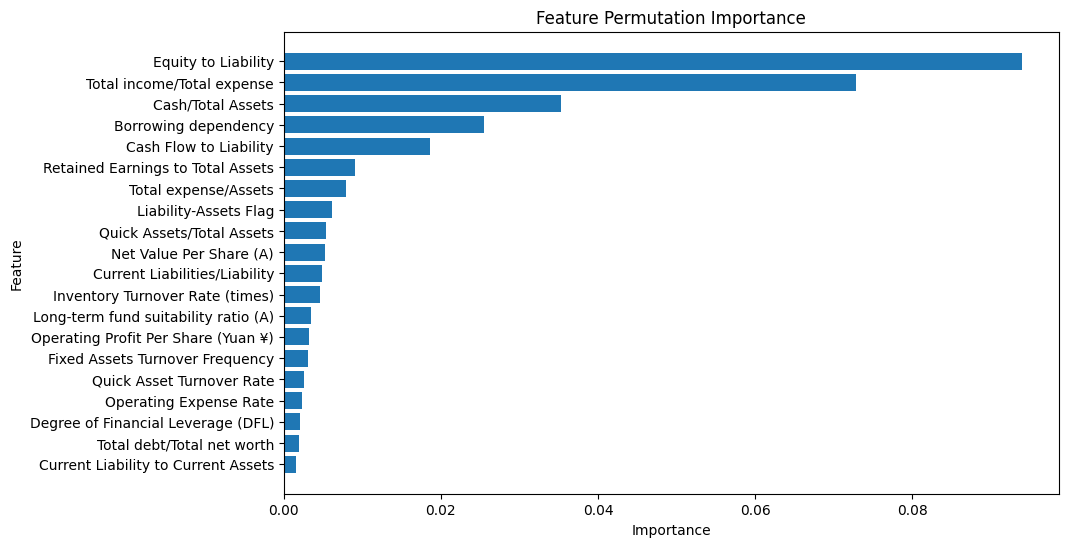

In [ ]:
plot_feat_permut_importance(lr2_feat_permut_import_df)

In [ ]:
lr2_perf, lr2_orig_missing, lr2_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Equity to Liability
Original feat removed so far:  ['Equity to Liability']

--- NEW ITERATION ---
Removing feature:  Total income/Total expense
Original feat removed so far:  ['Equity to Liability', 'Total income/Total expense']

--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Original feat removed so far:  ['Equity to Liability', 'Total income/Total expense', 'Cash/Total Assets']

--- NEW ITERATION ---
Removing feature:  Borrowing dependency
Original feat removed so far:  ['Equity to Liability', 'Total income/Total expense', 'Cash/Total Assets', 'Borrowing dependency']

--- NEW ITERATION ---
Removing feature:  Cash Flow to Liability
Original feat removed so far:  ['Equity to Liability', 'Total income/Total expense', 'Cash/Total Assets', 'Borrowing dependency', 'Cash Flow to Liability']

--- NEW ITERATION ---
Removing feature:  Retained Earnings to Total Assets
Original feat removed so far:  ['Equity to Liability', 'Total income/Tota

In [ ]:
lr2_perf

tp    tn    fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1160   160   8      18.37   81.82        87.88     87.68     30.00   
1   34  1169   151  10      18.38   77.27        88.56     88.20     29.69   
2   44    12  1308   0       3.25  100.00         0.91      4.11      6.30   
3   44     4  1316   0       3.24  100.00         0.30      3.52      6.27   
4   44     4  1316   0       3.24  100.00         0.30      3.52      6.27   
5   44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
6   44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
7   44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
8   44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
9   44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
10  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
11  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
12  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
13  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
14  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
15  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
16  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
17  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
18  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
19  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   
20  44     2  1318   0       3.23  100.00         0.15      3.37      6.26   

    balanced_accuracy  num_feat_missing  \
0               84.85                 0   
1               82.92                 1   
2               50.45                 2   
3               50.15                 3   
4               50.15                 4   
5               50.08                 5   
6               50.08                 6   
7               50.08                 7   
8               50.08                 8   
9               50.08                 9   
10              50.08                10   
11              50.08                11   
12              50.08                12   
13              50.08                13   
14              50.08                14   
15              50.08                15   
16              50.08                16   
17              50.08                17   
18              50.08                18   
19              50.08                19   
20              50.08                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Total income/Total ex...  
3   ['Equity to Liability', 'Total income/Total ex...  
4   ['Equity to Liability', 'Total income/Total ex...  
5   ['Equity to Liability', 'Total income/Total ex...  
6   ['Equity to Liability', 'Total income/Total ex...  
7   ['Equity to Liability', 'Total income/Total ex...  
8   ['Equity to Liability', 'Total income/Total ex...  
9   ['Equity to Liability', 'Total income/Total ex...  
10  ['Equity to Liability', 'Total income/Total ex...  
11  ['Equity to Liability', 'Total income/Total ex...  
12  ['Equity to Liability', 'Total income/Total ex...  
13  ['Equity to Liability', 'Total income/Total ex...  
14  ['Equity to Liability', 'Total income/Total ex...  
15  ['Equity to Liability', 'Total income/Total ex...  
16  ['Equity to Liability', 'Total income/Total ex...  
17  ['Equity to Liability', 'Total income/Total ex...  
18  ['Equity to Liability', 'Total income/Total ex...  
19  ['Equity to Liability', 'Total income/Total ex...  
20  ['Equity to Liability', 'Total income/Total ex...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr2_perf_mf, lr2_orig_missing_mf, lr2_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 12:10:18.117795

--- NEW ITERATION ---
Removing feature:  Equity to Liability
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liabilities/Equity', 'Current Liability to Current Assets', 'Continuous interest rate (after tax)', 'Total income/Total expense', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Non-industry income and expenditure/revenue', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Operating Gross Margin', 'Interest Expense Ratio', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Total expense/Assets', 'Total Asset Return Growth Rate Ratio', 'Cash flow rate', 'Cash Flow Per Share', 'Inventory and accounts receivable/Net value', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Cash Flow to Equity', 'Working capitcal Turnover Rate', 'Cash/Current

In [ ]:
lr2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1160  160   8      18.37   81.82        87.88     87.68     30.00   
1   36  1181  139   8      20.57   81.82        89.47     89.22     32.88   
2   36  1187  133   8      21.30   81.82        89.92     89.66     33.80   
3   35  1191  129   9      21.34   79.55        90.23     89.88     33.65   
4   33  1201  119  11      21.71   75.00        90.98     90.47     33.67   
5   32  1200  120  12      21.05   72.73        90.91     90.32     32.65   
6   30  1204  116  14      20.55   68.18        91.21     90.47     31.58   
7   31  1205  115  13      21.23   70.45        91.29     90.62     32.63   
8   30  1205  115  14      20.69   68.18        91.29     90.54     31.75   
9   29  1210  110  15      20.86   65.91        91.67     90.84     31.69   
10  28  1219  101  16      21.71   63.64        92.35     91.42     32.37   
11  28  1223   97  16      22.40   63.64        92.65     91.72     33.14   
12  29  1227   93  15      23.77   65.91        92.95     92.08     34.94   
13  29  1227   93  15      23.77   65.91        92.95     92.08     34.94   
14  25  1244   76  19      24.75   56.82        94.24     93.04     34.48   
15  24  1251   69  20      25.81   54.55        94.77     93.48     35.04   
16  28  1248   72  16      28.00   63.64        94.55     93.55     38.89   
17  30  1245   75  14      28.57   68.18        94.32     93.48     40.27   
18  29  1247   73  15      28.43   65.91        94.47     93.55     39.73   
19  29  1246   74  15      28.16   65.91        94.39     93.48     39.46   
20  28  1256   64  16      30.43   63.64        95.15     94.13     41.18   

    balanced_accuracy  num_feat_missing  \
0               84.85                 0   
1               85.64                 1   
2               85.87                 2   
3               84.89                 3   
4               82.99                 4   
5               81.82                 5   
6               79.70                 6   
7               80.87                 7   
8               79.73                 8   
9               78.79                 9   
10              77.99                10   
11              78.14                11   
12              79.43                12   
13              79.43                13   
14              75.53                14   
15              74.66                15   
16              79.09                16   
17              81.25                17   
18              80.19                18   
19              80.15                19   
20              79.39                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Total income/Total ex...  
3   ['Equity to Liability', 'Total income/Total ex...  
4   ['Equity to Liability', 'Total income/Total ex...  
5   ['Equity to Liability', 'Total income/Total ex...  
6   ['Equity to Liability', 'Total income/Total ex...  
7   ['Equity to Liability', 'Total income/Total ex...  
8   ['Equity to Liability', 'Total income/Total ex...  
9   ['Equity to Liability', 'Total income/Total ex...  
10  ['Equity to Liability', 'Total income/Total ex...  
11  ['Equity to Liability', 'Total income/Total ex...  
12  ['Equity to Liability', 'Total income/Total ex...  
13  ['Equity to Liability', 'Total income/Total ex...  
14  ['Equity to Liability', 'Total income/Total ex...  
15  ['Equity to Liability', 'Total income/Total ex...  
16  ['Equity to Liability', 'Total income/Total ex...  
17  ['Equity to Liability', 'Total income/Total ex...  
18  ['Equity to Liability', 'Total income/Total ex...  
19  ['Equity to Liability', 'Total income/Total ex...  
20  ['Equity to Liability', 'Total income/Total ex...

# **Results comparison**

##**F1-score**

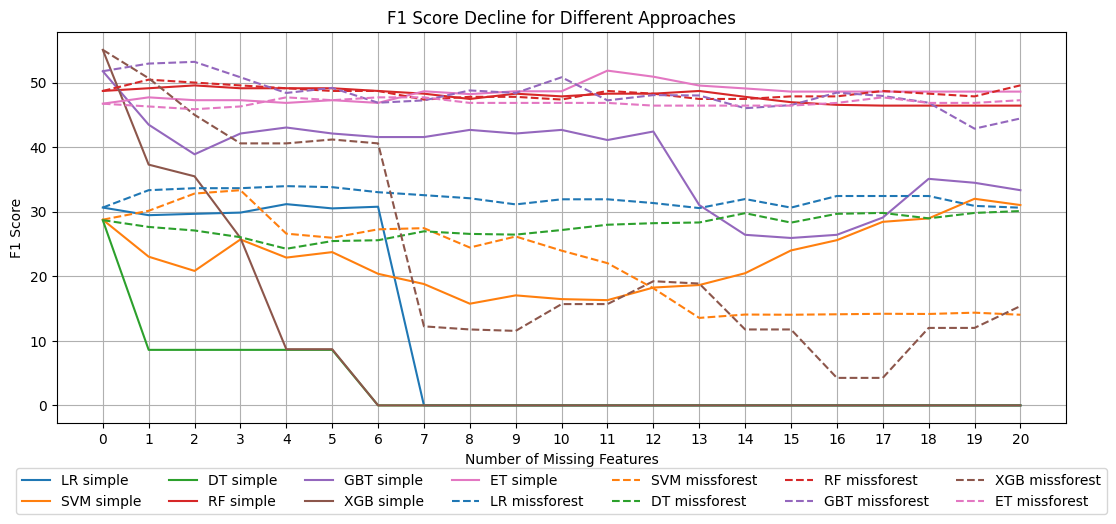

In [ ]:
# # Line plot for the f1 score of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr_perf['num_feat_missing'], lr_perf['f1_score'], label='LR simple', color=colors[0])
plt.plot(svm_perf['num_feat_missing'], svm_perf['f1_score'], label='SVM simple', color=colors[1])
plt.plot(dt_perf['num_feat_missing'], dt_perf['f1_score'], label='DT simple', color=colors[2])
plt.plot(rf_perf['num_feat_missing'], rf_perf['f1_score'], label='RF simple', color=colors[3])
plt.plot(gbt_perf['num_feat_missing'], gbt_perf['f1_score'], label='GBT simple', color=colors[4])
plt.plot(xgb_perf['num_feat_missing'], xgb_perf['f1_score'], label='XGB simple', color=colors[5])
plt.plot(et_perf['num_feat_missing'], et_perf['f1_score'], label='ET simple', color=colors[6])

plt.plot(lr_perf_mf['num_feat_missing'], lr_perf_mf['f1_score'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm_perf_mf['num_feat_missing'], svm_perf_mf['f1_score'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt_perf_mf['num_feat_missing'], dt_perf_mf['f1_score'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf_perf_mf['num_feat_missing'], rf_perf_mf['f1_score'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt_perf_mf['num_feat_missing'], gbt_perf_mf['f1_score'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb_perf_mf['num_feat_missing'], xgb_perf_mf['f1_score'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et_perf_mf['num_feat_missing'], et_perf_mf['f1_score'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score')
plt.title('F1 Score Decline for Different Approaches')
plt.xticks(et_perf.index.astype(int))
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

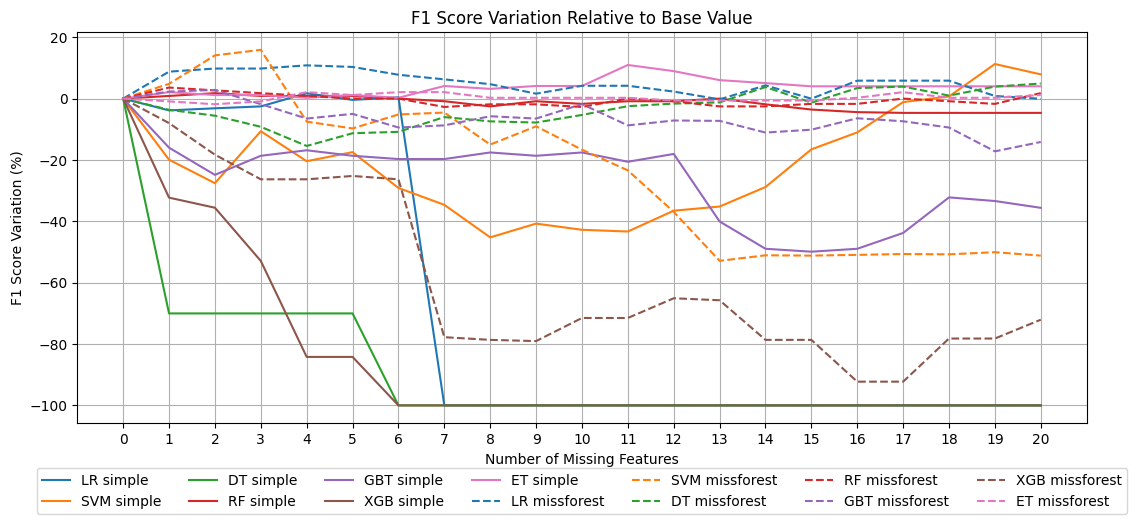

In [ ]:
# # Line plot for the f1 score variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the F1-score variation for each model
for perf_df, label, color, linestyle in zip(
    [lr_perf, svm_perf, dt_perf, rf_perf, gbt_perf, xgb_perf, et_perf,
     lr_perf_mf, svm_perf_mf, dt_perf_mf, rf_perf_mf, gbt_perf_mf, xgb_perf_mf, et_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base F1-score
    f1_variation = (perf_df['f1_score'] - perf_df['f1_score'].iloc[0]) / perf_df['f1_score'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], f1_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score Variation (%)')
plt.title('F1 Score Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##**Balanced Accuracy**

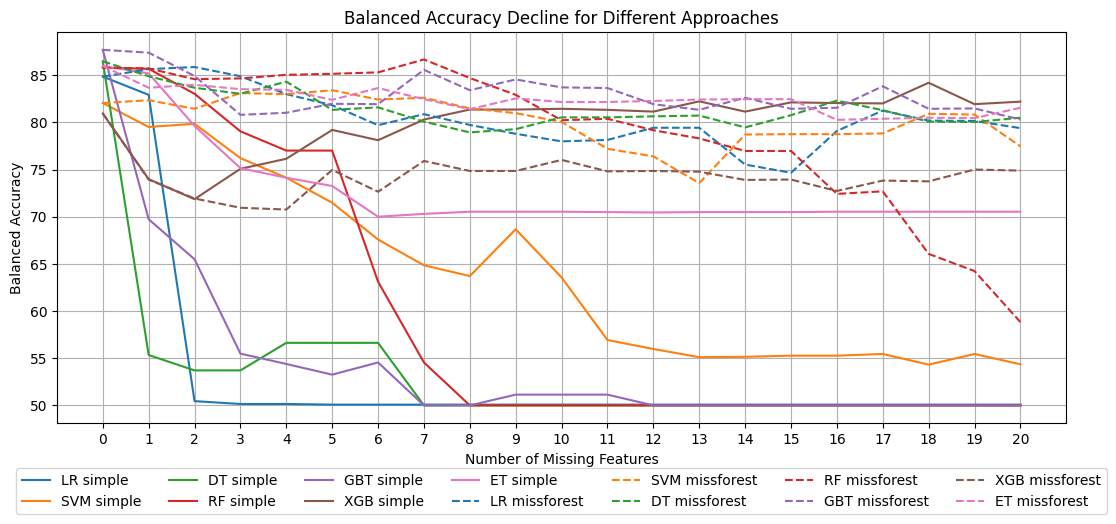

In [ ]:
# # Line plot for the balanced accuracy of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr2_perf['num_feat_missing'], lr2_perf['balanced_accuracy'], label='LR simple', color=colors[0])
plt.plot(svm2_perf['num_feat_missing'], svm2_perf['balanced_accuracy'], label='SVM simple', color=colors[1])
plt.plot(dt2_perf['num_feat_missing'], dt2_perf['balanced_accuracy'], label='DT simple', color=colors[2])
plt.plot(rf2_perf['num_feat_missing'], rf2_perf['balanced_accuracy'], label='RF simple', color=colors[3])
plt.plot(gbt2_perf['num_feat_missing'], gbt2_perf['balanced_accuracy'], label='GBT simple', color=colors[4])
plt.plot(xgb2_perf['num_feat_missing'], xgb2_perf['balanced_accuracy'], label='XGB simple', color=colors[5])
plt.plot(et2_perf['num_feat_missing'], et2_perf['balanced_accuracy'], label='ET simple', color=colors[6])

plt.plot(lr2_perf_mf['num_feat_missing'], lr2_perf_mf['balanced_accuracy'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm2_perf_mf['num_feat_missing'], svm2_perf_mf['balanced_accuracy'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt2_perf_mf['num_feat_missing'], dt2_perf_mf['balanced_accuracy'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf2_perf_mf['num_feat_missing'], rf2_perf_mf['balanced_accuracy'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt2_perf_mf['num_feat_missing'], gbt2_perf_mf['balanced_accuracy'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb2_perf_mf['num_feat_missing'], xgb2_perf_mf['balanced_accuracy'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et2_perf_mf['num_feat_missing'], et2_perf_mf['balanced_accuracy'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Decline for Different Approaches')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

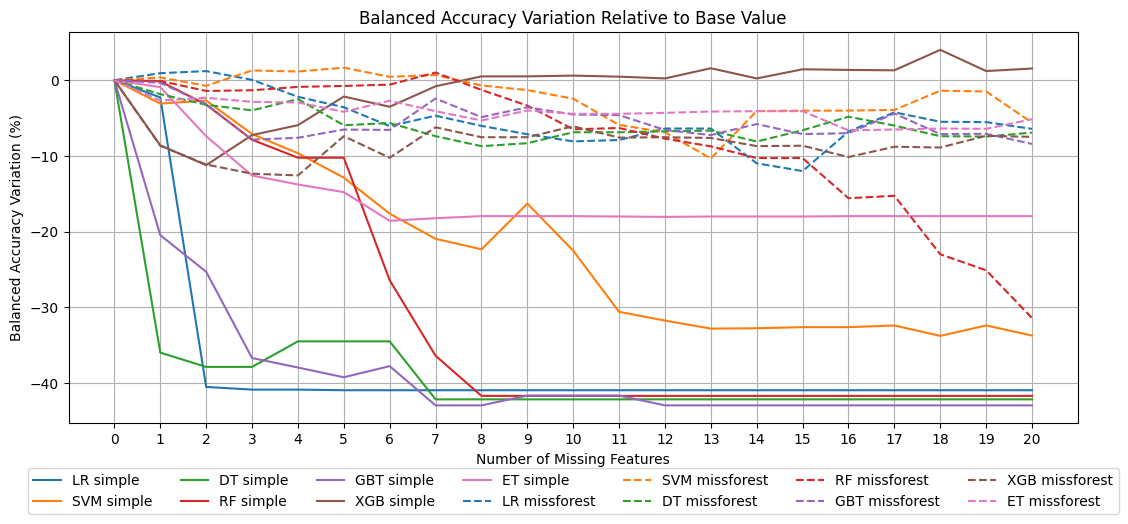

In [ ]:
# # Line plot for the balanced accuracy variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the Balanced Accuracy variation for each model
for perf_df, label, color, linestyle in zip(
    [lr2_perf, svm2_perf, dt2_perf, rf2_perf, gbt2_perf, xgb2_perf, et2_perf,
     lr2_perf_mf, svm2_perf_mf, dt2_perf_mf, rf2_perf_mf, gbt2_perf_mf, xgb2_perf_mf, et2_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base Balanced Accuracy
    balanced_accy_variation = (perf_df['balanced_accuracy'] - perf_df['balanced_accuracy'].iloc[0]) / perf_df['balanced_accuracy'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], balanced_accy_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy Variation (%)')
plt.title('Balanced Accuracy Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# **Save results**

In [ ]:
dataset_dict = {
    'lr_perf': lr_perf,
    'svm_perf': svm_perf,
    'dt_perf': dt_perf,
    'rf_perf': rf_perf,
    'gbt_perf': gbt_perf,
    'xgb_perf': xgb_perf,
    'et_perf': et_perf,
    'lr_perf_mf': lr_perf_mf,
    'svm_perf_mf': svm_perf_mf,
    'dt_perf_mf': dt_perf_mf,
    'rf_perf_mf': rf_perf_mf,
    'gbt_perf_mf': gbt_perf_mf,
    'xgb_perf_mf': xgb_perf_mf,
    'et_perf_mf': et_perf_mf,
    'lr2_perf': lr2_perf,
    'svm2_perf': svm2_perf,
    'dt2_perf': dt2_perf,
    'rf2_perf': rf2_perf,
    'gbt2_perf': gbt2_perf,
    'xgb2_perf': xgb2_perf,
    'et2_perf': et2_perf,
    'lr2_perf_mf': lr2_perf_mf,
    'svm2_perf_mf': svm2_perf_mf,
    'dt2_perf_mf': dt2_perf_mf,
    'rf2_perf_mf': rf2_perf_mf,
    'gbt2_perf_mf': gbt2_perf_mf,
    'xgb2_perf_mf': xgb2_perf_mf,
    'et2_perf_mf': et2_perf_mf,
}

all_data = combine_datasets(
    dataset_dict,
    'Taiwanese Bankruptcy', 'Scenario 2: drop intercorrelated',
    RANDOM_STATE
)
save_dataset(all_data, 'taiwanese_bankruptcy_scenario2_seed_1981.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
all_data

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0    36  1165  155   8      18.85   81.82        88.26     88.05     30.64   
1    33  1173  147  11      18.33   75.00        88.86     88.42     29.46   
2    31  1186  134  13      18.79   70.45        89.85     89.22     29.67   
3    33  1176  144  11      18.64   75.00        89.09     88.64     29.86   
4    36  1169  151   8      19.25   81.82        88.56     88.34     31.17   
..   ..   ...  ...  ..        ...     ...          ...       ...       ...   
583  31  1189  131  13      19.14   70.45        90.08     89.44     30.10   
584  31  1192  128  13      19.50   70.45        90.30     89.66     30.54   
585  31  1195  125  13      19.87   70.45        90.53     89.88     31.00   
586  31  1194  126  13      19.75   70.45        90.45     89.81     30.85   
587  32  1193  127  12      20.13   72.73        90.38     89.81     31.53   

     balanced_accuracy  num_feat_missing  \
0                85.04                 0   
1                81.93                 1   
2                80.15                 2   
3                82.05                 3   
4                85.19                 4   
..                 ...               ...   
583              80.27                16   
584              80.38                17   
585              80.49                18   
586              80.45                19   
587              81.55                20   

                                               imputed      dataset  \
0                                                           lr_perf   
1                      ['Equity to Liability'] imputed      lr_perf   
2    ['Equity to Liability', 'Cash Flow to Liabilit...      lr_perf   
3    ['Equity to Liability', 'Cash Flow to Liabilit...      lr_perf   
4    ['Equity to Liability', 'Cash Flow to Liabilit...      lr_perf   
..                                                 ...          ...   
583  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  et2_perf_mf   
584  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  et2_perf_mf   
585  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  et2_perf_mf   
586  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  et2_perf_mf   
587  ['Borrowing dependency', 'Tax rate (A)', 'Equi...  et2_perf_mf   

                   source                          scenario  random_state  \
0    Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          1981   
1    Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          1981   
2    Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          1981   
3    Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          1981   
4    Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          1981   
..                    ...                               ...           ...   
583  Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          1981   
584  Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          1981   
585  Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          1981   
586  Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          1981   
587  Taiwanese Bankruptcy  Scenario 2: drop intercorrelated          1981   

                metric  
0             f1 score  
1             f1 score  
2             f1 score  
3             f1 score  
4             f1 score  
..                 ...  
583  balanced accuracy  
584  balanced accuracy  
585  balanced accuracy  
586  balanced accuracy  
587  balanced accuracy  

[588 rows x 17 columns]